In [61]:
import numpy as np
from numpy.fft import *
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.colors
import pandas as pd
import scipy.signal as ss
from scipy import stats
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from scipy import interpolate
import tensorflow as tf
from pyopenms import * 
from configobj import ConfigObj
import subprocess
import os
from pptx import Presentation
from pptx.util import Inches, Pt
from pptx.enum.shapes import MSO_CONNECTOR
from pptx.enum.text import PP_ALIGN
import IsoSpecPy
import h5py
import pickle
import jdc

In [2]:
plt.rcParams["figure.figsize"] = (13,7)

In [3]:
C13_Shift=1.0033548
Proton=1.0072764666

## LC-MS data

In [4]:
lcmf_std_prot=h5py.File("D:\\FT Data\\Data Samples\\decay_ecoli\\Ecoli_Normal_ChMe_Top1_PrM_22965-28432_chB_rs.h5")
lcmf_std_pept=h5py.File("D:\\FT Data\\Data Samples\\decay_ecoli\\Ecoli_Normal_ChMe_Top1_STD_28481-33822_chB_rs.h5")
lcmf_mono_prot=h5py.File("D:\\FT Data\\Data Samples\\decay_ecoli\\Ecoli_Monoisotop_ChMe_Top1_PrM_4-5872_chB_rs.h5 ")
lcmf_mono_pept=h5py.File("D:\\FT Data\\Data Samples\\decay_ecoli\\Ecoli_Monoisotop_ChMe_Top1_STD_5913-11842_chB_rs.h5")

In [5]:
plt.rcParams["figure.figsize"] = (18,10)

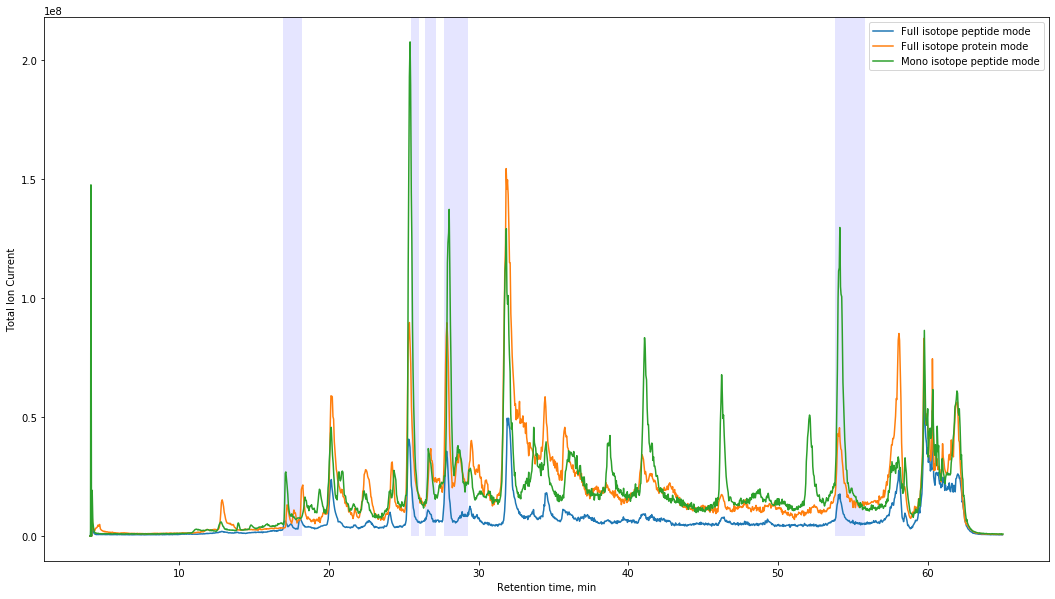

In [6]:
lcset=[lcmf_std_pept,lcmf_std_prot,lcmf_mono_pept]
legends = ["Full isotope peptide mode","Full isotope protein mode","Mono isotope peptide mode","Mono isotope protein mode"]
fig, ax = plt.subplots()
for lcmf in lcset:
    lcScan=list(lcmf.keys())
    lcTime=[lcmf[k].attrs["r_h_start_time"] for k in lcScan]
    lcTIC=[lcmf[k].attrs["r_h_tic"] for k in lcScan]
    lcOrder=[lcmf[k].attrs["r_h_ms_order"] for k in lcScan]
    lcPrecursor=[lcmf[k].attrs["r_h_precursor_mz"] for k in lcScan]
    lcSize=[lcmf[k].size for k in lcScan]
    lcData=pd.DataFrame({"Scan":lcScan, "Time":lcTime, "TIC":lcTIC, "Size":lcSize, "Order":lcOrder , "Precursor":lcPrecursor})
    lcData=lcData.sort_values("Time")
    lcDataF = lcData[(lcData["Size"]>1000000) & (lcData["Order"]==1)]
    #lcDataF = lcDataF[lcDataF["Size"]<7000000]
    ax.plot(lcDataF["Time"],lcDataF["TIC"])
plt.legend(legends)
rect=plt.Rectangle((26.4,0), 0.75, 2.2e8,facecolor="blue", alpha=0.1)
ax.add_patch(rect)
rect=plt.Rectangle((25.5,0), 0.5, 2.2e8,facecolor="blue", alpha=0.1)
ax.add_patch(rect)
rect=plt.Rectangle((27.7,0), 1.6, 2.2e8,facecolor="blue", alpha=0.1)
ax.add_patch(rect)
rect=plt.Rectangle((53.8,0), 2., 2.2e8,facecolor="blue", alpha=0.1)
ax.add_patch(rect)
rect=plt.Rectangle((16.9,0), 1.3, 2.2e8,facecolor="blue", alpha=0.1)
ax.add_patch(rect)
plt.ylabel("Total Ion Current")
plt.xlabel("Retention time, min")
plt.show()

In [7]:
#lcmf=lcmf_std_pept
def ExtractLCData(lcmf):
    lcScan=list(lcmf.keys())
    lcTime=[lcmf[k].attrs["r_h_start_time"] for k in lcScan]
    lcTIC=[lcmf[k].attrs["r_h_tic"] for k in lcScan]
    lcOrder=[lcmf[k].attrs["r_h_ms_order"] for k in lcScan]
    lcPrecursor=[lcmf[k].attrs["r_h_precursor_mz"] for k in lcScan]
    lcSize=[lcmf[k].size for k in lcScan]
    lcCharge=[lcmf[k].attrs["r_h_charge_state"] for k in lcScan]
    lcMass=(np.array(lcPrecursor)-1.0072764666)*lcCharge
    lcData=pd.DataFrame({"Scan":lcScan, "Time":lcTime, "TIC":lcTIC, "Size":lcSize, "Order":lcOrder, 
                         "Precursor":lcPrecursor, "Charge":lcCharge, "Mass":lcMass})
    lcData=lcData.sort_values("Time")
    return lcData
#lcDataF = lcData[(lcData["Size"]>1000000) & (lcData["Order"]==1)]


In [8]:
def ExtractLCMSMS(lcData):
    lcmsms=lcData[(lcData["Order"]==2)&(lcData["Size"]>5000000)].sort_values("Precursor")
    lcmsms["Number"]=0
    counter=1
    for i in lcmsms.index:
        if lcmsms.loc[i]["Number"]>0:
            continue
        mz=lcmsms.loc[i]["Precursor"]
        lcmsms.loc[(np.abs(lcmsms["Precursor"]-mz)<mz/1000)&(lcmsms["Number"]==0),"Number"]=counter
        mass=lcmsms.loc[i]["Mass"]
        if mass > 0.0:
            lcmsms.loc[(np.abs(lcmsms["Mass"]-mass)<mass/1000)&(lcmsms["Number"]==0),"Number"]=counter
        #if counter == 16:
        #    break
        counter+=1
    #Undefined masses
    for i in range(counter):
        if np.alltrue(lcmsms[lcmsms["Number"]==i]["Charge"]==0):
            mz=np.mean(lcmsms[lcmsms["Number"]==i]["Precursor"])
            print(i,mz)
            relatives=lcmsms.loc[(np.abs(lcmsms["Precursor"]-mz)<mz/10000)&(lcmsms["Number"]!=i)]
            if not relatives.empty: 
                lcmsms.loc[lcmsms["Number"]==i,"Number"]=relatives.iloc[0]["Number"]
                print(relatives)
    #RT gap
    for i in range(counter):
        #break
        trace=lcmsms[lcmsms["Number"]==i].sort_values("Time")
        trace["Diff"]=np.abs(trace.shift(1)["Time"]-trace["Time"]).replace(np.nan,0)
        current=i
        for row in trace.iterrows():
            if row[1]["Diff"]>0.5:
                current=counter
                counter+=1
            lcmsms.at[row[0],"Number"]=current
    return lcmsms
#lcmsms.sort_values("Time").head(50)

In [9]:
lcData=ExtractLCData(lcmf_mono_pept)
lcmsms_mono_pept=ExtractLCMSMS(lcData)
lcData=ExtractLCData(lcmf_std_pept)
lcmsms_std_pept=ExtractLCMSMS(lcData)
lcData=ExtractLCData(lcmf_mono_prot)
lcmsms_mono_prot=ExtractLCMSMS(lcData)
lcData=ExtractLCData(lcmf_std_prot)
lcmsms_std_prot=ExtractLCMSMS(lcData)

0 nan
1 704.5224609375
2 705.5819091796875
4 711.4681396484375
7 738.5073852539062
8 758.5931396484375
9 767.4638061523438
10 768.4083251953125
11 769.340576171875
      Scan       Time         TIC     Size  Order   Precursor  Charge  \
2691  8123  27.999251  71058192.0  6150224      2  769.340149      12   
2727  8177  28.503635   2074536.6  6149272      2  769.340149      12   
2709  8150  28.249962  13928488.0  6149784      2  769.340393      12   
2769  8240  29.101940    618192.0  6149344      2  769.340637      12   

             Mass  Number  
2691  9219.994470       3  
2727  9219.994470       3  
2709  9219.997399       3  
2769  9220.000329       3  
20 827.439453125
24 840.6428833007812
25 841.7353515625
26 849.3570556640625
30 883.0715942382812
33 912.9942626953125
34 915.344482421875
35 918.3538818359375
37 923.48681640625
40 951.8074951171875
41 954.0966796875
48 998.1224365234375
50 1007.045928955078
53 1017.134338378906
59 1039.1535644531252
      Scan       Time      

In [10]:
#NumbersOI=[[!18,19,41],[!14,14,11],[!3,11,25],[!54,28,67],[!147,54,58],
#           [!101,46,117],[!46,47,77],[69,35,68],[!140,29,57],[!16,16,39]]
NumbersOI=[[18,19,41,"MLYVIYAQDKADSLEKRLSVRPAHLARLQLLHDEGRLLTAGPMPAVDSNDPGAAGFTGSTVIAEFESLEAAQAWADADPYVAAGVYEHVSVKPFKKVF","Protein YciI","YciI"],
           [14,14,11,"MNKTQLIDVIAEKAELSKTQAKAALESTLAAITESLKEGDAVQLVGFGTFKVNHRAERTGRNPQTGKEIKIAAANVPAFVSGKALKDAVK","DNA-binding protein HU-alpha","HU-alpha"],
           [3,11,25,"MNKSQLIDKIAAGADISKAAAGRALDAIIASVTESLKEGDDVALVGFGTFAVKERAARTGRNPQTGKEITIAAAKVPSFRAGKALKDAVN","DNA-binding protein HU-beta","HU-beta"],
           [69,35,68,"S[+42.01056]ITKDQIIEAVAAMSVMDVVELISAMEEKFGVSAAAAVAVAAGPVEAAEEKTEFDVILKAAGANKVAVIKAVRGATGLGLKEAKDLVESAPAALKEGVSKDDAEALKKALEEAGAEVEVK","50S ribosomal protein L7-L12","50S L7-L12"],
           [16,16,39,"AKIKGQVKWFNESKGFGFITPADGSKDVFVHFSAIQGNGFKTLAEGQNVEFEIQDGQKGPAAVNVTAI","Cold shock-like protein CspC","CspC"]]
lcmsms_mono_pept.at[2619,"Number"]=18
lcmsms_std_prot.at[1360,"Number"]=25
lcmsms_std_pept.at[1377,"Number"]=11
lcmsms_std_pept.at[1389,"Number"]=11
lcmsms_mono_pept.at[2733,"Number"]=3


### Extract mono MSMS

In [13]:
Number=18

In [14]:
def LoadAvgTrans(lcmf,lcmsms,Number,TrLen=6000000):
    trans=np.empty(TrLen)
    Scans=lcmsms[lcmsms["Number"]==Number]["Scan"]
    Tics=lcmsms[lcmsms["Number"]==Number]["TIC"]
    #print(Scans)
    for i in Scans:
        tmp_trans=lcmf[str(i)][:]
        trans+=tmp_trans[:TrLen]
    tic=0
    for i in Tics:
        tic+=i
    #print(tic)
    return trans

In [15]:
for trio in NumbersOI:
    print(trio)
    LoadAvgTrans(lcmf_mono_pept,lcmsms_mono_pept,trio[0])
    

[18, 19, 41, 'MLYVIYAQDKADSLEKRLSVRPAHLARLQLLHDEGRLLTAGPMPAVDSNDPGAAGFTGSTVIAEFESLEAAQAWADADPYVAAGVYEHVSVKPFKKVF', 'Protein YciI', 'YciI']
[14, 14, 11, 'MNKTQLIDVIAEKAELSKTQAKAALESTLAAITESLKEGDAVQLVGFGTFKVNHRAERTGRNPQTGKEIKIAAANVPAFVSGKALKDAVK', 'DNA-binding protein HU-alpha', 'HU-alpha']
[3, 11, 25, 'MNKSQLIDKIAAGADISKAAAGRALDAIIASVTESLKEGDDVALVGFGTFAVKERAARTGRNPQTGKEITIAAAKVPSFRAGKALKDAVN', 'DNA-binding protein HU-beta', 'HU-beta']
[69, 35, 68, 'S[+42.01056]ITKDQIIEAVAAMSVMDVVELISAMEEKFGVSAAAAVAVAAGPVEAAEEKTEFDVILKAAGANKVAVIKAVRGATGLGLKEAKDLVESAPAALKEGVSKDDAEALKKALEEAGAEVEVK', '50S ribosomal protein L7-L12', '50S L7-L12']
[16, 16, 39, 'AKIKGQVKWFNESKGFGFITPADGSKDVFVHFSAIQGNGFKTLAEGQNVEFEIQDGQKGPAAVNVTAI', 'Cold shock-like protein CspC', 'CspC']


In [16]:
trans=LoadAvgTrans(lcmf_std_pept,lcmsms_std_pept,16)+LoadAvgTrans(lcmf_std_prot,lcmsms_std_prot,39)

In [17]:
trans=LoadAvgTrans(lcmf_mono_pept,lcmsms_mono_pept,3)

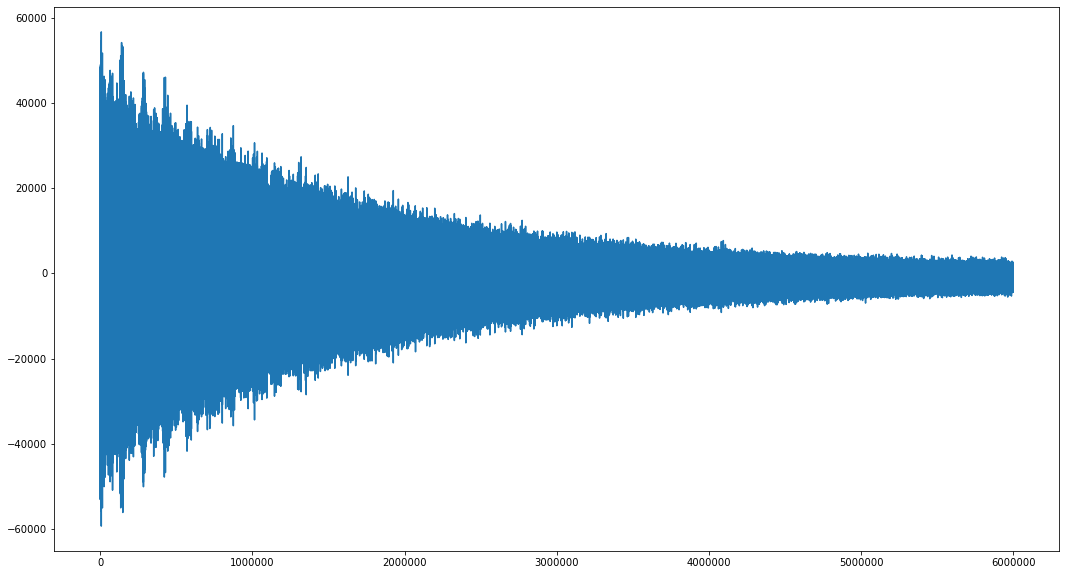

In [18]:
fig=plt.plot(trans[1000:6131000])

## Save LC-MS Spectra

In [85]:
for i in range(5):
    trans=LoadAvgTrans(lcmf_mono_pept,lcmsms_mono_pept,NumbersOI[i][0])
    MSpec = TransSpectrum(trans)
    MSpec.A = 2.117721546870e+14
    MSpec.SaveTransient(NumbersOI[i][4]+"_mono_pept.csv")
    trans=LoadAvgTrans(lcmf_std_pept,lcmsms_std_pept,NumbersOI[i][1])
    MSpec = TransSpectrum(trans)
    MSpec.A = 2.117721546870e+14
    MSpec.SaveTransient(NumbersOI[i][4]+"_std_pept.csv")
    trans=LoadAvgTrans(lcmf_std_prot,lcmsms_std_prot,NumbersOI[i][2])
    MSpec = TransSpectrum(trans)
    MSpec.A = 2.117721546870e+14
    MSpec.SaveTransient(NumbersOI[i][4]+"_std_prot.csv")
    

# Transient spectrum class 

## Init and clean up

In [19]:
class TransSpectrum:
    def __init__(self, TransData, name="Spectrum", build=True):
        self.trans = TransData
        self.name = name
        self.QuantFreq=3906250.0
        self.__A=2.11763959697e+14
        self.InitDeps()
        if build :
            self.MakeSpectrum()
            self.HalfSpecs()
            
    #Charnge calibration constant
    @property 
    def A(self):
        return self.__A
    
    @A.setter
    def A(self,A):
        self.__A=A
        self.InitDeps()
        self.MakeSpectrum()
        self.HalfSpecs()
        
    #initialize dependent arrays and variables
    def InitDeps(self):
        #Length of transient
        self.TrLen = len(self.trans)
        #Apodization arrays 
        #For full spectrum 
        self.KaiserArray=np.kaiser(self.TrLen,np.pi*3)
        #For half spectrum 
        self.KaiArray2=np.kaiser(self.TrLen//2,np.pi*3) #may migrate to half arrays
        #calibration array
        cscale=np.arange(self.TrLen)
        cscale[0]=1 #to avoid division by zero
        self.calib=self.A/np.square(cscale/(self.TrLen/self.QuantFreq))
        self.spaceX=np.linspace(800500.,3999500.,3200)
        
    def declb(self, mass):
        return (np.sqrt(self.A)*self.TrLen)/(np.sqrt(mass)*self.QuantFreq)

## Make spectrum

In [20]:
%%add_to TransSpectrum
def MakeSpectrum(self):
    self.SpecKai=fft(self.trans*self.KaiserArray)
    self.MagnKai=np.sqrt(self.SpecKai.real*self.SpecKai.real+self.SpecKai.imag*self.SpecKai.imag)

In [21]:
%%add_to TransSpectrum
def HalfSpecs(self):
    tr1=self.trans[:len(self.trans)//2]*self.KaiArray2
    tr2=self.trans[len(self.trans)//2:]*self.KaiArray2
    sp1=fft(tr1)
    sp2=fft(tr2)
    self.m1=np.sqrt(sp1.real*sp1.real+sp1.imag*sp1.imag)
    self.m2=np.sqrt(sp2.real*sp2.real+sp2.imag*sp2.imag)

In [22]:
%%add_to TransSpectrum
def SaveTransient(self, FileName):
    tfile=open(FileName,"w")
    tfile.write("{}\n".format(self.A))
    tfile.write("{}\n".format(self.QuantFreq))
    np.savetxt(tfile,self.trans,fmt="%f")
    tfile.close()

## Display Spectra

In [23]:
%%add_to TransSpectrum
def plotmasskai(self, minMass,maxMass,*args,PlotTo=None,labels=[],fname=None):
    if PlotTo is None:
        fig, ax = plt.subplots()
    else:
        ax = PlotTo
    #ax.get_xaxis().get_major_formatter().set_useOffset(False)
    #ax.get_yaxis().get_major_formatter().set_useOffset(False)
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3f'))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1e'))
    ax.locator_params(axis='x',nbins=6)
    ax.set_xlabel("m/z")
    ax.set_ylabel("Abundance, orb. units")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)        
    ax.plot(self.calib[int(np.round(self.declb(maxMass))):int(np.round(self.declb(minMass)))+1],
            self.MagnKai[int(np.round(self.declb(maxMass))):int(np.round(self.declb(minMass)))+1],*args)
    #ax.plot(calib[int(np.round(declb(maxMass))):int(np.round(declb(minMass)))+1],
    #        MagnKai_std[int(np.round(declb(maxMass))):int(np.round(declb(minMass)))+1],*args)
    if len(labels)>0 :
        for mz,n in labels:
            if type(n)==float:
                ax.annotate("{:.2f}".format(n),(mz,self.MagnKai[int(np.round(self.declb(mz)))]),textcoords="offset points",xytext=(0,10),ha='center' )
            else:    
                ax.annotate(n,(mz,self.MagnKai[int(np.round(self.declb(mz)))]),textcoords="offset points",xytext=(0,10),ha='center' )
    if fname is not None:
        plt.savefig(fname)
    if PlotTo is None:
        plt.show()
        return plt
    else:
        return PlotTo

## Process Spectrum

In [24]:
%%add_to TransSpectrum
def spratio(self,center,points):
    centerf=int(np.round(((np.sqrt(self.A)*len(self.m1))/(np.sqrt(center)*self.QuantFreq))))
    minsp=centerf-points
    maxsp=centerf+points
    s1sum=np.sum(self.m1[minsp:maxsp+1])
    s2sum=np.sum(self.m2[minsp:maxsp+1])
    return s1sum/s2sum               

## Processing Functions

### Spectra and peaks

In [25]:
%%add_to TransSpectrum
def PeakPick(self,minMass,maxMass,sn=1.):
    self.peaks = None
    pp=PeakPickerHiRes()
    par=pp.getParameters()
    par.setValue('report_FWHM','true')
    par.setValue('signal_to_noise',sn)
    pp.setParameters(par)
    spectrum=MSSpectrum()
    spectrum.set_peaks([np.flip(self.calib[int(self.declb(maxMass)):int(self.declb(minMass))]),
                        np.flip(self.MagnKai[int(self.declb(maxMass)):int(self.declb(minMass))])])
    picked=MSSpectrum()
    pp.pick(spectrum, picked)
    #FWHM in ppms
    fda=picked.getFloatDataArrays()
    #mzs, intensities
    ppmz,ppints = picked.get_peaks()
    self.peaks=pd.DataFrame({"m/z":ppmz,"Intensity":ppints,"resolution":1000000./fda[0].get_data()})
    #return self.peaks

### Hardklor and products

In [26]:
class FullSpectrum(TransSpectrum):
    def RunHardKlor(self, **kwargs):
        hkconf=ConfigObj("hardklor_dump.conf")
        for key, value in kwargs.items():
            hkconf[key]=value
        newhkconf=open("hardklor.conf","wb") 
        hkconf.write(newhkconf)
        newhkconf.write("temp.mzXML temp.hk".encode("ascii"))
        newhkconf.close()
        spectrum=MSSpectrum()
        spectrum.set_peaks([np.array(self.peaks["m/z"]),np.array(self.peaks["Intensity"])])
        spectrum.setMSLevel(1)
        spectrum.setRT(1.0)
        spectrum.setName("1")
        spectrum.setType(2)
        spectrum.updateRanges()
        exp=MSExperiment()
        exp.addSpectrum(spectrum)
        mzFile=MzXMLFile()
        Options=mzFile.getOptions()
        Options.setForceMQCompatability(True)
        mzFile.setOptions(Options)
        mzFile.store("temp.mzXML",exp)
        subprocess.run(["hardklor.exe","hardklor.conf"])
        self.Clusters=pd.read_csv("temp.hk",sep="\t",skiprows=1,names=["Mass","Charge","Abundance","Base Peak","Interval","Correlation"],
                        usecols=[1,2,3,4,5,8])
        #return self.Clusters
    

In [27]:
def IonProducts(Clusters, sequence=None, ppm=10,Shift=0):
    Clusters["Ions"]=""
    Clusters["PPMError"]=0.
    Clusters["Shift"]=0
    Clusters["TheorMass"]=0.
    if isinstance(sequence,str):
        sequence=AASequence.fromString(sequence)
    ProductLabels=["a","b","c","x","y","z"]
    coverSet=[[]]*(sequence.size()-1)
    for i in range(1,sequence.size()-1):
        bpart=sequence.getPrefix(i)
        ypart=sequence.getSuffix(i)
        amass=bpart.getMonoWeight(Residue.ResidueType.AIon,0)
        bmass=bpart.getMonoWeight(Residue.ResidueType.BIon,0)
        cmass=bpart.getMonoWeight(Residue.ResidueType.CIon,0)
        xmass=ypart.getMonoWeight(Residue.ResidueType.XIon,0)
        ymass=ypart.getMonoWeight(Residue.ResidueType.YIon,0)
        zmass=ypart.getMonoWeight(Residue.ResidueType.ZIon,0)
        products=[amass,bmass,cmass,xmass,ymass,zmass]
        for label,product in zip(ProductLabels,products):
            for Sh in range(-Shift,Shift+1):
                Target=Clusters[Clusters["Mass"].between(product+Sh*1.003355-(product*ppm/1000000),product+Sh*1.003355+(product*ppm/1000000))]
                for row in Target.iterrows():
                    Clusters.at[row[0],"Ions"]="{}{}".format(label,i)
                    Clusters.at[row[0],"PPMError"]=(Clusters.at[row[0],"Mass"]-product-Sh*1.003355)*1000000./product
                    Clusters.at[row[0],"Shift"]=Sh
                    Clusters.at[row[0],"TheorMass"]=product
                    if label<"d":
                        #print("{}{} {}+".format(label,i,Clusters.at[row[0],"Charge"]))
                        coverSet[i]=coverSet[i]+["{}{} {}+".format(label,i,Clusters.at[row[0],"Charge"])]
                    else:
                        coverSet[sequence.size()-i]=coverSet[sequence.size()-i]+["{}{} {}+".format(label,i,Clusters.at[row[0],"Charge"])]
    counter=0
    for i in range(sequence.size()-1):
        if len(coverSet[i])>0 :
            counter += 1
    cover=counter/(sequence.size()-1)
    return Clusters,coverSet,cover

In [28]:
%%add_to FullSpectrum
def Products(self, sequence=None, ppm=10,Shift=0):
    if sequence is None :
        sequence = self.sequence
    self.sequence = sequence
    self.Clusters,coverSet,cover = IonProducts(self.Clusters,self.sequence,ppm,Shift)
    return self.Clusters,coverSet,cover
    

### Filtering and joining

In [29]:
%%add_to TransSpectrum
def CheckIssues(self):
    self.peaks["issues"]=False
    for i in range(len(self.peaks)):
        mz=self.peaks.loc[i]["m/z"]
        margin=self.calib[int(self.declb(mz))]-self.calib[int(self.declb(mz))+5]
        diff=0
        for j in range(i-1,0,-1):
            diff=self.peaks.loc[i]["m/z"]-self.peaks.loc[j]["m/z"]
            if diff>margin :
                break
            if self.peaks.loc[i]["Intensity"]/self.peaks.loc[j]["Intensity"]<5.0 :
                margin=diff/2.0
                self.peaks.at[i,'issues']=True
        for j in range(i+1,len(self.peaks)):
            diff=self.peaks.loc[j]["m/z"]-self.peaks.loc[i]["m/z"]
            if diff>margin :
                break
            if self.peaks.loc[i]["Intensity"]/self.peaks.loc[j]["Intensity"]<5.0 :
                margin=diff/2.0
                self.peaks.at[i,'issues']=True
    return self.peaks
    #peaks.at[i,'left']=peaks.loc[i]['m/z']-margin        
    #peaks.at[i,'right']=peaks.loc[i]['m/z']+margin            

In [30]:
%%add_to FullSpectrum
def PeakstoClusters(self):
    links = 0
    counter=0
    for row in self.Clusters.iterrows():
        #10 ppm acceptable error
        ppms=row[1]["Base Peak"]/100000
        #take peaks in 5 Da interval from MonoMZ (plus errors)
        IntervPair=row[1].Interval.split('-')
        localpeak=self.peaks[(self.peaks['m/z']>float(IntervPair[0])-ppms) & (self.peaks['m/z']<float(IntervPair[1])+ppms)]
        #Mass difference to monoisotopic mass (not m/z!)
        localpeak["rest"]=(localpeak['m/z']-Proton)*row[1].Charge-row[1].Mass
        #Isotope number
        localpeak["Number"]=np.round(localpeak["rest"]/C13_Shift).astype(int)
        #Mass shift from nearest isotope
        localpeak.loc[:,["rest"]]=localpeak["rest"]-np.round(localpeak["rest"])*C13_Shift
        #Only peaks in acceptible error range from nearest Isotope allowed
        localpeak=localpeak[np.abs(localpeak['rest'])<ppms*row[1].Charge]
        #try to select consequent peaks
        toGet=[]
        #looking for consequtive peaks where most intense for isotope the same as most accurate 
        #high mass clusters (mass>20000) could be lost of low intensity first peaks
        #processed from maximum peak back and forth - stops when intensity is growing 
        #most abundant isotope number 
        start=int((row[1]["Base Peak"]-Proton)*row[1]["Charge"]-row[1]["Mass"])
        #print(start)
        LastInt=1.e20
        #print(localpeak)
        for i in range(start,-1,-1):
            lp=localpeak[localpeak["Number"]==i]
            #if isotope is not found
            if len(lp) == 0 :
                break
            IntMax=lp["Intensity"].idxmax()
            RestMin=np.abs(lp["rest"]).idxmin()
            #if most accurate peak is not most intense
            if IntMax!=RestMin:
                break
            #if next peak is more abundant 
            if lp.loc[IntMax]["Intensity"]>1.3*LastInt:
                break
            LastInt=lp.loc[IntMax]["Intensity"]
            toGet.insert(0,IntMax)
        LastInt=1.e20
        for i in range(start,20):
            lp=localpeak[localpeak["Number"]==i]
            #if isotope is not found
            if len(lp) == 0 :
                break
            IntMax=lp["Intensity"].idxmax()
            RestMin=np.abs(lp["rest"]).idxmin()
            #if most accurate peak is not most intense
            if IntMax!=RestMin:
                break
            #if next peak is more abundant 
            if lp.loc[IntMax]["Intensity"]>1.3*LastInt:
                #print(lp.loc[IntMax]["Intensity"],LastInt)
                break
            LastInt=lp.loc[IntMax]["Intensity"]
            toGet.append(IntMax)
        toGet=list(set(toGet))
        toGet.sort()
        #print(toGet)
        if toGet is None :
            continue
        localpeak=localpeak.loc[toGet]
        link=pd.DataFrame({"cluster" :np.full(len(localpeak),row[0]),
                           "peak" : localpeak.index,
                           "number" : localpeak["Number"],
                           "rest" : localpeak["rest"],
                           "intensity" : localpeak["Intensity"]})
        #print(link)
        if isinstance(links,int) :
            links = link
        else:
            links=links.append(link)
        counter+=1
        #if counter>10:
            #break
    #print(links)
    self.links = links
    peaksref=self.peaks.join(self.links.set_index('peak'),how='inner')
    self.RPeaks=peaksref.join(self.Clusters,how='inner',on='cluster',lsuffix='_peak')    
    #return links

In [31]:
%%add_to FullSpectrum
def UsualProcessing(self):
    self.PeakPick(250,2500)
    self.CheckIssues()
    self.RunHardKlor(charge_min=1,charge_max=30)
    self.PeakstoClusters()

### Reverse FFT

In [32]:
%%add_to TransSpectrum
def taucalckai(self,minmass,maxmass,Print=False,Plot=None):
    arr=np.zeros(self.TrLen,dtype=np.complex)
    arr[int(np.round(self.declb(maxmass))):int(np.round(self.declb(minmass)))+1]=self.SpecKai[int(np.round(self.declb(maxmass))):int(np.round(self.declb(minmass)))+1]
    arr[int(np.round(-self.declb(minmass))):-int(np.round(self.declb(maxmass)))+1]=self.SpecKai[int(np.round(-self.declb(minmass))):int(np.round(-self.declb(maxmass)))+1]
    recsig=np.abs(ifft(arr)/self.KaiserArray)
    env=[np.average(recsig[int(i)-500:int(i+500)].real) for i in self.spaceX]
    s = stats.linregress(self.spaceX/self.QuantFreq,np.log(env))   
    if Print :
        if Plot is None:
            fig, ax = plt.subplots()
            ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1e'))
            ax.plot(self.spaceX/self.QuantFreq,env,label="signal envelope")#np.log(env))
            ax.plot(self.spaceX/self.QuantFreq,np.exp(s[0]*(self.spaceX/self.QuantFreq)+s[1]),label="exponent fit")
            ax.legend()
            plt.show()
        else:
            Plot.plot(self.spaceX/self.QuantFreq,np.log(env))
            Plot.plot(self.spaceX/self.QuantFreq,(self.spaceX/self.QuantFreq)*s[0]+s[1])
    return s

In [33]:
def FWHMCalc(Peaks):
    Peaks["FWHM"]=Peaks["m/z"]/Peaks["resolution"]
    Peaks["FWHM Coeff"]=np.power(Peaks["FWHM"],0.6666)/(Peaks["m/z"]*3.e-5)    
    return Peaks

In [34]:
%%add_to TransSpectrum
def SRCalc(self,Peaks=pd.DataFrame()):
    if Peaks.empty :
        Peaks = self.RPeaks
    Peaks["Slope"]=0.
    Peaks["Intercept"]=0.    
    Peaks["RSquare"]=0.
    Peaks["Ratio"]=0.0
    Peaks = FWHMCalc(Peaks)
    
    Peaks.reset_index(drop=True,inplace=True)
    
    for i in range(len(Peaks)):
        #s=taucalckai(RPeaks.iloc[i]['left'],RPeaks.iloc[i]['right'])
        center=int(np.round(self.declb(Peaks.iloc[i]["m/z"])))
        #print(center,calib[center])
        s=self.taucalckai(self.calib[center+5],self.calib[center-5])
        Peaks.at[i,"Slope"]=s[0]
        Peaks.at[i,"Intercept"]=s[1]    
        Peaks.at[i,"RSquare"]=s[2]
        Peaks.at[i,"Ratio"]=self.spratio(Peaks.iloc[i]['m/z'],5)
        print(i,s)
    return Peaks

### Show resolution

In [35]:
colors=["black","red","orange","xkcd:dandelion","lime","lightseagreen","dodgerblue","blue","purple",\
        "black","red","orange","xkcd:dandelion","lime","lightseagreen","dodgerblue","blue","purple",\
        "black","red","orange","xkcd:dandelion","lime","lightseagreen","dodgerblue","blue","purple",\
        "black","red","orange","xkcd:dandelion","lime","lightseagreen","dodgerblue","blue","purple",\
        "black","red","orange","xkcd:dandelion","lime","lightseagreen","dodgerblue","blue","purple"]

In [36]:
def ShowRes(Values,Charges,xlabel = "Predicted Charge",GaussianHeght=3,MinCharge=0,MaxCharge=0,fname=""):
    SigmaSum=0
    Counter=0
    if (MinCharge == 0):
        MinCharge = int(np.min(Charges))
    if (MaxCharge == 0):
        MaxCharge = int(np.max(Charges))
    MinValue = int(np.min(Values))
    MaxValue = np.max(Values)
    x = np.linspace(MinValue-(MaxValue-MinValue)/5.,MaxValue+(MaxValue-MinValue)/5.,200)
    for i in range(MinCharge,MaxCharge+1):
        Slopes=Values[Charges==i]
        if len(Slopes)==1 :
            print(i)
        if (len(Slopes)>=2):
            Params=stats.norm.fit(Slopes)
            print(i,len(Slopes),Params)
            SigmaSum=SigmaSum+Params[1]
            Counter+=1
            fitted = stats.norm.pdf(x,loc = Params[0],scale = Params[1])
            fitted=(fitted/np.max(fitted))*GaussianHeght
            plt.plot(x,fitted,colors[i],label="Charge "+str(i)+" fit")
        plt.hist(Slopes,x,facecolor=colors[i],alpha=0.5)
    plt.legend()
    plt.xlabel(xlabel)
    if (fname!=""):
        plt.savefig(fname)
    SigmaAve=SigmaSum/Counter
    FWHM=SigmaAve*2.355
    Res=MaxCharge/FWHM
    #Res=(MaxValue-MinValue)/FWHM
    print(Res)

### Regression

In [37]:
class Regression:
    def __init__(self,FRes,NoMZ=False,FWHM=False,Slope=True):
        self.NoMZ=NoMZ
        self.FWHM=FWHM
        self.Slope=Slope 
        self.X=self.FeatureExtraction(FRes)
        self.Fit(self.X,FRes["Charge"])
        
    def FeatureExtraction(self,FRes):
        X=pd.DataFrame()
        if self.Slope:
            X["Slope"]=FRes["Slope"]
            X["SlopelogIntens"]=FRes["Slope"]*np.log(FRes["Intensity"])
        X["LogRatio"]=np.log(FRes["Ratio"])
        X["RatiologIntens"]=np.log(FRes["Ratio"])*np.log(FRes["Intensity"])
        if (not self.NoMZ):
            if self.Slope:
                X["SlopeMZ"]=FRes["Slope"]*FRes["m/z"]
            X["LogRatioMZ"]=np.log(FRes["Ratio"])*FRes["m/z"]
        if self.FWHM:
            X["FWHM"] = FRes["FWHM Coeff"]
        return X
    
    def Fit(self,X,Y):
        return
    
    def Apply(self,FRes):
        return
    

In [38]:
class LinearReg(Regression):
    
    def Fit(self,X,Y):
        self.regr=linear_model.LinearRegression()
        self.regr.fit(X,Y)

    def Apply(self,FRes):
        X=self.FeatureExtraction(FRes)
        Y_pred=self.regr.predict(X)
        return Y_pred        

In [39]:
def weighted_avg_and_std(values, weights):
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return average, np.sqrt(variance)

In [40]:
class LogisticReg(Regression):
    
    def __init__(self,FRes,NoMZ=False,FWHM=False,Slope=True,ClassThres=3):
        self.ClassThres = ClassThres
        Classes=np.sort(FRes["Charge"].unique())
        Enough=[ np.count_nonzero(FRes["Charge"]==n) >= ClassThres for n in Classes]
        self.Classes = Classes[Enough]
        FRes=FRes[np.isin(FRes["Charge"],self.Classes)]
        super().__init__(FRes,NoMZ,FWHM,Slope)
        
    def Fit(self,X,Y):
        self.scaler=StandardScaler()
        X_scaled=self.scaler.fit_transform(X)
        self.lr=LogisticRegression(solver="newton-cg" ,max_iter=100000, penalty="none")
        self.lr.fit(X_scaled,Y)
        
    def Apply(self,FRes):
        X=self.FeatureExtraction(FRes)
        X_scaled=self.scaler.transform(X)
        Y_distr=self.lr.predict_proba(X_scaled)
        Y=np.dot(Y_distr,self.Classes)
        return Y,Y_distr        
    
    def Estimate(self,FRes):
        Y,Y_distr=self.Apply(FRes)
        FRes["Aver"]=0.0
        FRes["Sigma"]=0.0
        for i in range(len(Y_distr)):
            FRes["Aver"].iat[i],FRes["Sigma"].iat[i]=weighted_avg_and_std(self.Classes,Y_distr[i])                
        return FRes

In [41]:
class MassLogisticReg(LogisticReg):
    
    MassDistr=pd.read_csv("StatBar.csv",sep="\t")
    
    def Apply(self,FRes):
        Y,Y_distr=super().Apply(FRes)
        Y_mass_decay=np.copy(Y_distr)
        for i in range(len(Y_distr)):
            Y_mass_decay[i]=MassLogisticReg.MassDistr["0.2"][((FRes.loc[i]["m/z"]-1.007276467)*self.Classes*100).astype(int)]*Y_distr[i]
            Y_mass_decay[i]=Y_mass_decay[i]/np.sum(Y_mass_decay[i])
        Y=np.dot(Y_mass_decay,self.Classes)
        return Y,Y_mass_decay        

### Spectra visualization

In [42]:
%%add_to TransSpectrum
def RainbowSpectrum(self,minMass,maxMass,FPeaks,minCharge=1,maxCharge=8,
                    Name="Spectrum",LabelThres=0.15,ColorThres=0.02,svg=False):
#Peaks is a Dataframe and should have columns "Intensity","m/z","Aver","Sigma"

    plt.rcParams["figure.figsize"] = (18,6)
    plt.rcParams.update({'font.size': 14})

    #build a curve to show
    highest=np.max(self.MagnKai[int(np.round(self.declb(maxMass))):int(np.round(self.declb(minMass)))+1])
    yvalues=100.*(self.MagnKai[int(np.round(self.declb(maxMass))):int(np.round(self.declb(minMass)))+1]/highest)
    xvalues=self.calib[int(np.round(self.declb(maxMass))):int(np.round(self.declb(minMass)))+1]
    xvalues=xvalues[::-1]
    yvalues=yvalues[::-1]
    
    #select peaks to color
    Peaks=FPeaks[(FPeaks["m/z"]>minMass) & (FPeaks["m/z"]<maxMass)]
    highestPeak=np.max(Peaks["Intensity"])
    PeakstoShow=Peaks[Peaks["Intensity"]>highestPeak*LabelThres] [["m/z","Aver","Sigma"]]
    PeakstoShow["Label"]=""
    for row in PeakstoShow.iterrows():
        PeakstoShow["Label"].at[row[0]]=u'{:.1f}\xB1{:.1f}'.format(row[1]["Aver"],row[1]["Sigma"])#*2.0)
    PeakstoShow=PeakstoShow.drop(columns=["Aver","Sigma"])
    labels=[tuple(x[1]) for x in PeakstoShow.iterrows()]
    #first color more intensive peaks 
    Peaks=Peaks.sort_values("Intensity")
    charges=np.array(Peaks[Peaks["Intensity"]>highestPeak*ColorThres]["Aver"])
    mzs=np.array(Peaks[Peaks["Intensity"]>highestPeak*ColorThres]["m/z"])

    #peaks will be colored from maximum to closest minimal local extremum - here we select extrema
    mins=ss.argrelmin(yvalues)
    minmzs=xvalues[mins]

    #Array for colors - by default color is gray
    colorD=np.zeros(len(xvalues))
    colorD[:]=maxCharge*1.2 ##!!Default color MaxCharge+const???

    #here we apply the colors
    for i in range(len(mzs)):
        index = minmzs.searchsorted(mzs[i])
        if index>0 and index<len(minmzs)-1: 
            colorD[mins[0][index-1]:mins[0][index]]=maxCharge-charges[i]


    #Build the curve
    points = np.array([xvalues, yvalues]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    vmin=minCharge-((maxCharge-minCharge)/8)-1
    vmax=maxCharge+((maxCharge-minCharge)/8)-1
    print(vmin,vmax)
    norm = plt.Normalize(vmin, vmax)
    lc = LineCollection(segments, cmap='nipy_spectral', norm=norm)

    fig, axs = plt.subplots(1, 1)

    lc.set_array(colorD)
    lc.set_linewidth(2)
    line = axs.add_collection(lc)


    norm1 = matplotlib.colors.Normalize(vmin=minCharge, vmax = maxCharge)
    cmap = plt.get_cmap('nipy_spectral')
    #colors = cmap(np.linspace(1/1.1, 1-1/1.1, cmap.N))
    colors = cmap(np.linspace(0.9, 0.1, cmap.N))
    color_map = matplotlib.colors.LinearSegmentedColormap.from_list('cut_jet', colors)
    cax, _  = matplotlib.colorbar.make_axes(plt.gca())
    cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=color_map, norm=norm1)

    axs.get_xaxis().get_major_formatter().set_useOffset(False)
    axs.get_yaxis().get_major_formatter().set_useOffset(False)
    axs.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
    axs.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.f'))
    axs.locator_params(axis='x',nbins=6)
    axs.set_xlabel("m/z")
    axs.set_ylabel("Abundance, %")
    axs.spines["top"].set_visible(False)
    axs.spines["right"].set_visible(False)

    #for mz,n in labels:
    #    axs.annotate(n,(mz,100.*(MagnKai[int(np.round(declb(mz)))]/highest)),textcoords="offset points",xytext=(0,10),ha='center' )


    axs.set_xlim(minMass, maxMass)
    axs.set_ylim(0,100.)

    for mz,n in labels:
        axs.annotate(n,(mz,100.*(self.MagnKai[int(np.round(self.declb(mz)))]/highest)),textcoords="offset points",xytext=(0,10),ha='center' )

    if (svg):
        plt.savefig(Name+".svg")

    plt.show()

### Isotope modeling

In [43]:
def IsoSim(Formula, Charge, IsoNumber,tau):
    A=2.11762200881e+14
    QuantFreq=4000000.0
    TrLen=6000000
    Pr=1.007276466
    H=1.007825032    
    cscale=np.arange(TrLen)
    #cscale[0]=1 #to avoid division by zero
    #Get all isotopolues probabilies and convert them to DataFrame
    i = IsoSpecPy.IsoTotalProb(formula=Formula, prob_to_cover = 0.9999, get_confs=True)
    IsoDist=pd.DataFrame([[mass, prob] + list(sum(conf,())) for mass, prob, conf in i], 
                 columns=["Mass","Prob","C12","C13","H","D","N14","N15","O16","O17","O18","S32","S33","S34","S36"])
    #calc isotopу peak number for each isotopologue
    IsoDist["IsoLog"]=IsoDist.C13+IsoDist.D+IsoDist.N15+IsoDist.O17+IsoDist.O18*2+IsoDist.S33+IsoDist.S34*2+IsoDist.S36*4
    #calc m/z, frequences and intensities of FFT signal 
    IsoDist["m/z"]=(IsoDist.Mass+H)/Charge+Pr
    masses=list(IsoDist[IsoDist.IsoLog==IsoNumber]["m/z"])
    fr=[(np.sqrt(A)*TrLen)/(np.sqrt(mass)*QuantFreq) for mass in masses]
    ints=IsoDist[IsoDist.IsoLog==IsoNumber]["Prob"]
    #form oscillating signal and spectrum
    signal=np.zeros(TrLen)
    for f,i in zip(fr,ints):
        signal=signal+i*np.cos((f/TrLen)*cscale*2*np.pi)*np.exp(-(tau*cscale)/QuantFreq)#tau<->0.0
    return signal,IsoDist[IsoDist.IsoLog==IsoNumber]

## Pictures for Makarov

In [42]:
UbiSpec = FullSpectrum(np.loadtxt("D:\\FT Data\\Data Samples\\decay_ubi_cah\\2-ubiq_1e5_1-850_chB_r_transient_0-1500ms.csv",skiprows=2)[1000:5895500])

In [43]:
plt.rcParams["figure.figsize"] = (8,6)

In [44]:
Ubi1=FullSpectrum(UbiSpec.trans[0:UbiSpec.TrLen//2])
Ubi2=FullSpectrum(UbiSpec.trans[UbiSpec.TrLen//2:UbiSpec.TrLen])

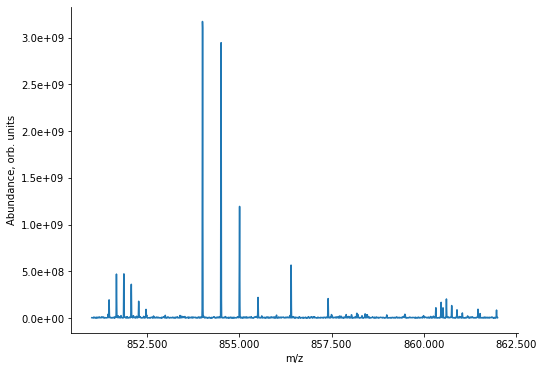

<module 'matplotlib.pyplot' from 'C:\\Users\\yaros\\Anaconda3\\envs\\tf2\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [45]:
Ubi2.plotmasskai(851,862)

In [46]:
UbiSpec.UsualProcessing()

C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [357]:
UbiSpec.RPeaks

m/z    Intensity     resolution  issues  cluster  number  \
2      251.103157  124614584.0  265670.000000   False        0       0   
4      252.106513   21895298.0  235320.437500   False        0       1   
7      254.150400  261859760.0  270147.468750   False        1       0   
10     255.153733   24931498.0  245100.875000   False        1       1   
8      254.267168   45433892.0  284589.375000   False        2       0   
...           ...          ...            ...     ...      ...     ...   
9764  1970.046151   44109060.0  104590.937500   False     1450       3   
9767  2033.125965  109803184.0   97172.039062   False     1451       0   
9768  2034.129050  124205824.0   93161.679688   False     1451       1   
9769  2035.133194   57704492.0   96506.125000   False     1451       2   
9770  2036.135930   28643494.0   76353.210938   False     1451       3   

          rest    intensity       Mass  Charge  Abundance  Base Peak  \
2    -0.000020  124614584.0   250.0959       1  143484208   251.1031   
4    -0.000018   21895298.0   250.0959       1  143484208   251.1031   
7     0.000024  261859760.0   253.1431       1  301511584   254.1504   
10    0.000002   24931498.0   253.1431       1  301511584   254.1504   
8     0.000429   45433892.0  2026.0787       8  135375488   254.2672   
...        ...          ...        ...     ...        ...        ...   
9764 -0.000490   44109060.0  1966.0293       1  715954816  1968.0392   
9767 -0.000511  109803184.0  2032.1192       1  371240960  2034.1290   
9768 -0.000781  124205824.0  2032.1192       1  371240960  2034.1290   
9769  0.000008   57704492.0  2032.1192       1  371240960  2034.1290   
9770 -0.000611   28643494.0  2032.1192       1  371240960  2034.1290   

                 Interval  Correlation  
2       250.1783-254.1140       0.9993  
4       250.1783-254.1140       0.9993  
7       252.1348-257.1137       0.9992  
10      252.1348-257.1137       0.9992  
8       254.1504-255.1537       0.9046  
...                   ...          ...  
9764  1950.0248-2007.0538       0.9906  
9767  2008.0601-2078.0664       0.9933  
9768  2008.0601-2078.0664       0.9933  
9769  2008.0601-2078.0664       0.9933  
9770  2008.0601-2078.0664       0.9933  

[4679 rows x 14 columns]

In [358]:
UbiSpec.Products(sequence="MQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGG")

b2 1+
a3 1+
b3 1+
a4 1+
b4 1+
a5 1+
b5 1+
b6 1+
b7 1+
a8 2+
b8 2+
b8 1+
a9 2+
a9 1+
b9 2+
b9 1+
b10 1+
c10 2+
c10 1+
b11 2+
b11 1+
c11 1+
a12 2+
b12 2+
b12 1+
c12 1+
a13 2+
b13 2+
b13 1+
a14 3+
a14 2+
b14 3+
b14 2+
b14 1+
a15 3+
a15 2+
b15 3+
b15 2+
b15 1+
a16 3+
a16 2+
b16 3+
b16 2+
b16 1+
a17 3+
a17 2+
b17 3+
b17 2+
b17 1+
a18 2+
b18 3+
b18 2+
b18 1+
b20 2+
b22 2+
b34 4+
b36 4+
b36 3+
b58 7+
63


(           Mass  Charge  Abundance  Base Peak             Interval  \
 0      250.0959       1  143484208   251.1031    250.1783-254.1140   
 1      253.1431       1  301511584   254.1504    252.1348-257.1137   
 2     2026.0787       8  135375488   254.2672    254.1504-255.1537   
 3      256.1064       1  144120464   257.1137    255.2072-259.8823   
 4      256.1540       1  739812800   257.1613    255.2072-259.8823   
 ...         ...     ...        ...        ...                  ...   
 1447  1835.9445       1  751103168  1836.9521  1815.9714-1851.9764   
 1448  1868.9758       1  414009984  1869.9834  1851.9764-1902.0879   
 1449  1903.0764       1  194565376  1905.0862  1902.0879-1950.0248   
 1450  1966.0293       1  715954816  1968.0392  1950.0248-2007.0538   
 1451  2032.1192       1  371240960  2034.1290  2008.0601-2078.0664   
 
       Correlation Ions  PPMError  Shift    TheorMass  
 0          0.9993       0.000000      0     0.000000  
 1          0.9992       0.000000 

In [359]:
UbiSpec.PeakstoClusters()

C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [360]:
UbiSpec.RPeaks["Ratio"]=0.0
UbiSpec.RPeaks.reset_index(drop=True,inplace=True)
for i in range(len(UbiSpec.RPeaks)):
    center=int(np.round(UbiSpec.declb(UbiSpec.RPeaks.iloc[i]["m/z"])))
    UbiSpec.RPeaks.at[i,"Ratio"]=UbiSpec.spratio(UbiSpec.RPeaks.iloc[i]['m/z'],5)

In [361]:
ShPeaks=UbiSpec.RPeaks[(UbiSpec.RPeaks["m/z"]>851) & (UbiSpec.RPeaks["m/z"]<862) & (UbiSpec.RPeaks["Intensity"]>5.0e8)]

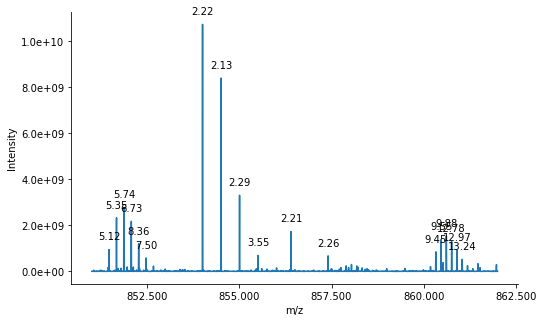

<module 'matplotlib.pyplot' from 'C:\\Users\\yaros\\Anaconda3\\envs\\tf2\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [362]:
UbiSpec.plotmasskai(851,862,labels=list(zip(list(ShPeaks["m/z"]),list(ShPeaks["Ratio"]))))#,fname="RatioMarks.svg")

In [363]:
IPeak=UbiSpec.RPeaks[(UbiSpec.RPeaks["Ions"]!="")]#&(UbiSpec.RPeaks["number"]==0)]

In [364]:
IPeak=IPeak[~IPeak["issues"]]

In [365]:
IPeak=IPeak[IPeak.Intensity>1.1e08]

In [366]:
IPeak

m/z     Intensity     resolution  issues  cluster  number  \
12     260.106794  3.543115e+10  277479.281250   False        6       0   
13     261.110134  3.824197e+09  276102.562500   False        6       1   
65     340.885709  6.462155e+08  241751.890625   False       32       0   
66     341.220173  3.007581e+08  244030.640625   False       32       1   
75     345.195506  2.287596e+08  238113.625000   False       36       0   
...           ...           ...            ...     ...      ...     ...   
4560  1562.890994  2.606830e+08  104976.945312   False     1412       0   
4561  1563.895281  2.101982e+08  108772.054688   False     1412       1   
4632  1675.974606  1.493312e+08  107544.820312   False     1437       0   
4633  1676.978179  1.271566e+08  105272.281250   False     1437       1   
4676  2034.129050  1.242058e+08   93161.679688   False     1451       1   

          rest     intensity       Mass  Charge    Abundance  Base Peak  \
12    0.000018  3.543115e+10   259.0995       1  41225809920   260.1068   
13    0.000002  3.824197e+09   259.0995       1  41225809920   260.1068   
65    0.000098  6.462155e+08  1019.6352       3   1148821760   340.8857   
66    0.000135  3.007581e+08  1019.6352       3   1148821760   340.8857   
75    0.000029  2.287596e+08   344.1882       1    277136864   345.1955   
...        ...           ...        ...     ...          ...        ...   
4560  0.000318  2.606830e+08  1561.8834       1    664800384  1562.8910   
4561  0.001250  2.101982e+08  1561.8834       1    664800384  1562.8910   
4632  0.000329  1.493312e+08  1674.9670       1    409614048  1675.9746   
4633  0.000548  1.271566e+08  1674.9670       1    409614048  1675.9746   
4676 -0.000781  1.242058e+08  2032.1192       1    371240960  2034.1290   

                 Interval  Correlation Ions  PPMError  Shift    TheorMass  \
12      259.8823-263.1059       0.9993   b2  1.685563      0   259.099063   
13      259.8823-263.1059       0.9993   b2  1.685563      0   259.099063   
65      340.1503-342.2024       0.9954   y9 -0.034899      0  1019.635236   
66      340.1503-342.2024       0.9954   y9 -0.034899      0  1019.635236   
75      344.2373-348.1384       0.9987   a3 -0.036675      0   344.188213   
...                   ...          ...  ...       ...    ...          ...   
4560  1561.9160-1568.3376       0.9957  b14 -4.348996      0  1561.890193   
4561  1561.9160-1568.3376       0.9957  b14 -4.348996      0  1561.890193   
4632  1674.9606-1689.9543       0.9933  b15 -4.332607      0  1674.974257   
4633  1674.9606-1689.9543       0.9933  b15 -4.332607      0  1674.974257   
4676  2008.0601-2078.0664       0.9933  b18 -4.261414      0  2032.127860   

         Ratio  
12    1.760613  
13    1.819431  
65    3.251067  
66    4.117533  
75    2.982739  
...        ...  
4560  2.347921  
4561  2.574061  
4632  2.143494  
4633  2.686987  
4676  4.289287  

[615 rows x 19 columns]

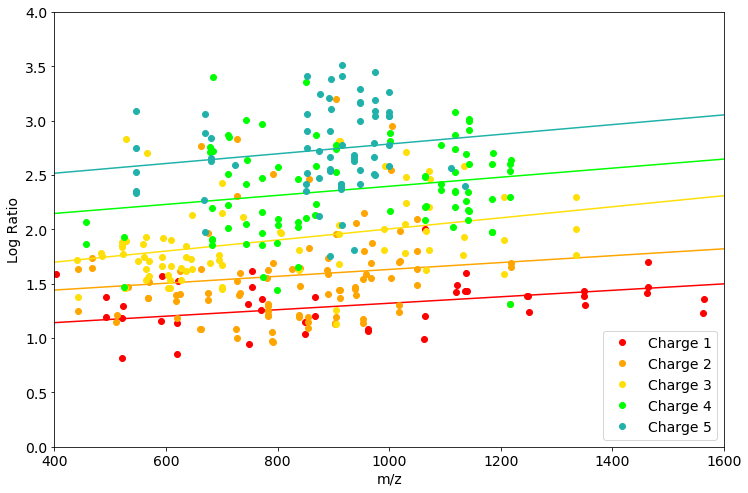

In [403]:
Counter=0
for i in range(1,6):
    Yscat=np.log2(IPeak["Ratio"][IPeak["Charge"]==i])
    Xscat=IPeak["m/z"][IPeak["Charge"]==i]
    plt.plot(Xscat,Yscat,"o",color=colors[i],label="Charge "+str(i))
    s=stats.linregress(Xscat,Yscat)
    lineX=np.linspace(400.,1600,20)
    lineY=lineX*s[0]+s[1]
    plt.plot(lineX,lineY,"-",color=colors[i])
    #for row in FRes[FRes["Charge"]==i].iterrows():
        #plt.annotate(str(row[1]["number"]),(row[1]["m/z"]+5,row[1]["Diff"]))

plt.legend()
plt.xlabel("m/z")
plt.ylabel("Log Ratio")
plt.xlim(400,1600)
plt.ylim(0,4)
plt.rcParams["figure.figsize"] = (12,8)
plt.show()

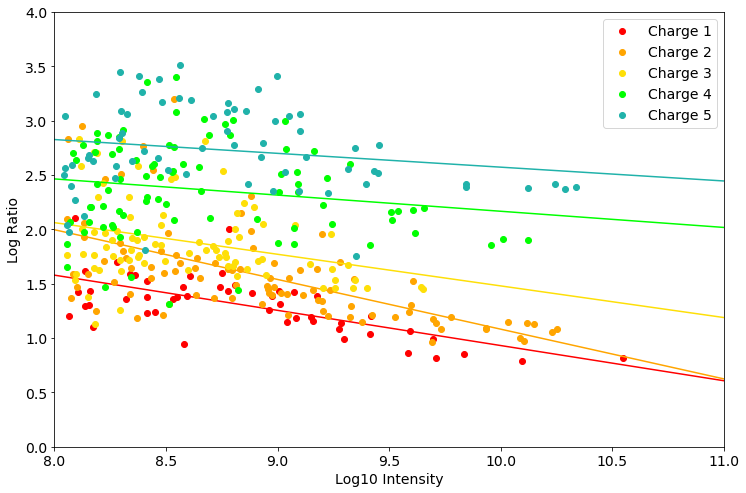

In [404]:
for i in range(1,6):
    Yscat=np.log2(IPeak["Ratio"][IPeak["Charge"]==i])
    Xscat=np.log10(IPeak["Intensity"][IPeak["Charge"]==i])
    plt.plot(Xscat,Yscat,"o",color=colors[i],label="Charge "+str(i))
    s=stats.linregress(Xscat,Yscat)
    lineX=np.linspace(8.,11,20)
    lineY=lineX*s[0]+s[1]
    plt.plot(lineX,lineY,"-",color=colors[i])
    #for row in FRes[FRes["Charge"]==i].iterrows():
        #plt.annotate(str(row[1]["number"]),(row[1]["m/z"]+5,row[1]["Diff"]))

plt.legend()
plt.xlabel("Log10 Intensity")
plt.ylabel("Log Ratio")
plt.xlim(8,11)
plt.ylim(0,4)
plt.rcParams["figure.figsize"] = (12,8)
plt.show()

1 50 (0.9031233517332482, 0.19009470715534388)
2 95 (1.0894445780363995, 0.3033209801108924)
3 83 (1.3075848818634488, 0.25414252823428735)
4 85 (1.6390413151827197, 0.2948895368179754)
5 68 (1.891034400834172, 0.27474465401028403)
6 75 (2.1281221302137463, 0.28658146969450016)
7 101 (2.357140572800421, 0.29026264456895645)
8 41 (2.6151723719533537, 0.26503280107194715)
5.357947202648403


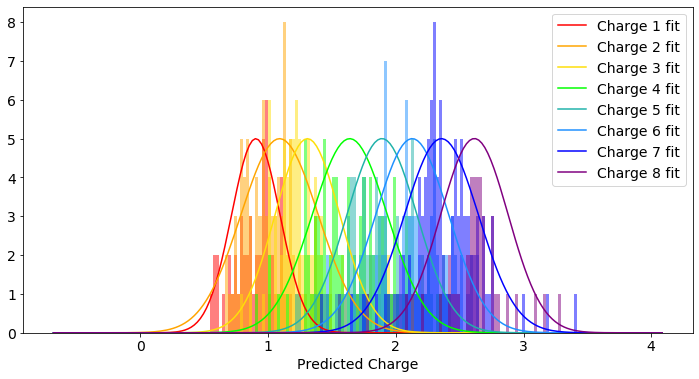

In [397]:
ShowRes(np.log(np.array(IPeak["Ratio"])),IPeak["Charge"],MaxCharge=8,GaussianHeght=5)

In [371]:
regr=LinearRegressionFit(IPeak)
Y_Pred=LinearRegressionApply(IPeak,regr)

1 50 (1.7827973318861439, 0.5072702683885738)
2 95 (2.499074149815105, 0.9099092926794492)
3 83 (3.186829706997077, 0.7427545335860034)
4 85 (4.098674800017223, 0.9045832423925306)
5 68 (4.989508598243318, 0.8394446279960851)
6 75 (5.699669865879398, 0.9225469072855024)
7 101 (6.481314138550957, 0.943456310668848)
8 41 (7.4992698104541615, 0.9100376182720652)
5.069327693360335


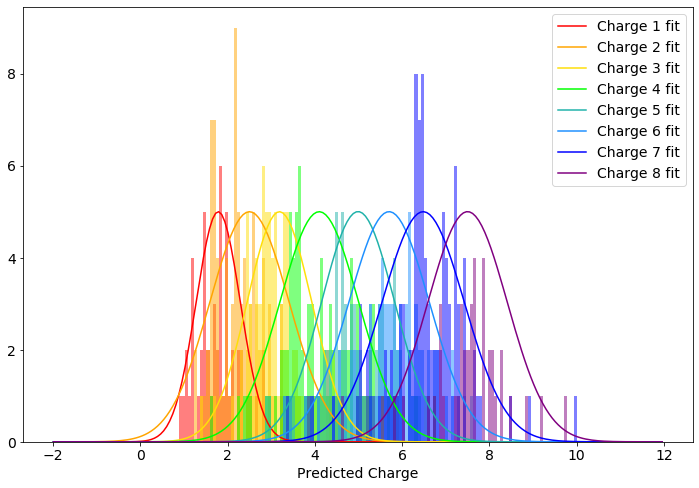

In [405]:
ShowRes(Y_Pred,IPeak["Charge"],MaxCharge=8,GaussianHeght=5)

In [373]:
lr,scaler,Classes=LogisticRegressionFit(IPeak)
Y,Y_Distr=LogisticRegressionApply(IPeak,lr,scaler,Classes)

[1 2 3 4 5 6 7 8 9]


In [407]:
plt.rcParams["figure.figsize"] = (12,6)

1 50 (1.7192875244565622, 0.4667199439803371)
2 95 (2.4808411679458877, 0.8964841728377309)
3 83 (3.082359747430302, 0.8633162685002022)
4 85 (4.149513980744447, 1.02223097940232)
5 68 (5.109744227170229, 0.9761958320565903)
6 75 (5.821809465462691, 0.9719817115680935)
7 101 (6.46494403536572, 0.8393646544734961)
8 41 (7.410394188944257, 0.6891162802936943)
3.9573174836582607


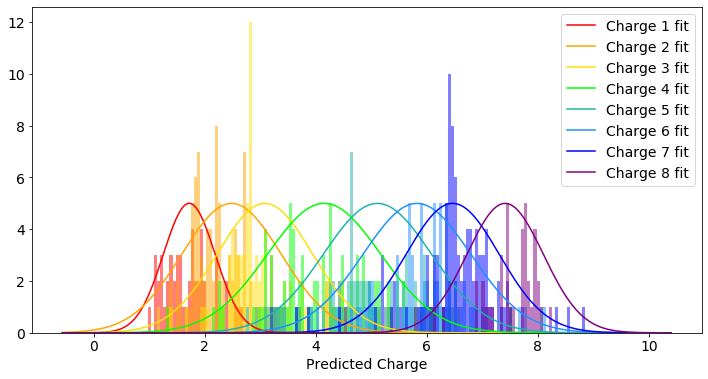

In [408]:
ShowRes(Y,IPeak["Charge"],MaxCharge=8,GaussianHeght=5)

In [375]:
MassDistr=pd.read_csv("StatBar.csv",sep="\t")

In [329]:
def weighted_avg_and_std(values, weights):
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return average, np.sqrt(variance)

In [376]:
IPeak.reset_index(inplace=True,drop=True)

In [378]:
Classes

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [379]:
Y_mass_decay=np.copy(Y_Distr)
for i in range(len(Y_Distr)):
    Y_mass_decay[i]=MassDistr["0.2"][((IPeak.iloc[i]["m/z"]-1.007276467)*Classes*100).astype(int)]*Y_Distr[i]
    Y_mass_decay[i]=Y_mass_decay[i]/np.sum(Y_mass_decay[i])

In [380]:
Y_pred_mass=np.dot(Y_mass_decay,Classes)

In [381]:
Y_pred_mass

array([2.1100201 , 1.24977436, 3.0974942 , 3.034587  , 2.44672779,
       1.43131364, 1.4793813 , 2.20468358, 2.32896024, 2.37495891,
       2.52334374, 3.07719305, 1.35948501, 2.38620445, 2.77021238,
       4.73702001, 2.48326998, 2.21200997, 2.72690924, 3.101193  ,
       1.69774433, 2.0367518 , 2.02168352, 1.6968484 , 1.15286504,
       1.88130903, 1.64980167, 2.81192963, 3.24898209, 3.06972494,
       3.04820449, 4.40008565, 1.88676675, 3.22299165, 2.20023195,
       3.74243582, 6.51756223, 2.07737414, 5.38214638, 4.24471039,
       5.15165817, 6.55534705, 7.72891163, 3.21144705, 2.56727279,
       3.15435873, 3.08821408, 2.49856182, 3.35369114, 5.63648077,
       2.13604845, 2.30460108, 1.84245524, 2.12430768, 3.28072128,
       3.15702244, 1.61774213, 2.32303691, 3.11544468, 2.53358218,
       3.26543368, 3.04760724, 3.08153872, 2.17683213, 3.16986038,
       3.45007948, 2.53663325, 5.76983979, 5.86848469, 2.13412135,
       1.71083355, 2.08928959, 1.21742106, 1.64457493, 2.30150

1 50 (1.4660268813729576, 0.4221613279620396)
2 95 (2.3062989384988652, 0.997595797019867)
3 83 (3.2439549461978143, 0.781227803252082)
4 85 (4.120822243008846, 0.9556125362071469)
5 68 (5.138503779334535, 0.9858263946429204)
6 75 (5.8056900874267106, 1.01652214984721)
7 101 (6.530481168465655, 0.8525413104746196)
8 41 (7.5435211245294065, 0.7922739706939881)
3.9644069388121306


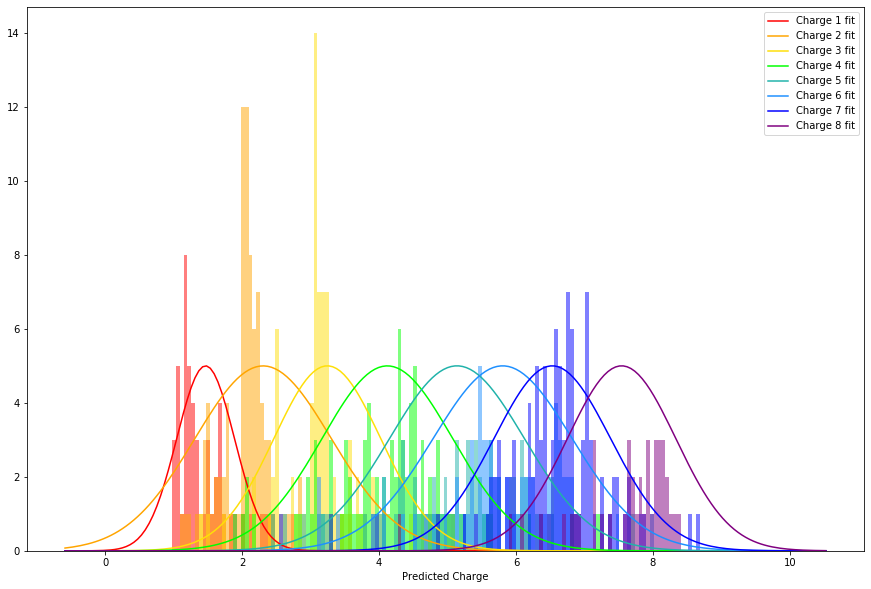

In [382]:
ShowRes(Y_pred_mass,IPeak["Charge"],MaxCharge=8,GaussianHeght=5)

In [383]:
YF,YF_Distr=LogisticRegressionApply(UbiSpec.RPeaks,lr,scaler,Classes)
UbiSpec.RPeaks["Max"]=0
UbiSpec.RPeaks["Aver"]=0.0
UbiSpec.RPeaks["Sigma"]=0.0
for i in range(len(YF)):
    #UbiSpec.RPeaks["Max"].iat[i]=Y_single[i]
    UbiSpec.RPeaks["Aver"].iat[i],UbiSpec.RPeaks["Sigma"].iat[i]=weighted_avg_and_std(Classes,YF_Distr[i])

In [384]:
UbiSpec.RPeaks

m/z    Intensity     resolution  issues  cluster  number  \
0      251.103157  124614584.0  265670.000000   False        0       0   
1      252.106513   21895298.0  235320.437500   False        0       1   
2      254.150400  261859760.0  270147.468750   False        1       0   
3      255.153733   24931498.0  245100.875000   False        1       1   
4      254.267168   45433892.0  284589.375000   False        2       0   
...           ...          ...            ...     ...      ...     ...   
4674  1970.046151   44109060.0  104590.937500   False     1450       3   
4675  2033.125965  109803184.0   97172.039062   False     1451       0   
4676  2034.129050  124205824.0   93161.679688   False     1451       1   
4677  2035.133194   57704492.0   96506.125000   False     1451       2   
4678  2036.135930   28643494.0   76353.210938   False     1451       3   

          rest    intensity       Mass  Charge  ...             Interval  \
0    -0.000020  124614584.0   250.0959       1  ...    250.1783-254.1140   
1    -0.000018   21895298.0   250.0959       1  ...    250.1783-254.1140   
2     0.000024  261859760.0   253.1431       1  ...    252.1348-257.1137   
3     0.000002   24931498.0   253.1431       1  ...    252.1348-257.1137   
4     0.000429   45433892.0  2026.0787       8  ...    254.1504-255.1537   
...        ...          ...        ...     ...  ...                  ...   
4674 -0.000490   44109060.0  1966.0293       1  ...  1950.0248-2007.0538   
4675 -0.000511  109803184.0  2032.1192       1  ...  2008.0601-2078.0664   
4676 -0.000781  124205824.0  2032.1192       1  ...  2008.0601-2078.0664   
4677  0.000008   57704492.0  2032.1192       1  ...  2008.0601-2078.0664   
4678 -0.000611   28643494.0  2032.1192       1  ...  2008.0601-2078.0664   

      Correlation Ions  PPMError Shift   TheorMass     Ratio  Max      Aver  \
0          0.9993       0.000000     0     0.00000  3.784502    0  3.106388   
1          0.9993       0.000000     0     0.00000  1.325951    0  1.004033   
2          0.9992       0.000000     0     0.00000  3.371061    0  2.924600   
3          0.9992       0.000000     0     0.00000  3.566447    0  2.897183   
4          0.9046       0.000000     0     0.00000  3.382527    0  2.844565   
...           ...  ...       ...   ...         ...       ...  ...       ...   
4674       0.9906       0.000000     0     0.00000  2.708618    0  1.022388   
4675       0.9933  b18 -4.261414     0  2032.12786  4.319183    0  1.900131   
4676       0.9933  b18 -4.261414     0  2032.12786  4.289287    0  1.953342   
4677       0.9933  b18 -4.261414     0  2032.12786  2.877938    0  1.031769   
4678       0.9933  b18 -4.261414     0  2032.12786  3.491715    0  1.049095   

         Sigma  
0     0.816640  
1     0.066871  
2     0.754521  
3     0.649947  
4     0.668990  
...        ...  
4674  0.182280  
4675  1.282949  
4676  1.299769  
4677  0.225794  
4678  0.316955  

[4679 rows x 22 columns]

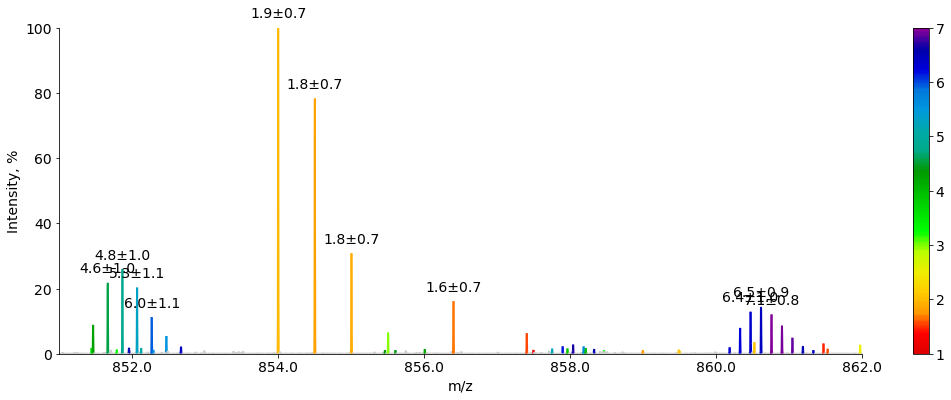

In [391]:
UbiSpec.RainbowSpectrum(851,862,UbiSpec.RPeaks,LabelThres=0.1,ColorThres=0.01,svg=True)

## Pictures for journal

### Figure 1

In [44]:
UbiSpec = FullSpectrum(np.loadtxt("D:\\FT Data\\Data Samples\\decay_ubi_cah\\2-ubiq_1e5_1-850_chB_r_transient_0-1500ms.csv",skiprows=2)[1000:5895500])

In [45]:
plt.rcParams["figure.figsize"] = (8,6)

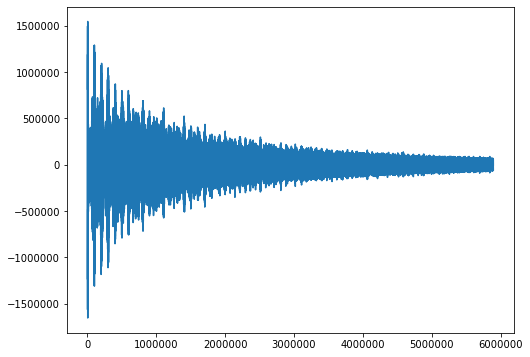

In [46]:
plt.plot(UbiSpec.trans)
plt.savefig("Panel1.svg")

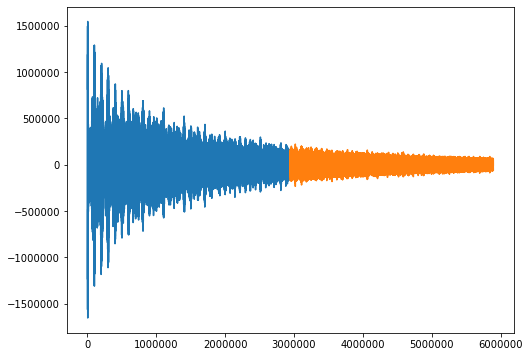

In [47]:
plt.plot(np.arange(UbiSpec.TrLen//2),UbiSpec.trans[0:UbiSpec.TrLen//2])
plt.plot(np.arange(UbiSpec.TrLen//2,UbiSpec.TrLen),UbiSpec.trans[UbiSpec.TrLen//2:UbiSpec.TrLen])

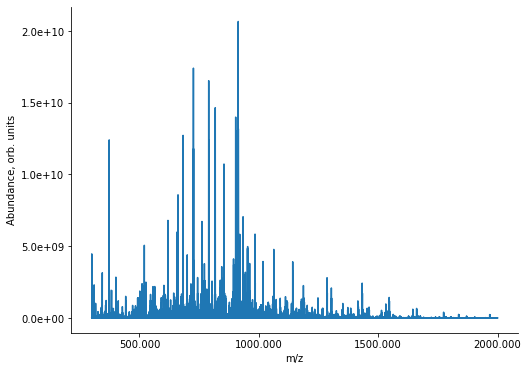

<module 'matplotlib.pyplot' from 'C:\\Users\\yaros\\Anaconda3\\envs\\tf2\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [48]:
UbiSpec.plotmasskai(300,2000,fname="Panel2.svg")

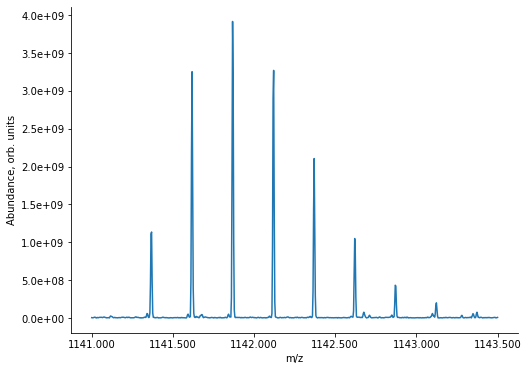

<module 'matplotlib.pyplot' from 'C:\\Users\\yaros\\Anaconda3\\envs\\tf2\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [49]:
UbiSpec.plotmasskai(1141,1143.5,fname="Panel3.svg")

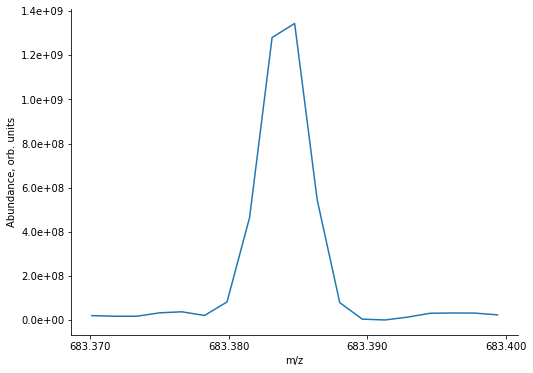

<module 'matplotlib.pyplot' from 'C:\\Users\\yaros\\Anaconda3\\envs\\tf2\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [50]:
UbiSpec.plotmasskai(683.37,683.4,fname="Panel4.svg")

### Figure 2

In [51]:
UbiSpec.UsualProcessing()

C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [53]:
UbiSpec.peaks

m/z   Intensity     resolution  issues
0       250.033602  10162227.0  197437.812500   False
1       250.119106  42258928.0  255193.671875   False
2       250.166453  12102844.0  130524.335938   False
3       250.178263  33436820.0  248922.218750   False
4       250.202274   9589675.0  200792.046875   False
...            ...         ...            ...     ...
33791  2496.138778   8000144.0   59239.210938   False
33792  2496.540501   9432369.0   46250.062500   False
33793  2497.670536  10001212.0   63940.718750   False
33794  2498.664374   8866208.0   37589.875000   False
33795  2498.912029   9195283.0   65680.625000   False

[33796 rows x 4 columns]

In [52]:
UbiSpec.Clusters

Mass  Charge  Abundance  Base Peak             Interval  \
0     1744.3646       7   27347360   250.2023    250.0336-251.0540   
1      250.0959       1  143416720   251.1032    250.9725-253.2930   
2      250.1435       1  109707600   251.1508    250.9725-253.2930   
3      251.1275       1   50028624   252.1348    252.0274-254.2632   
4     2514.4808      10   31059504   252.6559    252.3436-253.1664   
...         ...     ...        ...        ...                  ...   
2318  2391.4356       1   28518742  2393.4456  2392.1787-2398.7551   
2319  2417.1574       1   34875532  2418.1650  2417.1772-2424.3540   
2320  2439.5996       1   29419014  2442.6118  2440.4929-2446.8804   
2321  7324.7350       3   79166696  2443.9224  2442.1560-2446.8804   
2322  2456.4133       1   38580944  2459.4255  2456.4995-2464.2708   

      Correlation  
0          0.9270  
1          0.9993  
2          0.9997  
3          0.9915  
4          0.9867  
...           ...  
2318       0.9569  
2319       0.9866  
2320       0.9428  
2321       0.9366  
2322       0.9664  

[2323 rows x 6 columns]

In [236]:
UbiSpec.Products(sequence="MQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGG")

(           Mass  Charge  Abundance  Base Peak             Interval  \
 0     1744.3646       7   27347360   250.2023    250.0336-251.0540   
 1      250.0959       1  143416720   251.1032    250.9725-253.2930   
 2      250.1435       1  109707600   251.1508    250.9725-253.2930   
 3      251.1275       1   50028624   252.1348    252.0274-254.2632   
 4     2514.4808      10   31059504   252.6559    252.3436-253.1664   
 ...         ...     ...        ...        ...                  ...   
 2318  2391.4356       1   28518742  2393.4456  2392.1787-2398.7551   
 2319  2417.1574       1   34875532  2418.1650  2417.1772-2424.3540   
 2320  2439.5996       1   29419014  2442.6118  2440.4929-2446.8804   
 2321  7324.7350       3   79166696  2443.9224  2442.1560-2446.8804   
 2322  2456.4133       1   38580944  2459.4255  2456.4995-2464.2708   
 
       Correlation Ions  PPMError  Shift  TheorMass  
 0          0.9270            0.0      0        0.0  
 1          0.9993            0.0     

In [237]:
UbiSpec.PeakstoClusters()

C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [239]:
len(UbiSpec.RPeaks[UbiSpec.RPeaks["Ions"]!=""])

1167

In [241]:
len(UbiSpec.Clusters[UbiSpec.Clusters["Ions"]!=""])

212

In [50]:
UbiSpec.RPeaks=UbiSpec.RPeaks[UbiSpec.RPeaks['Ions']!=""]

In [51]:
UbiSpec.RPeaks=UbiSpec.RPeaks[UbiSpec.RPeaks["number"]==0]

In [52]:
UbiSpec.RPeaks=UbiSpec.RPeaks[UbiSpec.RPeaks["Correlation"]>0.98]

In [53]:
UbiSpec.RPeaks=UbiSpec.RPeaks[~UbiSpec.RPeaks["issues"]]

In [54]:
UbiSpec.SRCalc()

0 LinregressResult(slope=-2.0285165789326536, intercept=4.902530154496853, rvalue=-0.9889609995862676, pvalue=0.0, stderr=0.005374501334993001)
1 LinregressResult(slope=-1.585852623034676, intercept=6.97687312087885, rvalue=-0.9992233207061223, pvalue=0.0, stderr=0.0011058915810466324)
2 LinregressResult(slope=-0.7051017187548257, intercept=9.327137246357537, rvalue=-0.9997958473943026, pvalue=0.0, stderr=0.00025198315530850456)
3 LinregressResult(slope=-1.4780485191991075, intercept=4.2112500740233205, rvalue=-0.9237634456983751, pvalue=0.0, stderr=0.01083543002638855)
4 LinregressResult(slope=-2.013675527789864, intercept=5.086413402116158, rvalue=-0.979810613661887, pvalue=0.0, stderr=0.007265767661116309)
5 LinregressResult(slope=-2.349511315973185, intercept=4.752786109804189, rvalue=-0.9330415893817936, pvalue=0.0, stderr=0.01601992491002694)
6 LinregressResult(slope=-1.4926086339111913, intercept=6.305540005688023, rvalue=-0.996120810336692, pvalue=0.0, stderr=0.0023316245780721

m/z     Intensity     resolution  issues  cluster  number  \
0     336.219280  6.134931e+07  235617.000000   False      143       0   
1     340.885709  6.461985e+08  241279.703125   False      150       0   
2     373.190300  1.242558e+10  233241.078125   False      199       0   
3     374.214745  4.155771e+07  228483.218750   False      201       0   
4     378.580244  7.365858e+07  220029.546875   False      208       0   
..           ...           ...            ...     ...      ...     ...   
134  1579.916452  2.039474e+07  103602.679688   False     2124       0   
135  1675.974630  1.490847e+08  107425.664062   False     2192       0   
136  1805.016248  9.635850e+07   99762.593750   False     2239       0   
137  1904.083723  6.395316e+07  101279.820312   False     2271       0   
138  2033.125965  1.098032e+08   97172.039062   False     2295       0   

         rest     intensity       Mass  Charge  ...  Ions  PPMError Shift  \
0    0.000108  6.134931e+07   670.4239       2  ...    y6  0.082451     0   
1    0.000096  6.461985e+08  1019.6352       3  ...    y9 -0.034899     0   
2    0.000023  1.242558e+10   372.1830       1  ...    b3 -0.342904     0   
3    0.000036  4.155771e+07   746.4149       2  ...    b6 -0.026232     0   
4    0.000103  7.365858e+07  1132.7188       3  ...   y10 -0.441358     0   
..        ...           ...        ...     ...  ...   ...       ...   ...   
134  0.000275  2.039474e+07  1578.9089       1  ...   c14 -4.966538     0   
135  0.000354  1.490847e+08  1674.9670       1  ...   b15 -4.332607     0   
136  0.000372  9.635850e+07  1804.0086       1  ...   b16 -4.573809     0   
137  0.000047  6.395316e+07  1903.0764       1  ...   b17 -4.658496     0   
138 -0.000511  1.098032e+08  2032.1192       1  ...   b18 -4.261414     0   

       TheorMass     Slope  Intercept   RSquare     Ratio      FWHM  \
0     670.423845 -2.028517   4.902530 -0.988961  3.958016  0.001427   
1    1019.635236 -1.585853   6.976873 -0.999223  3.251067  0.001413   
2     372.183128 -0.705102   9.327137 -0.999796  1.728489  0.001600   
3     746.414920 -1.478049   4.211250 -0.923763  1.989147  0.001638   
4    1132.719300 -2.013676   5.086413 -0.979811  3.410930  0.001721   
..           ...       ...        ...       ...       ...       ...   
134  1578.916742 -0.473106   2.856840 -0.487728  1.221543  0.015250   
135  1674.974257 -1.015279   5.140671 -0.967207  2.143494  0.015601   
136  1804.016851 -1.693518   5.147122 -0.977280  3.616243  0.018093   
137  1903.085266 -1.714450   4.788556 -0.986970  2.683335  0.018800   
138  2032.127860 -1.781703   5.359344 -0.988488  4.319183  0.020923   

     FWHM Coeff  
0      1.257158  
1      1.231739  
2      1.222414  
3      1.238192  
4      1.264803  
..          ...  
134    1.297800  
135    1.242142  
136    1.273081  
137    1.238083  
138    1.245208  

[139 rows x 24 columns]

In [55]:
UbiSpec.RPeaks

m/z     Intensity     resolution  issues  cluster  number  \
0     336.219280  6.134931e+07  235617.000000   False      143       0   
1     340.885709  6.461985e+08  241279.703125   False      150       0   
2     373.190300  1.242558e+10  233241.078125   False      199       0   
3     374.214745  4.155771e+07  228483.218750   False      201       0   
4     378.580244  7.365858e+07  220029.546875   False      208       0   
..           ...           ...            ...     ...      ...     ...   
134  1579.916452  2.039474e+07  103602.679688   False     2124       0   
135  1675.974630  1.490847e+08  107425.664062   False     2192       0   
136  1805.016248  9.635850e+07   99762.593750   False     2239       0   
137  1904.083723  6.395316e+07  101279.820312   False     2271       0   
138  2033.125965  1.098032e+08   97172.039062   False     2295       0   

         rest     intensity       Mass  Charge  ...  Ions  PPMError Shift  \
0    0.000108  6.134931e+07   670.4239       2  ...    y6  0.082451     0   
1    0.000096  6.461985e+08  1019.6352       3  ...    y9 -0.034899     0   
2    0.000023  1.242558e+10   372.1830       1  ...    b3 -0.342904     0   
3    0.000036  4.155771e+07   746.4149       2  ...    b6 -0.026232     0   
4    0.000103  7.365858e+07  1132.7188       3  ...   y10 -0.441358     0   
..        ...           ...        ...     ...  ...   ...       ...   ...   
134  0.000275  2.039474e+07  1578.9089       1  ...   c14 -4.966538     0   
135  0.000354  1.490847e+08  1674.9670       1  ...   b15 -4.332607     0   
136  0.000372  9.635850e+07  1804.0086       1  ...   b16 -4.573809     0   
137  0.000047  6.395316e+07  1903.0764       1  ...   b17 -4.658496     0   
138 -0.000511  1.098032e+08  2032.1192       1  ...   b18 -4.261414     0   

       TheorMass     Slope  Intercept   RSquare     Ratio      FWHM  \
0     670.423845 -2.028517   4.902530 -0.988961  3.958016  0.001427   
1    1019.635236 -1.585853   6.976873 -0.999223  3.251067  0.001413   
2     372.183128 -0.705102   9.327137 -0.999796  1.728489  0.001600   
3     746.414920 -1.478049   4.211250 -0.923763  1.989147  0.001638   
4    1132.719300 -2.013676   5.086413 -0.979811  3.410930  0.001721   
..           ...       ...        ...       ...       ...       ...   
134  1578.916742 -0.473106   2.856840 -0.487728  1.221543  0.015250   
135  1674.974257 -1.015279   5.140671 -0.967207  2.143494  0.015601   
136  1804.016851 -1.693518   5.147122 -0.977280  3.616243  0.018093   
137  1903.085266 -1.714450   4.788556 -0.986970  2.683335  0.018800   
138  2032.127860 -1.781703   5.359344 -0.988488  4.319183  0.020923   

     FWHM Coeff  
0      1.257158  
1      1.231739  
2      1.222414  
3      1.238192  
4      1.264803  
..          ...  
134    1.297800  
135    1.242142  
136    1.273081  
137    1.238083  
138    1.245208  

[139 rows x 24 columns]

In [56]:
FRes=UbiSpec.RPeaks[UbiSpec.RPeaks["RSquare"]<-0.85]
FRes=FRes[FRes["number"]==0]

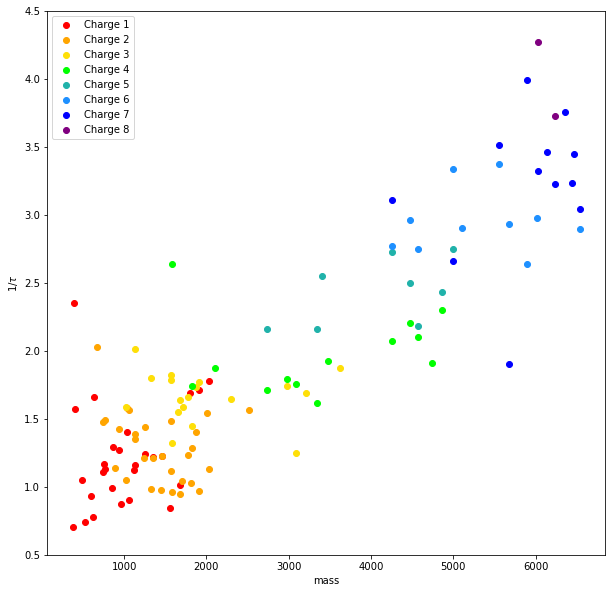

In [57]:
Counter=0
plt.rcParams["figure.figsize"] = (10,10)
for i in range(1,9):
    Yscat=-FRes["Slope"][FRes["Charge"]==i]
    Xscat=FRes["m/z"][FRes["Charge"]==i]*i
    plt.plot(Xscat,Yscat,"o",color=colors[i],label="Charge "+str(i))
plt.legend()
plt.xlabel("mass")
plt.ylabel(r"1/$\tau$")
#plt.xlim(800,860)
plt.ylim(0.5,4.5)
plt.savefig("Panel2-1-var1.svg")
plt.show()

In [58]:
UbiSpec.PeakstoClusters()

C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [242]:
UbiSpec.RPeaks=UbiSpec.RPeaks[UbiSpec.RPeaks['Ions']!=""]

In [243]:
UbiSpec.RPeaks=UbiSpec.RPeaks[UbiSpec.RPeaks["Correlation"]>0.98]

In [244]:
UbiSpec.RPeaks=UbiSpec.RPeaks[~UbiSpec.RPeaks["issues"]]

In [245]:
UbiSpec.RPeaks=UbiSpec.RPeaks[UbiSpec.RPeaks.Intensity>1.0e08]

In [247]:
UbiSpec.SRCalc()

0 LinregressResult(slope=-1.585852623034676, intercept=6.97687312087885, rvalue=-0.9992233207061223, pvalue=0.0, stderr=0.0011058915810466324)
1 LinregressResult(slope=-1.5899607476628939, intercept=6.2271959919404125, rvalue=-0.9405136273294694, pvalue=0.0, stderr=0.010156619268279793)
2 LinregressResult(slope=-0.7051017187548257, intercept=9.327137246357537, rvalue=-0.9997958473943026, pvalue=0.0, stderr=0.00025198315530850456)
3 LinregressResult(slope=-0.8456475434603675, intercept=7.585471089531257, rvalue=-0.9987612472018764, pvalue=0.0, stderr=0.000745008561203274)
4 LinregressResult(slope=-1.4926086339111913, intercept=6.305540005688023, rvalue=-0.996120810336692, pvalue=0.0, stderr=0.002331624578072154)
5 LinregressResult(slope=-1.4152995181714791, intercept=5.330396001615843, rvalue=-0.95235945059914, pvalue=0.0, stderr=0.008014501295214593)
6 LinregressResult(slope=-1.5719707693775369, intercept=5.877581057802271, rvalue=-0.9899964994122142, pvalue=0.0, stderr=0.0039616283845

m/z     Intensity     resolution  issues  cluster  number  \
0     340.885709  6.461985e+08  241279.703125   False      150       0   
1     341.220173  3.007582e+08  244628.937500   False      150       1   
2     373.190300  1.242558e+10  233241.078125   False      199       0   
3     374.193646  1.972783e+09  235001.218750   False      199       1   
4     385.753269  3.492118e+08  224314.703125   False      220       0   
..           ...           ...            ...     ...      ...     ...   
561  1563.895280  2.102023e+08  108530.632812   False     2109       1   
562  1675.974630  1.490847e+08  107425.664062   False     2192       0   
563  1676.978170  1.271138e+08  105360.921875   False     2192       1   
564  2033.125965  1.098032e+08   97172.039062   False     2295       0   
565  2034.129050  1.242058e+08   93161.679688   False     2295       1   

         rest     intensity       Mass  Charge  ...  Ions  PPMError Shift  \
0    0.000096  6.461985e+08  1019.6352       3  ...    y9 -0.034899     0   
1    0.000135  3.007582e+08  1019.6352       3  ...    y9 -0.034899     0   
2    0.000023  1.242558e+10   372.1830       1  ...    b3 -0.342904     0   
3    0.000015  1.972783e+09   372.1830       1  ...    b3 -0.342904     0   
4    0.000085  3.492118e+08   769.4919       2  ...    y7 -0.466554     0   
..        ...           ...        ...     ...  ...   ...       ...   ...   
561  0.001249  2.102023e+08  1561.8834       1  ...   b14 -4.348996     0   
562  0.000354  1.490847e+08  1674.9670       1  ...   b15 -4.332607     0   
563  0.000539  1.271138e+08  1674.9670       1  ...   b15 -4.332607     0   
564 -0.000511  1.098032e+08  2032.1192       1  ...   b18 -4.261414     0   
565 -0.000781  1.242058e+08  2032.1192       1  ...   b18 -4.261414     0   

       TheorMass     Slope  Intercept   RSquare     Ratio      FWHM  \
0    1019.635236 -1.585853   6.976873 -0.999223  3.251067  0.001413   
1    1019.635236 -1.589961   6.227196 -0.940514  4.117533  0.001395   
2     372.183128 -0.705102   9.327137 -0.999796  1.728489  0.001600   
3     372.183128 -0.845648   7.585471 -0.998761  1.989504  0.001592   
4     769.492259 -1.492609   6.305540 -0.996121  3.386155  0.001720   
..           ...       ...        ...       ...       ...       ...   
561  1561.890193 -1.153688   5.580529 -0.986159  2.574061  0.014410   
562  1674.974257 -1.015279   5.140671 -0.967207  2.143494  0.015601   
563  1674.974257 -1.352125   5.204731 -0.970992  2.686987  0.015917   
564  2032.127860 -1.781703   5.359344 -0.988488  4.319183  0.020923   
565  2032.127860 -2.042389   5.618145 -0.988548  4.289287  0.021834   

     FWHM Coeff  
0      1.231739  
1      1.220073  
2      1.222414  
3      1.215215  
4      1.240856  
..          ...  
561    1.262498  
562    1.242142  
563    1.258065  
564    1.245208  
565    1.280477  

[566 rows x 24 columns]

In [248]:
UbiSpec.RPeaks

m/z     Intensity     resolution  issues  cluster  number  \
0     340.885709  6.461985e+08  241279.703125   False      150       0   
1     341.220173  3.007582e+08  244628.937500   False      150       1   
2     373.190300  1.242558e+10  233241.078125   False      199       0   
3     374.193646  1.972783e+09  235001.218750   False      199       1   
4     385.753269  3.492118e+08  224314.703125   False      220       0   
..           ...           ...            ...     ...      ...     ...   
561  1563.895280  2.102023e+08  108530.632812   False     2109       1   
562  1675.974630  1.490847e+08  107425.664062   False     2192       0   
563  1676.978170  1.271138e+08  105360.921875   False     2192       1   
564  2033.125965  1.098032e+08   97172.039062   False     2295       0   
565  2034.129050  1.242058e+08   93161.679688   False     2295       1   

         rest     intensity       Mass  Charge  ...  Ions  PPMError Shift  \
0    0.000096  6.461985e+08  1019.6352       3  ...    y9 -0.034899     0   
1    0.000135  3.007582e+08  1019.6352       3  ...    y9 -0.034899     0   
2    0.000023  1.242558e+10   372.1830       1  ...    b3 -0.342904     0   
3    0.000015  1.972783e+09   372.1830       1  ...    b3 -0.342904     0   
4    0.000085  3.492118e+08   769.4919       2  ...    y7 -0.466554     0   
..        ...           ...        ...     ...  ...   ...       ...   ...   
561  0.001249  2.102023e+08  1561.8834       1  ...   b14 -4.348996     0   
562  0.000354  1.490847e+08  1674.9670       1  ...   b15 -4.332607     0   
563  0.000539  1.271138e+08  1674.9670       1  ...   b15 -4.332607     0   
564 -0.000511  1.098032e+08  2032.1192       1  ...   b18 -4.261414     0   
565 -0.000781  1.242058e+08  2032.1192       1  ...   b18 -4.261414     0   

       TheorMass     Slope  Intercept   RSquare     Ratio      FWHM  \
0    1019.635236 -1.585853   6.976873 -0.999223  3.251067  0.001413   
1    1019.635236 -1.589961   6.227196 -0.940514  4.117533  0.001395   
2     372.183128 -0.705102   9.327137 -0.999796  1.728489  0.001600   
3     372.183128 -0.845648   7.585471 -0.998761  1.989504  0.001592   
4     769.492259 -1.492609   6.305540 -0.996121  3.386155  0.001720   
..           ...       ...        ...       ...       ...       ...   
561  1561.890193 -1.153688   5.580529 -0.986159  2.574061  0.014410   
562  1674.974257 -1.015279   5.140671 -0.967207  2.143494  0.015601   
563  1674.974257 -1.352125   5.204731 -0.970992  2.686987  0.015917   
564  2032.127860 -1.781703   5.359344 -0.988488  4.319183  0.020923   
565  2032.127860 -2.042389   5.618145 -0.988548  4.289287  0.021834   

     FWHM Coeff  
0      1.231739  
1      1.220073  
2      1.222414  
3      1.215215  
4      1.240856  
..          ...  
561    1.262498  
562    1.242142  
563    1.258065  
564    1.245208  
565    1.280477  

[566 rows x 24 columns]

In [249]:
FRes=UbiSpec.RPeaks[UbiSpec.RPeaks["RSquare"]<-0.85]

In [255]:
FRes

m/z     Intensity     resolution  issues  cluster  number  \
0     340.885709  6.461985e+08  241279.703125   False      150       0   
1     341.220173  3.007582e+08  244628.937500   False      150       1   
2     373.190300  1.242558e+10  233241.078125   False      199       0   
3     374.193646  1.972783e+09  235001.218750   False      199       1   
4     385.753269  3.492118e+08  224314.703125   False      220       0   
..           ...           ...            ...     ...      ...     ...   
561  1563.895280  2.102023e+08  108530.632812   False     2109       1   
562  1675.974630  1.490847e+08  107425.664062   False     2192       0   
563  1676.978170  1.271138e+08  105360.921875   False     2192       1   
564  2033.125965  1.098032e+08   97172.039062   False     2295       0   
565  2034.129050  1.242058e+08   93161.679688   False     2295       1   

         rest     intensity       Mass  Charge  ...  Ions  PPMError Shift  \
0    0.000096  6.461985e+08  1019.6352       3  ...    y9 -0.034899     0   
1    0.000135  3.007582e+08  1019.6352       3  ...    y9 -0.034899     0   
2    0.000023  1.242558e+10   372.1830       1  ...    b3 -0.342904     0   
3    0.000015  1.972783e+09   372.1830       1  ...    b3 -0.342904     0   
4    0.000085  3.492118e+08   769.4919       2  ...    y7 -0.466554     0   
..        ...           ...        ...     ...  ...   ...       ...   ...   
561  0.001249  2.102023e+08  1561.8834       1  ...   b14 -4.348996     0   
562  0.000354  1.490847e+08  1674.9670       1  ...   b15 -4.332607     0   
563  0.000539  1.271138e+08  1674.9670       1  ...   b15 -4.332607     0   
564 -0.000511  1.098032e+08  2032.1192       1  ...   b18 -4.261414     0   
565 -0.000781  1.242058e+08  2032.1192       1  ...   b18 -4.261414     0   

       TheorMass     Slope  Intercept   RSquare     Ratio      FWHM  \
0    1019.635236 -1.585853   6.976873 -0.999223  3.251067  0.001413   
1    1019.635236 -1.589961   6.227196 -0.940514  4.117533  0.001395   
2     372.183128 -0.705102   9.327137 -0.999796  1.728489  0.001600   
3     372.183128 -0.845648   7.585471 -0.998761  1.989504  0.001592   
4     769.492259 -1.492609   6.305540 -0.996121  3.386155  0.001720   
..           ...       ...        ...       ...       ...       ...   
561  1561.890193 -1.153688   5.580529 -0.986159  2.574061  0.014410   
562  1674.974257 -1.015279   5.140671 -0.967207  2.143494  0.015601   
563  1674.974257 -1.352125   5.204731 -0.970992  2.686987  0.015917   
564  2032.127860 -1.781703   5.359344 -0.988488  4.319183  0.020923   
565  2032.127860 -2.042389   5.618145 -0.988548  4.289287  0.021834   

     FWHM Coeff  
0      1.231739  
1      1.220073  
2      1.222414  
3      1.215215  
4      1.240856  
..          ...  
561    1.262498  
562    1.242142  
563    1.258065  
564    1.245208  
565    1.280477  

[533 rows x 24 columns]

In [251]:
FRes=FWHMCalc(FRes)

C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [252]:
FWHMstd=np.std(FRes["FWHM Coeff"])

In [253]:
FWHMmean=np.mean(FRes["FWHM Coeff"])

In [254]:
FRes=FRes[(FRes["FWHM Coeff"]<FWHMmean+3*FWHMstd) & (FRes["FWHM Coeff"]>FWHMmean-3*FWHMstd)]

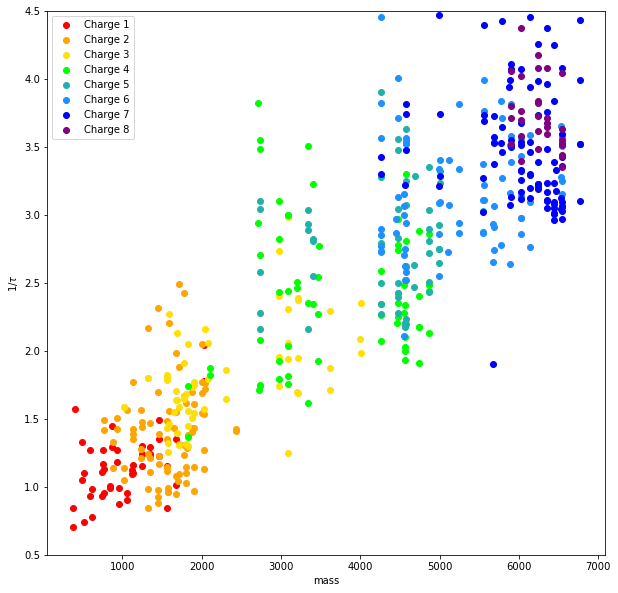

In [71]:
Counter=0
plt.rcParams["figure.figsize"] = (10,10)
for i in range(1,9):
    Yscat=-FRes["Slope"][FRes["Charge"]==i]
    Xscat=FRes["m/z"][FRes["Charge"]==i]*i
    plt.plot(Xscat,Yscat,"o",color=colors[i],label="Charge "+str(i))
plt.legend()
plt.xlabel("mass")
plt.ylabel(r"1/$\tau$")
#plt.xlim(800,860)
plt.ylim(0.5,4.5)
plt.savefig("Panel2-1-var2.svg")
plt.show()

In [72]:
regr=LinearReg(FRes,FWHM=True)
Y_Pred=regr.Apply(FRes)

1 46 (1.3586406291322213, 0.46405348958418285)
2 80 (2.285458065412519, 0.6150636018705676)
3 60 (3.0246273421713794, 0.6857462891868261)
4 65 (4.1892683681780145, 0.8855355825142479)
5 54 (5.166796995157716, 0.58772654031906)
6 79 (5.783420341818595, 0.6421297954451328)
7 101 (6.677682699079415, 0.6597060472492735)
8 36 (7.744290262996395, 0.7622434821090067)
5.125456614172064


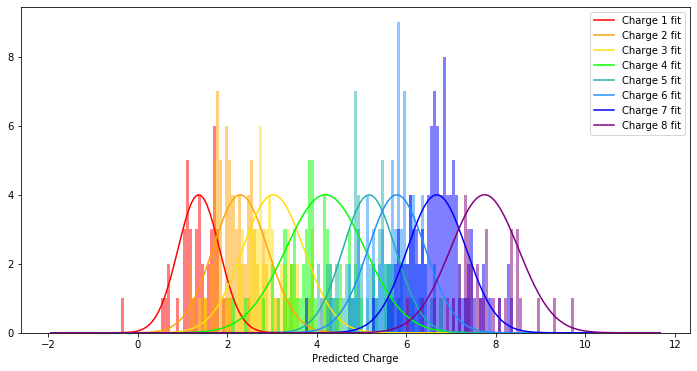

In [73]:
plt.rcParams["figure.figsize"] = (12,6)
ShowRes(Y_Pred,FRes["Charge"],MaxCharge=8,GaussianHeght=4,fname="Panel2-2.svg")

In [74]:
lr=LogisticReg(FRes,FWHM=True)
Y,Y_Distr=lr.Apply(FRes)

1 46 (1.229509712504942, 0.3482340957769942)
2 80 (2.2918638714104618, 0.5036681475023009)
3 60 (2.951257707716833, 0.6277846823396818)
4 65 (4.18356471404444, 0.9294719768445722)
5 54 (5.241917899468815, 0.7812348512032737)
6 79 (5.87629899213244, 0.6985711389402506)
7 101 (6.698775682876387, 0.5559462160662445)
8 36 (7.616179171567481, 0.4507594528427091)
5.551072210704162


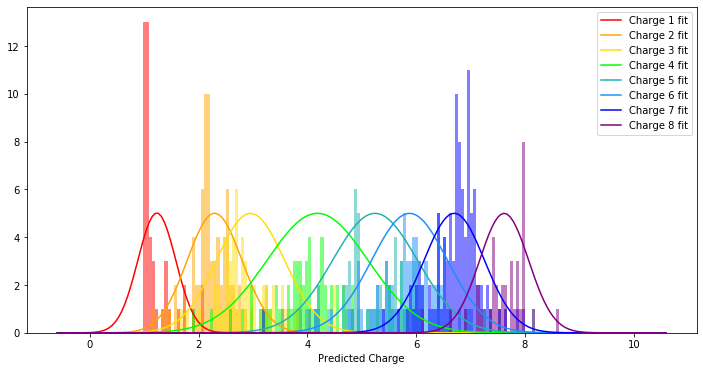

In [75]:
ShowRes(Y,FRes["Charge"],MaxCharge=8,GaussianHeght=5,fname="PanelS1-1.svg")

In [76]:
lrm=MassLogisticReg(FRes,FWHM=True)
FRes.reset_index(inplace=True,drop=True)
Y_pred_mass,Y_pred_Distr=lrm.Apply(FRes)

1 46 (1.1625347133875221, 0.3024843053465091)
2 80 (2.1527100268193395, 0.4961217489333118)
3 60 (3.0559070663637966, 0.5660932365850099)
4 65 (4.203894948498058, 0.8025181223203373)
5 54 (5.2754053099161995, 0.6773400846084496)
6 79 (5.911556067988799, 0.6834874640045369)
7 101 (6.738803952995429, 0.5699011034208674)
8 36 (7.704122527545037, 0.4145964512774103)
6.0223744612812755


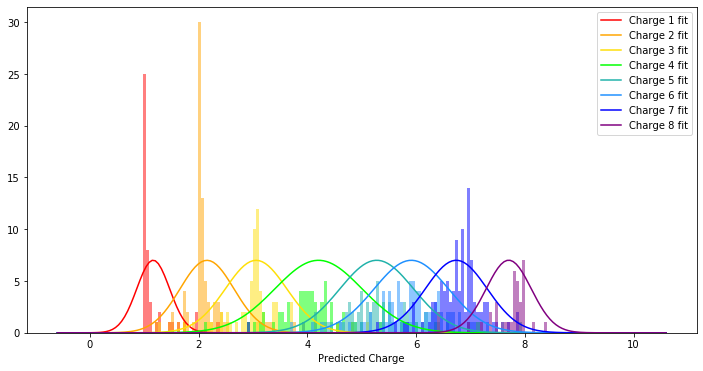

In [77]:
ShowRes(Y_pred_mass,FRes["Charge"],MaxCharge=8,GaussianHeght=7,fname="PanelS1-2.svg")

### Graphical abstract

In [381]:
GAPeaks=UbiSpec.peaks[(UbiSpec.peaks["m/z"]>596)&(UbiSpec.peaks["m/z"]<601)&(UbiSpec.peaks["Intensity"]>3.0e7)]

In [383]:
GAPeaks=UbiSpec.SRCalc(GAPeaks)

C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



0 LinregressResult(slope=-2.128684349788705, intercept=5.1317244959344315, rvalue=-0.959316601419178, pvalue=0.0, stderr=0.011078245859888388)
1 LinregressResult(slope=-1.0171511812907488, intercept=4.495615647694182, rvalue=-0.93151184532124, pvalue=0.0, stderr=0.0070228649440711765)
2 LinregressResult(slope=-1.4710333975886054, intercept=6.902313713479217, rvalue=-0.9943895628805159, pvalue=0.0, stderr=0.0027671333706690217)
3 LinregressResult(slope=-1.9401809698813592, intercept=5.629858344437562, rvalue=-0.8546091433825126, pvalue=0.0, stderr=0.020846359442107675)
4 LinregressResult(slope=-1.80822917631106, intercept=5.453033271429894, rvalue=-0.8252340735475314, pvalue=0.0, stderr=0.021883901775854094)
5 LinregressResult(slope=-1.2608706472317543, intercept=6.714945889711707, rvalue=-0.9971529406875675, pvalue=0.0, stderr=0.0016860616486568344)
6 LinregressResult(slope=-1.7326269812326307, intercept=6.929762670207109, rvalue=-0.7440012602678894, pvalue=0.0, stderr=0.02751594819404

In [382]:
GAPeaks

m/z     Intensity     resolution  issues
7080  596.021586  7.189173e+07  185339.062500   False
7087  596.303082  7.944669e+07  179501.750000   False
7089  596.341782  6.443807e+08  178580.937500   False
7091  596.356180  4.377528e+07  147321.109375    True
7092  596.361623  1.287454e+08  173732.609375    True
7093  596.375780  6.156628e+08  180770.671875   False
7098  596.669905  1.983073e+08  185484.781250    True
7099  596.676262  5.155882e+08  184461.375000    True
7102  596.863222  4.652573e+07  164536.375000   False
7104  597.004377  1.858912e+08  180297.515625    True
7105  597.010689  2.332339e+08  181537.734375    True
7110  597.286967  2.134669e+08  182633.218750   False
7113  597.338952  7.300990e+07  193534.796875    True
7114  597.345113  6.553856e+07  182546.593750    True
7117  597.379080  1.913556e+08  179697.796875   False
7123  597.673607  5.130746e+07  191922.843750    True
7139  598.290436  5.097134e+07  186191.687500   False
7142  598.331999  4.320719e+07  177376.203125   False
7143  598.345161  5.025518e+07  121858.179688   False
7145  598.370252  7.234176e+07  185904.859375   False
7146  598.382667  3.303554e+07  163116.093750   False
7152  598.679746  4.094354e+07  154830.562500   False
7165  599.266176  3.481388e+07  177751.171875   False
7170  599.354183  6.849324e+07  178182.906250   False
7177  599.650206  1.638725e+09  183292.453125   False
7182  599.984688  1.445594e+09  183509.562500   False
7189  600.319210  5.356355e+08  186503.375000   False
7191  600.334218  5.357285e+07  179639.921875    True
7192  600.359980  1.353796e+08  162093.343750   False
7193  600.370638  2.218584e+08  182322.328125   False
7196  600.653614  1.279812e+08  183502.906250   False
7197  600.835869  3.134808e+07  168590.562500   False
7198  600.852157  1.289707e+08  177242.421875   False
7199  600.861786  6.586395e+07  180466.718750   False

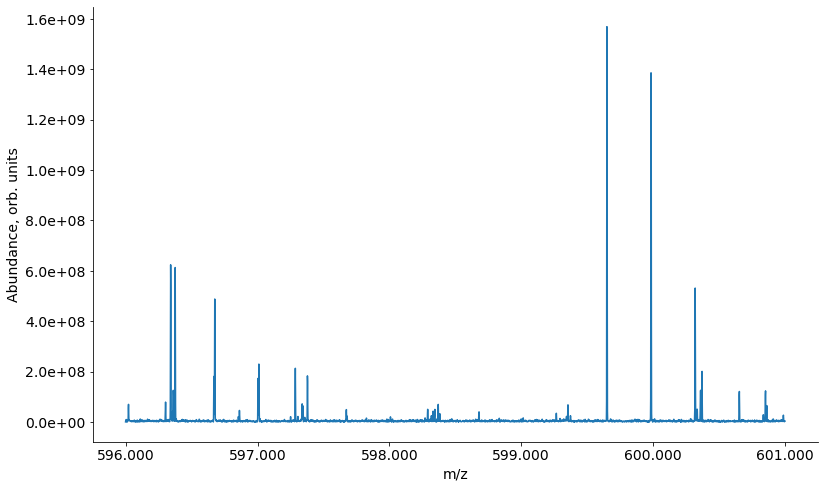

<module 'matplotlib.pyplot' from 'C:\\Users\\yaros\\Anaconda3\\envs\\tf2\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [380]:
plt.rcParams["figure.figsize"] = (13,8)
UbiSpec.plotmasskai(596,601)

In [384]:
GAPeaks=lrm.Estimate(GAPeaks)

C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


-0.875 7.875


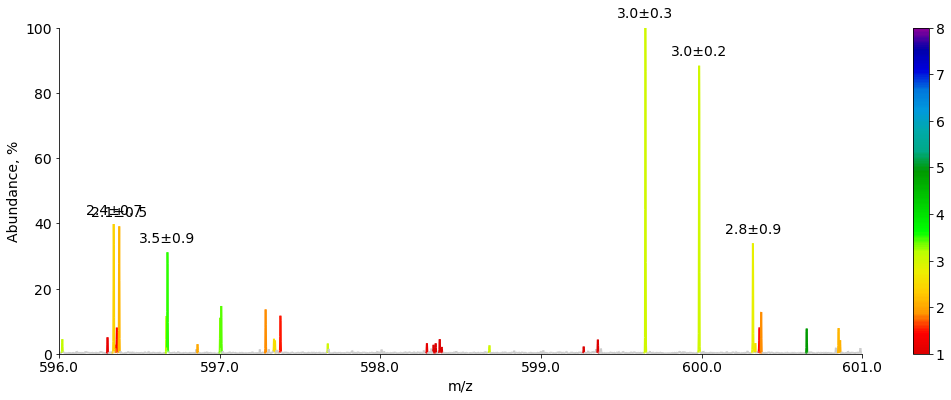

In [385]:
UbiSpec.RainbowSpectrum(596,601,GAPeaks, svg=True, Name="GA-Spec7")

### Figure 3

In [78]:
F3Peaks = UbiSpec.peaks[(UbiSpec.peaks["m/z"]>811.)&(UbiSpec.peaks["m/z"]<813.5)]

In [79]:
UbiSpec.SRCalc(Peaks=F3Peaks)

C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



0 LinregressResult(slope=-1.8537748827204499, intercept=3.1066480315863783, rvalue=-0.5642285850458658, pvalue=1.8133992990790839e-268, stderr=0.047966955845141566)
1 LinregressResult(slope=-1.2327499861177036, intercept=3.3768787777365104, rvalue=-0.44940665250794837, pvalue=6.73298540538037e-159, stderr=0.04333181543884989)
2 LinregressResult(slope=-0.7973913017168526, intercept=3.065152035350286, rvalue=-0.3889903594040305, pvalue=4.2237031110033527e-116, stderr=0.03339389468271433)
3 LinregressResult(slope=-0.5488180532228206, intercept=2.936804141813156, rvalue=-0.2076473482109261, pvalue=1.6678496325665352e-32, stderr=0.04571851272493204)
4 LinregressResult(slope=-0.6302886986813558, intercept=3.144900854030879, rvalue=-0.23562906770074413, pvalue=1.2806022563532735e-41, stderr=0.045969265573361485)
5 LinregressResult(slope=-0.6526318001179701, intercept=3.0964860793212785, rvalue=-0.33475816313626067, pvalue=1.2209791184913876e-84, stderr=0.03248545061404739)
6 LinregressResult(

m/z    Intensity     resolution  issues     Slope  Intercept  \
0    811.000369   11073826.0  112295.335938   False -1.853775   3.106648   
1    811.015810   15308393.0  149533.843750   False -1.232750   3.376879   
2    811.026462   16383418.0   84767.554688   False -0.797391   3.065152   
3    811.038615   18650652.0  108112.375000   False -0.548818   2.936804   
4    811.061247   24789634.0   98952.312500    True -0.630289   3.144901   
..          ...          ...            ...     ...       ...        ...   
140  813.431740   59008872.0  149421.734375    True -2.276037   6.010942   
141  813.436310   90308640.0  137862.859375    True -0.965857   5.518069   
142  813.444657  210898048.0  120966.281250    True -1.656107   6.022179   
143  813.469686   67155960.0   97546.859375   False -1.486775   4.679676   
144  813.485352  157134080.0  138867.203125   False -1.110315   5.307817   

      RSquare     Ratio      FWHM  FWHM Coeff  
0   -0.564229  2.008479  0.007222    1.536173  
1   -0.449407  0.947460  0.005424    1.269191  
2   -0.388990  0.831827  0.009568    1.852885  
3   -0.207647  0.886878  0.007502    1.575516  
4   -0.235629  1.257322  0.008196    1.671280  
..        ...       ...       ...         ...  
140 -0.708846  2.510893  0.005444    1.268567  
141 -0.506033  2.613813  0.005900    1.338509  
142 -0.846966  2.669228  0.006725    1.460398  
143 -0.535977  2.637422  0.008339    1.685627  
144 -0.733263  3.194848  0.005858    1.332021  

[145 rows x 10 columns]

In [80]:
F3Peaks

m/z    Intensity     resolution  issues     Slope  Intercept  \
0    811.000369   11073826.0  112295.335938   False -1.853775   3.106648   
1    811.015810   15308393.0  149533.843750   False -1.232750   3.376879   
2    811.026462   16383418.0   84767.554688   False -0.797391   3.065152   
3    811.038615   18650652.0  108112.375000   False -0.548818   2.936804   
4    811.061247   24789634.0   98952.312500    True -0.630289   3.144901   
..          ...          ...            ...     ...       ...        ...   
140  813.431740   59008872.0  149421.734375    True -2.276037   6.010942   
141  813.436310   90308640.0  137862.859375    True -0.965857   5.518069   
142  813.444657  210898048.0  120966.281250    True -1.656107   6.022179   
143  813.469686   67155960.0   97546.859375   False -1.486775   4.679676   
144  813.485352  157134080.0  138867.203125   False -1.110315   5.307817   

      RSquare     Ratio      FWHM  FWHM Coeff  
0   -0.564229  2.008479  0.007222    1.536173  
1   -0.449407  0.947460  0.005424    1.269191  
2   -0.388990  0.831827  0.009568    1.852885  
3   -0.207647  0.886878  0.007502    1.575516  
4   -0.235629  1.257322  0.008196    1.671280  
..        ...       ...       ...         ...  
140 -0.708846  2.510893  0.005444    1.268567  
141 -0.506033  2.613813  0.005900    1.338509  
142 -0.846966  2.669228  0.006725    1.460398  
143 -0.535977  2.637422  0.008339    1.685627  
144 -0.733263  3.194848  0.005858    1.332021  

[145 rows x 10 columns]

In [81]:
F3Peaks=FWHMCalc(F3Peaks)

C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [82]:
lr=MassLogisticReg(FRes,FWHM=True)
F3Peaks=lr.Estimate(F3Peaks)

C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [83]:
UbiSpec.RPeaks[(UbiSpec.RPeaks["m/z"]>811.)&(UbiSpec.RPeaks["m/z"]<813.)]

m/z    Intensity     resolution  issues  cluster  number  \
231  811.304944  135181072.0  174163.515625   False      945       0   
232  811.591798  522446336.0  147116.671875   False      945       2   
233  811.734752  580055232.0  151599.406250   False      945       3   
234  811.877859  479625632.0  145889.937500   False      945       4   
235  812.021295  266779072.0  143068.093750   False      945       5   
236  812.164553  188229504.0  149248.046875   False      945       6   

         rest    intensity       Mass  Charge  ...  Ions  PPMError Shift  \
231 -0.000626  135181072.0  5672.0843       7  ...   y50 -1.265536     0   
232  0.000640  522446336.0  5672.0843       7  ...   y50 -1.265536     0   
233 -0.002035  580055232.0  5672.0843       7  ...   y50 -1.265536     0   
234 -0.003643  479625632.0  5672.0843       7  ...   y50 -1.265536     0   
235 -0.002947  266779072.0  5672.0843       7  ...   y50 -1.265536     0   
236 -0.003491  188229504.0  5672.0843       7  ...   y50 -1.265536     0   

       TheorMass     Slope  Intercept   RSquare      Ratio      FWHM  \
231  5672.091478 -1.904321   5.679221 -0.913079   4.100234  0.004658   
232  5672.091478 -3.576800   8.004758 -0.999051  14.700183  0.005517   
233  5672.091478 -3.377663   8.006369 -0.999300  12.352707  0.005354   
234  5672.091478 -3.527983   7.889885 -0.998995  12.598030  0.005565   
235  5672.091478 -4.606491   7.883409 -0.993583  15.737766  0.005676   
236  5672.091478 -3.731923   7.092808 -0.994067  11.853763  0.005442   

     FWHM Coeff  
231    1.146396  
232    1.282750  
233    1.257266  
234    1.289779  
235    1.306604  
236    1.270211  

[6 rows x 24 columns]

In [84]:
F3Peaks[F3Peaks["Intensity"]>2.e8]

m/z    Intensity     resolution  issues     Slope  Intercept  \
26   811.448544  293100800.0  143699.875000    True -4.096881   7.659623   
38   811.591798  522446336.0  147116.671875   False -3.576800   8.004758   
47   811.734752  580055232.0  151599.406250   False -3.377663   8.006369   
56   811.877859  479625632.0  145889.937500   False -3.527983   7.889885   
65   812.021295  266779072.0  143068.093750   False -4.606491   7.883409   
70   812.085903  269232896.0  149556.312500   False -1.852995   6.291870   
90   812.420574  283254752.0  156554.578125   False -2.073267   6.455869   
97   812.497601  488621920.0  145760.421875   False -0.858105   6.220880   
142  813.444657  210898048.0  120966.281250    True -1.656107   6.022179   

      RSquare      Ratio      FWHM  FWHM Coeff      Aver     Sigma  
26  -0.878392  13.408698  0.005647    1.303079  7.185750  0.536534  
38  -0.999051  14.700183  0.005517    1.282750  6.731206  0.530186  
47  -0.999300  12.352707  0.005354    1.257266  6.750061  0.462849  
56  -0.998995  12.598030  0.005565    1.289779  6.795472  0.487038  
65  -0.993583  15.737766  0.005676    1.306604  7.898245  0.306844  
70  -0.995110   4.595747  0.005430    1.268506  3.009590  0.121249  
90  -0.992776   4.086839  0.005189    1.230251  3.333703  0.754464  
97  -0.873263   2.705416  0.005574    1.290214  1.001272  0.035889  
142 -0.846966   2.669228  0.006725    1.460398  2.006180  0.413668

-0.875 7.875


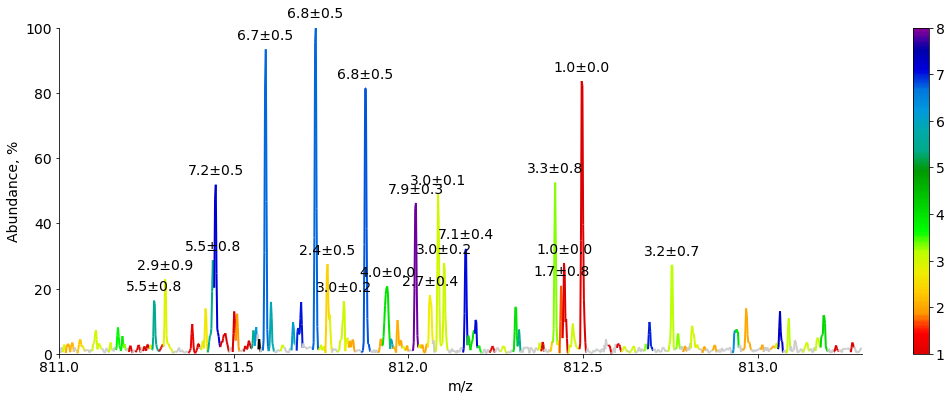

In [282]:
UbiSpec.RainbowSpectrum(811,813.3,F3Peaks,maxCharge=8,svg=True,Name="Panel3-1")

In [86]:
lowPeaks=F3Peaks[F3Peaks["Aver"]<4.]
highPeaks=F3Peaks[F3Peaks["Aver"]>5.]
midPeaks=F3Peaks[F3Peaks["Aver"]<6.]
midPeaks=midPeaks[midPeaks["Aver"]>3.]

In [87]:
plt.rcParams["figure.figsize"] = (8,5)

In [88]:
F3MaxInt=np.max(F3Peaks["Intensity"])

C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:5: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """


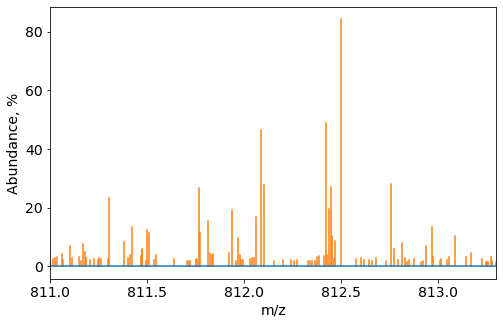

In [89]:
fig, ax = plt.subplots()
ax.set_xlabel("m/z")
ax.set_ylabel("Abundance, %")
ax.set_xlim(811.,813.3)
ax.stem(lowPeaks["m/z"],(lowPeaks["Intensity"]/F3MaxInt)*100.,"C1",markerfmt=" ", basefmt="C0")
plt.savefig("Panel3-2.svg")
plt.show()

C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:5: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """


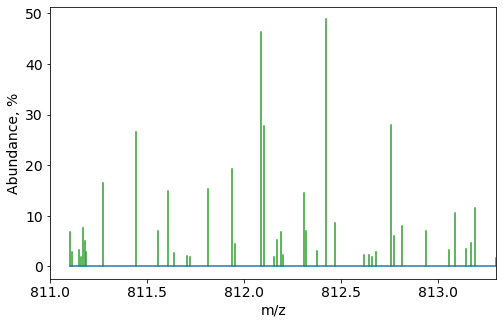

In [90]:
fig, ax = plt.subplots()
ax.set_xlabel("m/z")
ax.set_ylabel("Abundance, %")
ax.set_xlim(811.,813.3)
ax.stem(midPeaks["m/z"],(midPeaks["Intensity"]/F3MaxInt)*100.,"C2",markerfmt=" ", basefmt="C0")
plt.savefig("Panel3-3.svg")
plt.show()

C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:5: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """


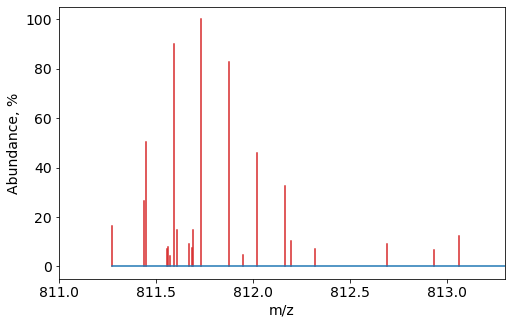

In [91]:
fig, ax = plt.subplots()
ax.set_xlabel("m/z")
ax.set_ylabel("Abundance, %")
ax.set_xlim(811.,813.3)
ax.stem(highPeaks["m/z"],(highPeaks["Intensity"]/F3MaxInt)*100.,"C3",markerfmt=" ", basefmt="C0")
plt.savefig("Panel3-4.svg")
plt.show()

### Figure 4

In [54]:
myhf=h5py.File("D:\\FT Data\\Data Samples\\decay_ubi_cah\\CAH_MYO_OVA_averaged_transient_1.0s.h5")

In [55]:
CAHSingle=FullSpectrum((myhf["0"][:])[1000:4100000])

In [56]:
CAHSingle.PeakPick(119,2600,sn=3.)
CAHSingle.CheckIssues()
CAHSingle.RunHardKlor(charge_min=1,charge_max=40)

In [57]:
CAHSingle.Clusters.at[18,"Mass"]=29006.48
CAHSingle.Clusters.at[18,"Charge"]=34
CAHSingle.Clusters.at[47,"Mass"]=29006.48
CAHSingle.Clusters.at[47,"Charge"]=28
CAHSingle.Clusters.at[55,"Mass"]=29006.48
CAHSingle.Clusters.at[55,"Charge"]=26
CAHSingle.Clusters=CAHSingle.Clusters.drop([19,48])

In [60]:
CAHSingle.Clusters.head(40)

Mass  Charge  Abundance  Base Peak           Interval  Correlation
0     662.4216       1      82169   663.4290  586.0403-680.4548       0.9989
1     679.4475       1     107002   680.4548  664.4318-801.5225       0.9998
2     800.5152       1      69170   801.5225  681.4579-805.5773       0.9936
3     803.5665       1     108315   804.5739  802.5253-807.9283       1.0000
4    2417.4675       3     110353   807.1640  805.5773-808.1191       0.9993
5    1611.4215       2     211294   807.2192  805.5773-809.9741       0.9101
6   16940.3264      21    1453347   808.1669  807.6383-809.0235       0.9950
7     809.5194       1     135066   810.5267  809.9741-816.6098       0.9991
8     815.6025       1     268791   816.6098  812.5938-820.5680       1.0000
9     819.5607       1     125781   820.5680  818.5887-828.4847       0.9984
10    821.4431       1     111652   822.4504  821.5709-828.4847       0.9964
11    827.4774       1     186613   828.4847  823.4539-832.2090       0.9984
12    827.5869       1      32628   828.5942  828.4847-832.2090       0.9383
13  29005.5909      35    1203184   830.2827  829.7971-830.9385       0.9906
14    833.1984       1     120822   834.2057  833.5140-839.3306       1.0000
15    833.5759       1     124452   834.5833  834.2057-839.3306       0.9992
16   7595.7991       9     379190   845.5419  840.5360-848.2247       0.9574
17  16940.3260      20    2067619   848.5750  846.2613-853.1994       0.9929
18  29006.4800      34    1017707   854.6436  854.0544-857.1369       0.9765
20   8559.2912      10     673114   857.3375  855.0263-860.6343       0.9964
21    859.6270       1     231200   860.6343  857.8383-864.5926       0.9998
22    863.5853       1      92309   864.5926  862.6119-868.7117       0.9999
23    871.5021       1     144958   872.5094  871.4033-876.1364       0.9966
24  29005.5767      33    2049956   880.4807  880.0245-881.0861       0.9909
25    884.3273       1     125943   885.3346  881.6997-892.6222       0.9966
26    891.6149       1      55642   892.6222  886.3375-898.5757       0.9780
27  16940.3213      19    1721780   893.0781  886.3375-898.5757       0.9940
28   4491.0070       5     246376   899.6097  898.5757-904.6586       0.9185
29    903.6513       1     233444   904.6586  899.8108-907.7764       1.0000
30    905.6305       1      62068   906.6378  905.6617-910.6163       0.9876
31  29004.5821      32    2519971   907.9331  907.4017-910.6163       0.9872
32    933.5974       1     142665   934.6047  933.0637-937.9623       0.9645
33  29003.5775      31    1954958   937.1564  936.6428-937.9623       0.9710
34  16940.3201      18    1932932   942.6932  937.9623-944.6895       0.9967
35    943.6821       1     521649   944.6895  943.0274-948.6830       0.9965
36    947.6757       1     187321   948.6830  946.6981-952.3736       0.9988
37   7596.7996       8     335886   951.1085  949.6865-952.3736       0.9116
38   8559.2899       9     517119   952.5965  951.3586-956.5369       0.9986
39  29005.5769      30    2083980   968.4948  967.8264-973.4840       0.9945
40  15581.1831      16     930661   975.3952  973.7064-980.2382       0.9973

In [96]:
CAHSingle.SRCalc(Peaks=CAHSingle.peaks)

0 LinregressResult(slope=2.8642879048824392, intercept=-5.978207588391918, rvalue=0.657735067253435, pvalue=0.0, stderr=0.058004970098706844)
1 LinregressResult(slope=1.625096928350288, intercept=-4.722872354547262, rvalue=0.3627563930394424, pvalue=4.056780025268474e-100, stderr=0.07382217259659443)
2 LinregressResult(slope=1.9182441082155968, intercept=-5.690651693193449, rvalue=0.5292468550794068, pvalue=1.5904184324906779e-230, stderr=0.054380321431900615)
3 LinregressResult(slope=1.8143178760290164, intercept=-5.355701846521061, rvalue=0.4332634703568317, pvalue=1.3614573969402443e-146, stderr=0.06673838534048081)
4 LinregressResult(slope=1.034176605652165, intercept=-5.490046499871321, rvalue=0.27206079117251714, pvalue=2.0477762531778555e-55, stderr=0.06468312779056219)
5 LinregressResult(slope=1.30541359257682, intercept=-5.715283525320916, rvalue=0.32194802937889017, pvalue=4.485602096929676e-78, stderr=0.06788312263765428)
6 LinregressResult(slope=0.9066664196106119, intercep

m/z     Intensity     resolution  issues     Slope  Intercept  \
0     121.187087  14942.633789  202199.765625   False  2.864288  -5.978208   
1     121.190207  19405.539062  142267.265625   False  1.625097  -4.722872   
2     122.393172  11865.750000  177428.453125   False  1.918244  -5.690652   
3     123.236673  12012.008789  183907.687500   False  1.814318  -5.355702   
4     125.384429  11657.380859  170463.687500   False  1.034177  -5.490046   
..           ...           ...            ...     ...       ...        ...   
636  1713.864026  50831.425781   74767.242188   False  0.700445  -3.539853   
637  1780.499988  18828.687500   48751.753906   False  1.002899  -4.466721   
638  2343.934528  18149.503906   44581.167969   False  1.396708  -4.757482   
639  2344.098697  19843.103516   46863.804688   False  3.210694  -5.677645   
640  2344.942376  18447.125000   53239.234375   False  1.564046  -5.040114   

      RSquare     Ratio      FWHM  FWHM Coeff  
0    0.657735  0.942453  0.000599    1.956235  
1    0.362756  1.022665  0.000852    2.472811  
2    0.529247  0.989432  0.000690    2.127265  
3    0.433263  1.055415  0.000670    2.072258  
4    0.272061  1.226290  0.000736    2.167297  
..        ...       ...       ...         ...  
636  0.296738  1.576326  0.022923    1.569839  
637  0.264045  1.516870  0.036522    2.061265  
638  0.323332  1.155682  0.052577    1.996248  
639  0.756811  0.689834  0.050019    1.930850  
640  0.416355  0.968342  0.044045    1.773252  

[641 rows x 10 columns]

In [97]:
CAHSingle.PeakstoClusters()

C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [98]:
CAHlr=LogisticReg(CAHSingle.RPeaks,NoMZ=True,FWHM=True)
Y,Y_Distr=CAHlr.Apply(CAHSingle.RPeaks)

1 86 (3.9298502697704207, 3.5580407029789947)
2 2 (29.45967407729512, 3.9730096458597757)
3 2 (23.893923012615765, 9.326644244062782)
5 3 (5.208021673213434, 4.13726071510676)
6 4 (6.247235338333878, 4.192634781328542)
8 4 (6.771122135043571, 3.424632313282332)
9 11 (8.611070833992038, 3.5011770313756485)
10 8 (12.50286547816755, 2.9792018373885623)
12 10 (13.13936104571932, 2.2210491911509322)
13 12 (13.089033508310875, 4.156991871628001)
14 20 (13.998309583133272, 2.9902982237044493)
15 20 (13.069152293837572, 3.7859558602841457)
16 20 (13.990953421216688, 3.5443215433491053)
17 12 (15.703081503158279, 2.587459562320173)
18 12 (16.249655166299725, 2.6236303386746584)
19 15 (15.511206771263973, 4.4464998142712675)
20 14 (16.590344979708053, 3.7846601463817433)
21 13 (20.14821835334609, 3.63253545127555)
25 5 (25.34612290604614, 6.092005083650242)
26 6 (28.90725739661397, 1.0899793983636246)
27 8 (24.707001281679794, 2.3657422592549575)
28 8 (29.750943005306212, 1.9441230921923733)
29 

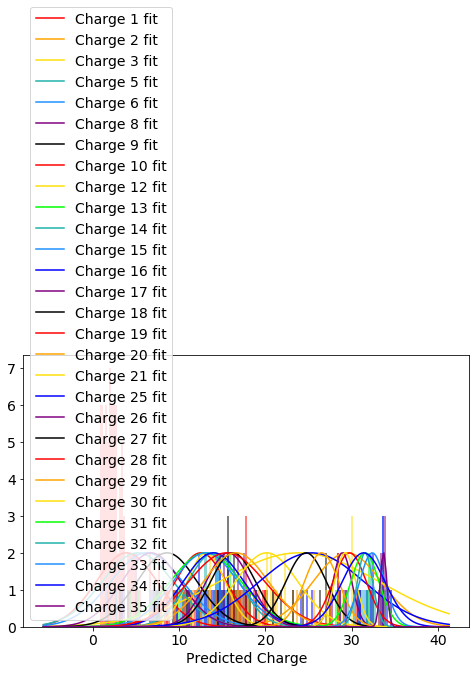

In [99]:
ShowRes(Y,CAHSingle.RPeaks["Charge"],MaxCharge=35,GaussianHeght=2)

In [100]:
CAHSingle.peaks=CAHlr.Estimate(CAHSingle.peaks)

-4.25 38.25


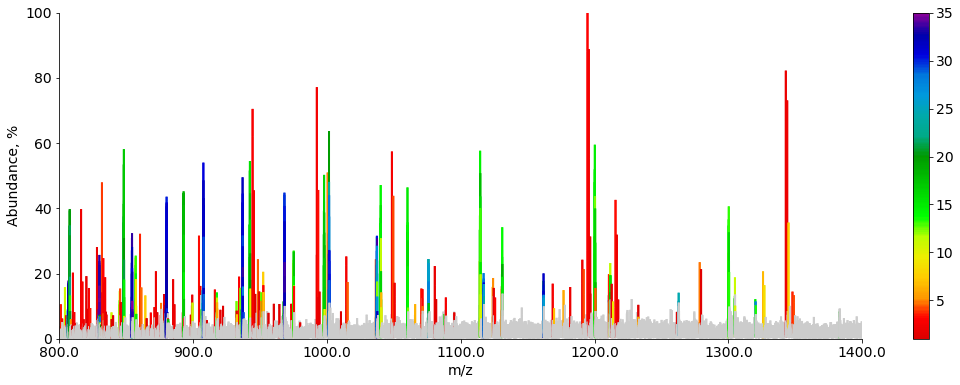

In [101]:
CAHSingle.RainbowSpectrum(800,1400,CAHSingle.peaks,maxCharge=35,LabelThres=1.,svg=True,Name="Panel4-1")

In [102]:
F4Peaks = UbiSpec.peaks[(UbiSpec.peaks["m/z"]>851) & (UbiSpec.peaks["m/z"]<854)]

In [103]:
F4Peaks

m/z   Intensity     resolution  issues
16870  851.032754   9606249.0   55483.792969   False
16871  851.051289  52104052.0  139406.593750   False
16872  851.064619  18111110.0  155385.812500   False
16873  851.079168  12037622.0  112764.273438   False
16874  851.124609  13811067.0   93195.531250   False
...           ...         ...            ...     ...
17000  853.900485   8895056.0  129270.226562    True
17001  853.936833  41210568.0  150765.968750    True
17002  853.945083  11787639.0  138793.625000    True
17003  853.964019  34028276.0   83107.250000   False
17004  853.987639  17936218.0  129813.921875   False

[135 rows x 4 columns]

In [104]:
F4Peaks=UbiSpec.SRCalc(Peaks=F4Peaks)

C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



0 LinregressResult(slope=-0.007203352284777431, intercept=2.079649822744295, rvalue=-0.002507792631379512, pvalue=0.8872324767669547, stderr=0.05079283310636913)
1 LinregressResult(slope=-3.0365606867606636, intercept=5.330295114521262, rvalue=-0.8796345952783382, pvalue=0.0, stderr=0.029035411743292227)
2 LinregressResult(slope=-2.437404857055463, intercept=4.656418892293926, rvalue=-0.8010475867915022, pvalue=0.0, stderr=0.03220826461782511)
3 LinregressResult(slope=-1.470300614290852, intercept=3.311150160199077, rvalue=-0.5045658600772772, pvalue=2.5654794079145004e-206, stderr=0.04448848469046374)
4 LinregressResult(slope=-1.9027669973227805, intercept=3.7561905936371263, rvalue=-0.7405969109401461, pvalue=0.0, stderr=0.03052819732432634)
5 LinregressResult(slope=-1.322231598726283, intercept=2.9575898075327025, rvalue=-0.47716834660764207, pvalue=1.1208032008749225e-181, stderr=0.043061842505851766)
6 LinregressResult(slope=0.14746896184520542, intercept=1.7811004505915626, rvalu

In [105]:
F4Peaks=lr.Estimate(F4Peaks)

C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


-0.875 7.875


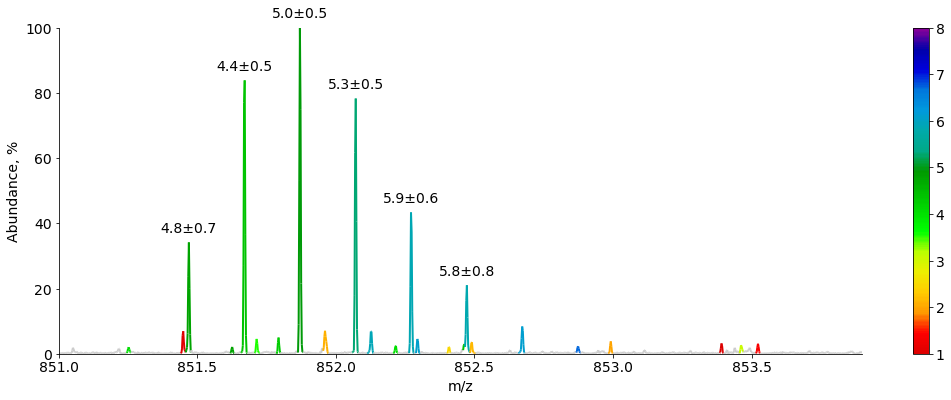

In [106]:
UbiSpec.RainbowSpectrum(851,853.9,F4Peaks,LabelThres=0.1,Name="Panel4-2",svg=True)

In [107]:
omega=50
resolution=100
tau=0.01
s=np.arange(omega*resolution*2*np.pi)/resolution

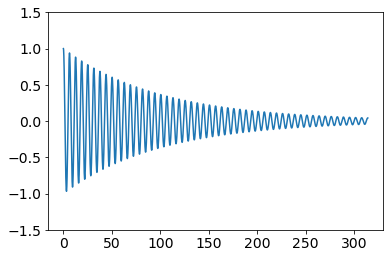

In [108]:
plt.rcParams["figure.figsize"] = (6,4)
plt.ylim(top=1.5, bottom=-1.5)
exp_sig1=np.cos(s)*np.exp(-(s*tau))
exp_sig2=np.cos(s*1.03)*np.exp(-(s*tau))
plt.plot(s,exp_sig1)
plt.savefig("Panel4-3.svg")

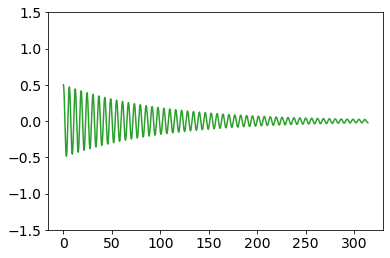

In [109]:
plt.ylim(top=1.5, bottom=-1.5)
plt.plot(s,exp_sig2*0.5,color="C2")
plt.savefig("Panel4-4.svg")

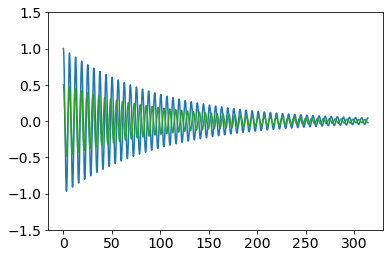

In [110]:
plt.ylim(top=1.5, bottom=-1.5)
plt.plot(s,exp_sig1,color="C0")
plt.plot(s,exp_sig2*0.5,color="C2")
plt.savefig("Panel4-5.svg")

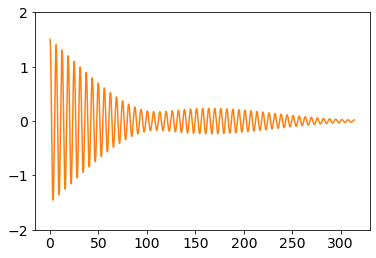

In [111]:
plt.ylim(top=2.0, bottom=-2.0)
plt.plot(s,exp_sig1+exp_sig2*0.5,color="C1")
plt.savefig("Panel4-6.svg")

In [112]:
SimTransient,IsoDistr=IsoSim("C121H201N33O36S1",4,4,1.7)

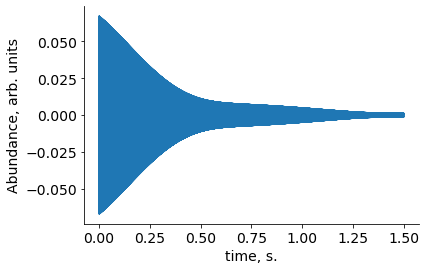

In [113]:
fig, ax = plt.subplots()
ax.set_xlabel("time, s.")
ax.set_ylabel("Abundance, arb. units")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)        
plt.plot(np.arange(6000000)/4000000.0,SimTransient)
plt.savefig("Panel4-7.svg")  

In [114]:
IsoDistr["Abu"]=100.*(IsoDistr["Prob"]/np.sum(IsoDistr["Prob"]))

C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:10: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # Remove the CWD from sys.path while we load stuff.


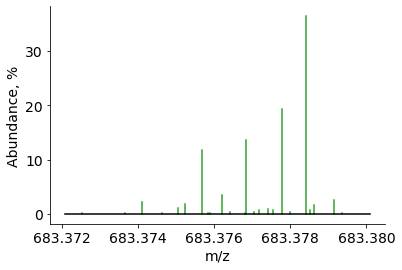

In [115]:
fig, ax = plt.subplots()
ax.set_xlabel("m/z")
ax.set_ylabel("Abundance, %")
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3f'))
ax.locator_params(axis='x',nbins=5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)        

#ax.set_xlim(811.,813.3)
ax.stem(IsoDistr["m/z"],IsoDistr["Abu"],"C2",markerfmt=" ", basefmt="black")
plt.savefig("Panel4-8.svg")

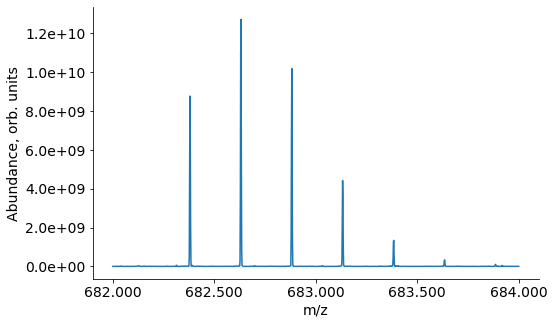

<module 'matplotlib.pyplot' from 'C:\\Users\\yaros\\Anaconda3\\envs\\tf2\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [116]:
plt.rcParams["figure.figsize"] = (8,5)
UbiSpec.plotmasskai(682,684,fname="Panel4-9.svg")

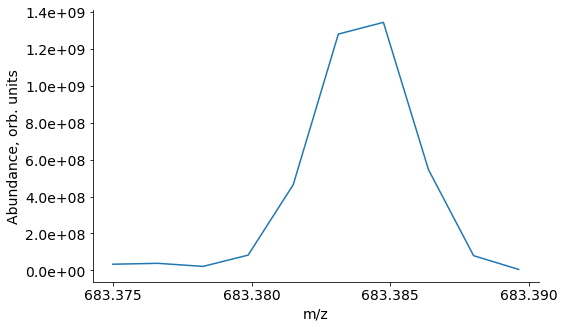

<module 'matplotlib.pyplot' from 'C:\\Users\\yaros\\Anaconda3\\envs\\tf2\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [117]:
UbiSpec.plotmasskai(683.375,683.39)

### Figure 5 CHARDA EXport

In [62]:
Proteins=[[18,19,41,"MLYVIYAQDKADSLEKRLSVRPAHLARLQLLHDEGRLLTAGPMPAVDSNDPGAAGFTGSTVIAEFESLEAAQAWADADPYVAAGVYEHVSVKPFKKVF","Protein YciI","YciI"],
           [14,14,11,"MNKTQLIDVIAEKAELSKTQAKAALESTLAAITESLKEGDAVQLVGFGTFKVNHRAERTGRNPQTGKEIKIAAANVPAFVSGKALKDAVK","DNA-binding protein HU-alpha","HU-alpha"],
           [3,11,25,"MNKSQLIDKIAAGADISKAAAGRALDAIIASVTESLKEGDDVALVGFGTFAVKERAARTGRNPQTGKEITIAAAKVPSFRAGKALKDAVN","DNA-binding protein HU-beta","HU-beta"],
           [69,35,68,"S[+42.01056]ITKDQIIEAVAAMSVMDVVELISAMEEKFGVSAAAAVAVAAGPVEAAEEKTEFDVILKAAGANKVAVIKAVRGATGLGLKEAKDLVESAPAALKEGVSKDDAEALKKALEEAGAEVEVK","50S ribosomal protein L7-L12","50S L7-L12"],
           [16,16,39,"AKIKGQVKWFNESKGFGFITPADGSKDVFVHFSAIQGNGFKTLAEGQNVEFEIQDGQKGPAAVNVTAI","Cold shock-like protein CspC","CspC"]]

In [89]:
FullSp=FullSpectrum(np.loadtxt("DNA-binding protein HU-beta_std_pept.csv",skiprows=2)[1000:]+np.loadtxt("DNA-binding protein HU-beta_std_prot.csv",skiprows=2)[1000:])

In [71]:
MonoSp=TransSpectrum(np.loadtxt("DNA-binding protein HU-beta_mono_pept.csv",skiprows=2)[1000:])

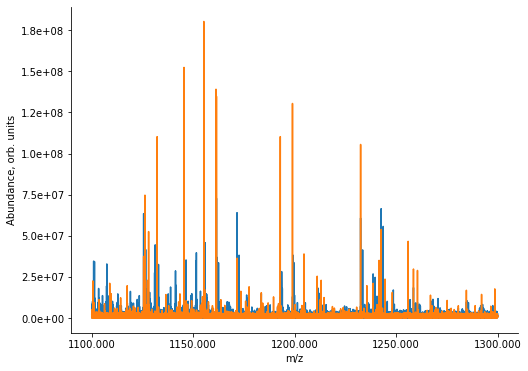

In [91]:
fig, ax = plt.subplots()
FullSp.plotmasskai(1100,1300,PlotTo=ax)
MonoSp.plotmasskai(1100,1300,PlotTo=ax)
plt.show()

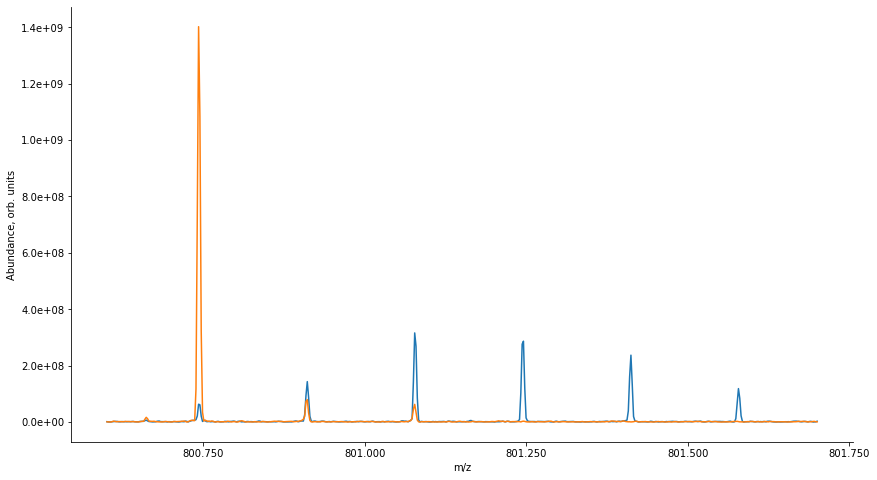

In [92]:
plt.rcParams["figure.figsize"] = (14,8)
fig, ax = plt.subplots()
FullSp.plotmasskai(800.6,801.7,PlotTo=ax)
MonoSp.plotmasskai(800.6,801.7,PlotTo=ax)
plt.savefig("Panel5-1.svg")
plt.show()

In [93]:
AllPeaks=pd.DataFrame()
for i in range(5):
    trans=LoadAvgTrans(lcmf_std_pept,lcmsms_std_pept,NumbersOI[i][1])
    Spec=FullSpectrum(trans)
    Spec.A = 2.117721546870e+14
    #Spec.peaks=pd.read_csv("FullIons.{}.txt".format(i),sep="\t")    
    Spec.PeakPick(250,2500)
    Spec.CheckIssues()
    Spec.RunHardKlor(charge_min=1,charge_max=10)
    Spec.Products(NumbersOI[i][3],ppm=20)
    Spec.PeakstoClusters()  
    Spec.RPeaks=Spec.RPeaks[~Spec.RPeaks["issues"]]
    Spec.RPeaks=Spec.RPeaks[Spec.RPeaks['Ions']!=""]
    Spec.RPeaks["Spectrum"]=i
    Spec.TDACalc()
    print(i)
    AllPeaks = AllPeaks.append(Spec.RPeaks,ignore_index=True)

C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

0 LinregressResult(slope=-0.15800337772613063, intercept=-0.3408432476532389, rvalue=-0.05548168526364087, pvalue=0.0016911499415493986, stderr=0.05028147855063745)
1 LinregressResult(slope=-0.6914270996998221, intercept=0.3531845625556346, rvalue=-0.33073272386607233, pvalue=1.5271615048942744e-82, stderr=0.03488793090219718)
2 LinregressResult(slope=-0.7021443019500104, intercept=0.11488465846581525, rvalue=-0.5595028528209994, pvalue=4.479977640503967e-263, stderr=0.018392868999484696)
3 LinregressResult(slope=-0.09081723806640221, intercept=-0.8506689969363046, rvalue=-0.029767132400193252, pvalue=0.09225929524613241, stderr=0.05392616864413587)
4 LinregressResult(slope=0.06539305899191729, intercept=-0.13596276370204682, rvalue=0.041433472562881, pvalue=0.01908216507502698, stderr=0.02788482905212057)
5 LinregressResult(slope=-0.38323274729867923, intercept=2.0018153059651174, rvalue=-0.7693023513681068, pvalue=0.0, stderr=0.0056279332041796835)
6 LinregressResult(slope=0.03233918

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\IPython\core\interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-93-bdfce55824fe>", line 15, in <module>
    Spec.SRCalc()
  File "<string>", line 16, in SRCalc
  File "<string>", line 5, in taucalckai
  File "<__array_function__ internals>", line 6, in ifft
  File "C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\numpy\fft\_pocketfft.py", line 281, in ifft
    output = _raw_fft(a, n, axis, False, False, inv_norm)
  File "C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\numpy\fft\_pocketfft.py", line 74, in _raw_fft
    r = pfi.execute(a, is_real, is_forward, fct)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\IPython\core\interactiveshell.py", line 2044, in showtraceback
    stb = va

KeyboardInterrupt: 

In [214]:
AllPeaks=AllPeaks[AllPeaks["RSquare"]<-0.85]

In [215]:
AllPeaks=AllPeaks[np.isin(AllPeaks["Charge"],[1,2,3,4,5,6,7])]

In [217]:
plt.rcParams["figure.figsize"] = (12,7)

In [216]:
Fulllr=LogisticReg(AllPeaks)
Y,Y_Distr=Fulllr.Apply(AllPeaks)

1 60 (2.264284043817135, 0.6674097117460813)
2 122 (2.8790993137673087, 0.8656056790468396)
3 100 (3.6524747771977673, 0.9976708306553789)
4 78 (4.008226448872093, 1.0432302822436925)
5 99 (4.40250858974515, 0.966207277457114)
6 115 (5.4852420748224455, 0.7557527219078963)
7 82 (5.406737814658018, 1.1198533431123734)
3.2430907401166147


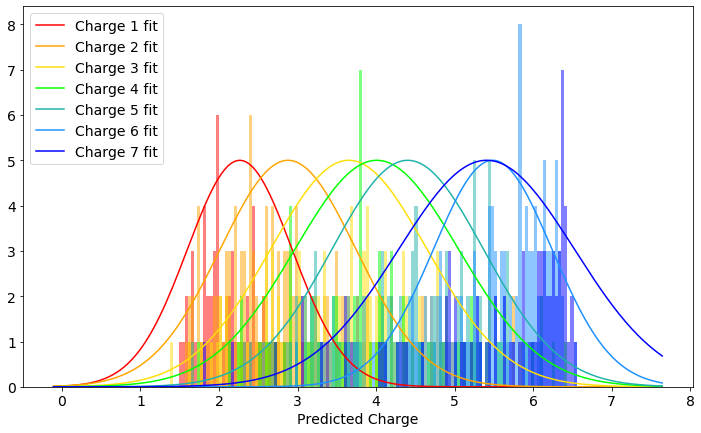

In [218]:
ShowRes(Y,AllPeaks["Charge"],MaxCharge=7,GaussianHeght=5)

In [219]:
Fullmlr=MassLogisticReg(AllPeaks)
AllPeaks.reset_index(inplace=True, drop=True)
Y,Y_Distr=Fullmlr.Apply(AllPeaks)

1 60 (1.8357178665906764, 0.6753996852747159)
2 122 (2.5432900549839204, 0.8223182511684897)
3 100 (3.6744527526578903, 0.8095566318561388)
4 78 (4.117142990581952, 0.9126721183897032)
5 99 (4.728877297884229, 0.873428636961225)
6 115 (5.556991403491003, 0.7875790070848139)
7 82 (5.522862159016754, 1.2192114966036238)
3.410857121613525


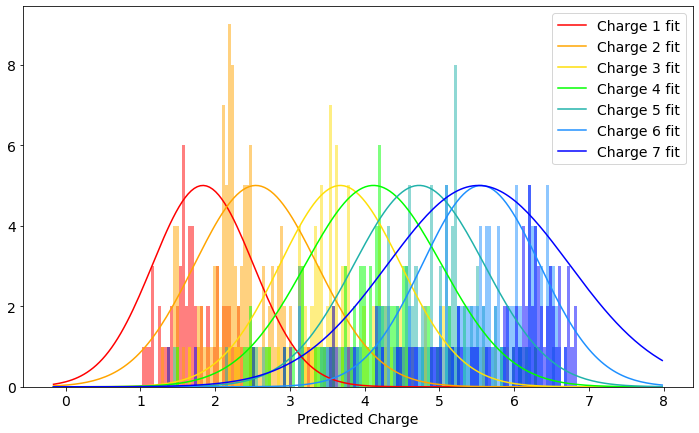

In [220]:
ShowRes(Y,AllPeaks["Charge"],MaxCharge=7,GaussianHeght=5,fname="Panel5-2.svg")

In [143]:
AllIonPeaks=pd.DataFrame()
for i in range(5):
    trans=LoadAvgTrans(lcmf_std_pept,lcmsms_std_pept,NumbersOI[i][1])+LoadAvgTrans(lcmf_std_prot,lcmsms_std_prot,NumbersOI[i][2])
    Spec=FullSpectrum(trans)
    Spec.A = 2.117721546870e+14
    #Spec.peaks=pd.read_csv("FullIons.{}.txt".format(i),sep="\t")
    Spec.PeakPick(250,2500)
    Spec.CheckIssues()
    Spec.RunHardKlor(charge_min=1,charge_max=10)
    Spec.Products(NumbersOI[i][3],ppm=20)
    Spec.PeakstoClusters()  
    Spec.RPeaks=Spec.RPeaks[~Spec.RPeaks["issues"]]
    Spec.RPeaks=Spec.RPeaks[Spec.RPeaks['Ions']!=""]
    Spec.RPeaks["Spectrum"]=i
    
    trans=LoadAvgTrans(lcmf_mono_pept,lcmsms_mono_pept,NumbersOI[i][0])
    MSpec = TransSpectrum(trans)
    MSpec.A = 2.117721546870e+14
    MSpec.PeakPick(250,2500)
    MSpec.CheckIssues()
    MSpec.peaks = MSpec.peaks[~MSpec.peaks["issues"]]
    #MSpec.peaks=pd.read_csv("MonoIons.{}.txt".format(i),sep="\t")
    
    IonClusters=Spec.Clusters[(Spec.Clusters["Ions"] != "") & (Spec.Clusters["PPMError"] > -14) & (Spec.Clusters["PPMError"] < -7)]
    IonClusters["Mono m/z"]=(IonClusters["Mass"]/IonClusters["Charge"])+Proton
    IonClusters["m/z"]=0.
    IonClusters["Intensity"]=0.
    IonClusters["resolution"]=0.
    
    
    for row in IonClusters.iterrows():
        ppmlow=row[1]["Mono m/z"]-row[1]["Mono m/z"]/100000
        ppmhigh=row[1]["Mono m/z"]+row[1]["Mono m/z"]/100000
        localpeak=MSpec.peaks[(MSpec.peaks["m/z"]>ppmlow) & (MSpec.peaks["m/z"]<ppmhigh)]
        if len(localpeak) != 0: 
            IonClusters.at[row[0],"m/z"]=localpeak.at[localpeak["Intensity"].idxmax(),"m/z"]
            IonClusters.at[row[0],"Intensity"]=localpeak.at[localpeak["Intensity"].idxmax(),"Intensity"]
            IonClusters.at[row[0],"resolution"]=localpeak.at[localpeak["Intensity"].idxmax(),"resolution"]
        else:
            IonClusters.at[row[0],"m/z"]=0.
    IonClusters=IonClusters[IonClusters["m/z"]>0.]
    IonClusters = MSpec.SRCalc(Peaks = IonClusters)
    IonClusters.reset_index(inplace=True,drop=True)
    AllIonPeaks = AllIonPeaks.append(IonClusters,ignore_index=True)

C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

0 LinregressResult(slope=-0.8115966410305145, intercept=2.7686020956315005, rvalue=-0.9535856503774657, pvalue=0.0, stderr=0.004531934945160011)
1 LinregressResult(slope=-0.9392896507470448, intercept=2.8188037100445085, rvalue=-0.9616724028658822, pvalue=0.0, stderr=0.004735896383835362)
2 LinregressResult(slope=-0.5670165612201212, intercept=4.322937845365917, rvalue=-0.9981993686805387, pvalue=0.0, stderr=0.0006025193957177441)
3 LinregressResult(slope=-0.5312924991832769, intercept=2.641908890925697, rvalue=-0.8205227742216319, pvalue=0.0, stderr=0.0065449532262082085)
4 LinregressResult(slope=-0.5605638532525492, intercept=3.7149917457006785, rvalue=-0.9924779154923173, pvalue=0.0, stderr=0.001222730852705043)
5 LinregressResult(slope=-0.7030375078483342, intercept=2.0723660194755427, rvalue=-0.6939801868195415, pvalue=0.0, stderr=0.012897963113920947)
6 LinregressResult(slope=-1.8268125233359866, intercept=2.3497270944425965, rvalue=-0.9396311372251073, pvalue=0.0, stderr=0.01176

In [207]:
AllIonPeaks=AllIonPeaks[AllIonPeaks["RSquare"]<-0.85]
AllIonPeaks=AllIonPeaks[np.isin(AllIonPeaks["Charge"],[1,2,3,4,5,6,7])]

In [208]:
AllIonPeaks.reset_index(inplace=True,drop=True)
Monolr=LogisticReg(AllIonPeaks)
AllIonPeaks.reset_index(inplace=True, drop=True)
Y,Y_Distr=Monolr.Apply(AllIonPeaks)

1 91 (1.6138195718133774, 0.41440809229404635)
2 105 (2.115724024649248, 0.6724957684094848)
3 70 (2.8347924521507175, 0.6806023303364463)
4 51 (3.446382956102955, 0.8516494465050013)
5 40 (4.738388272944666, 0.7191131248084066)
6 34 (5.885327810034286, 0.6540653459683191)
7 22 (6.370623744387756, 0.6151357611400011)
4.51588282608402


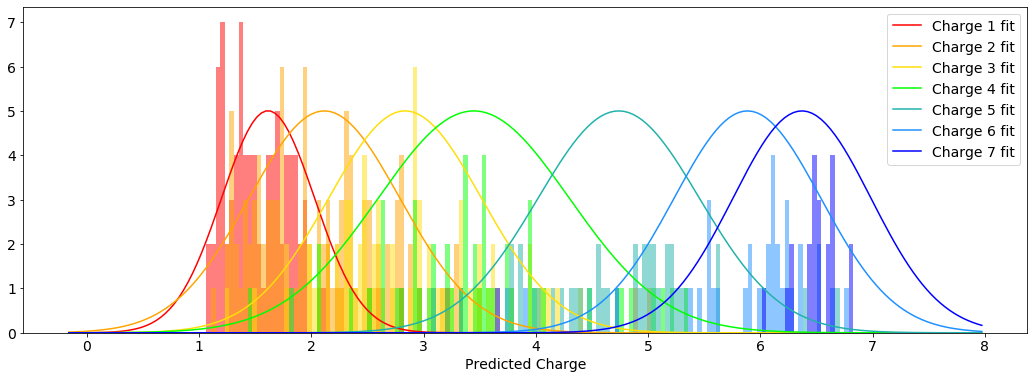

In [209]:
ShowRes(Y,AllIonPeaks["Charge"],MaxCharge=7,GaussianHeght=5)

In [210]:
Monomlr=MassLogisticReg(AllIonPeaks)
Y,Y_Distr=Monomlr.Apply(AllIonPeaks)

1 91 (1.4437413347306727, 0.3766270229007873)
2 105 (2.0837272028657017, 0.6108352477678743)
3 70 (2.9691187328753728, 0.44150461922929257)
4 51 (3.701073458958439, 0.6800583572924374)
5 40 (4.771923285318882, 0.6768533402565463)
6 34 (5.921648226464604, 0.5772007401641088)
7 22 (6.542002793927631, 0.5121869296764389)
5.369126319017246


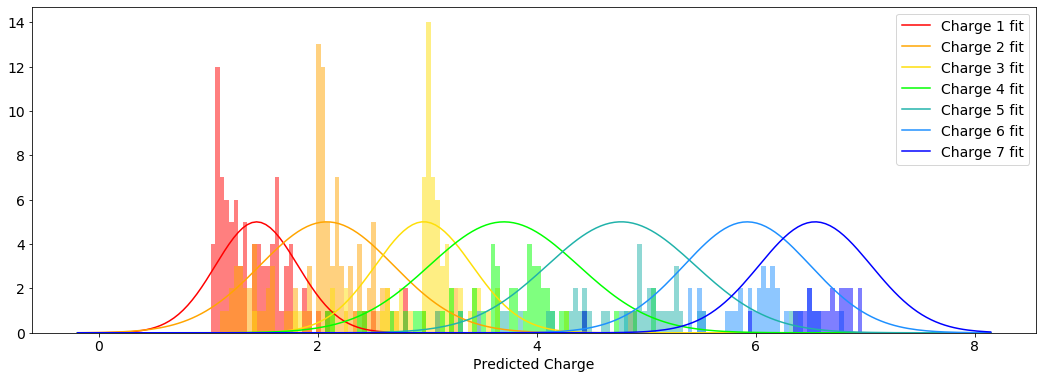

In [211]:
ShowRes(Y,AllIonPeaks["Charge"],MaxCharge=7,GaussianHeght=5,fname="Panel5-3.svg")

### Figure 5

In [75]:
FullSp = FullSpectrum(LoadAvgTrans(lcmf_std_pept,lcmsms_std_pept,11)+LoadAvgTrans(lcmf_std_prot,lcmsms_std_prot,25))

In [119]:
MonoSp= TransSpectrum(LoadAvgTrans(lcmf_mono_pept,lcmsms_mono_pept,3))

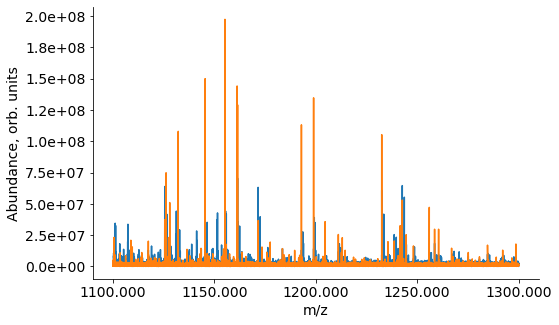

In [120]:
fig, ax = plt.subplots()
FullSp.plotmasskai(1100,1300,PlotTo=ax)
MonoSp.plotmasskai(1100,1300,PlotTo=ax)
plt.show()

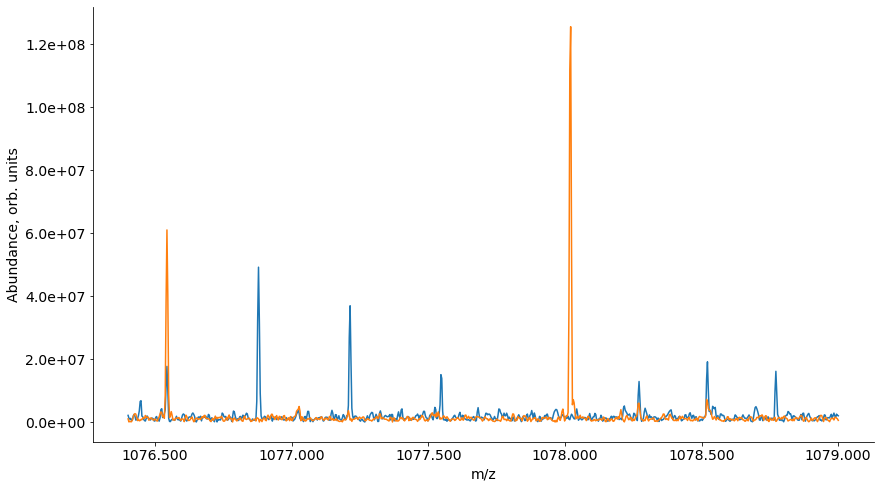

In [121]:
plt.rcParams["figure.figsize"] = (14,8)
fig, ax = plt.subplots()
FullSp.plotmasskai(1076.4,1079,PlotTo=ax)
MonoSp.plotmasskai(1076.4,1079,PlotTo=ax)
plt.savefig("Panel5-1 var1.svg")
plt.show()

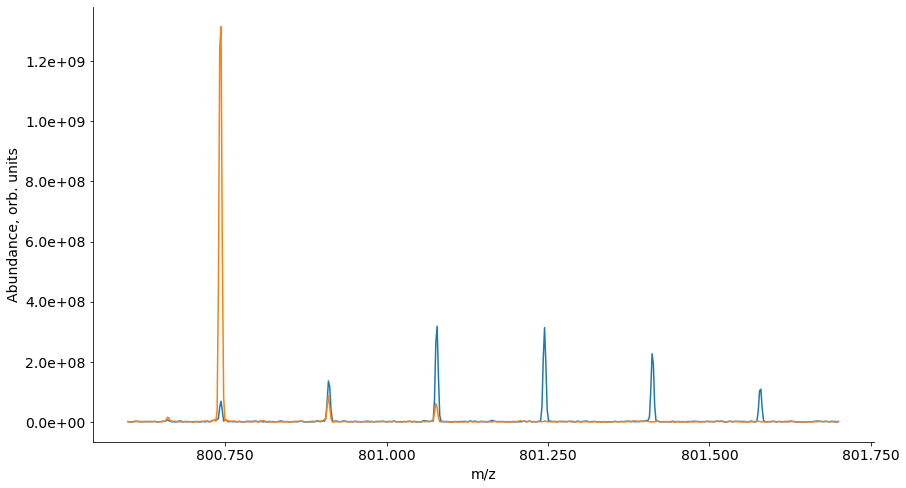

In [122]:
plt.rcParams["figure.figsize"] = (14,8)
fig, ax = plt.subplots()
FullSp.plotmasskai(800.6,801.7,PlotTo=ax)
MonoSp.plotmasskai(800.6,801.7,PlotTo=ax)
plt.savefig("Panel5-1.svg")
plt.show()

In [123]:
#here have to be code which is generating FullIons.N.txt files

In [124]:
#AllPeaks=pd.DataFrame()
#for i in range(5):
#    trans=LoadAvgTrans(lcmf_std_pept,lcmsms_std_pept,NumbersOI[i][1])
#    Spec=FullSpectrum(trans)
#    Spec.peaks=pd.read_csv("FullIons.{}.txt".format(i),sep="\t")    
#    Spec.CheckIssues()
#    Spec.RunHardKlor(charge_min=1,charge_max=10)
#    Spec.Products(NumbersOI[i][3],ppm=20)
#    Spec.PeakstoClusters()  
#    Spec.RPeaks=Spec.RPeaks[~Spec.RPeaks["issues"]]
#    Spec.RPeaks=Spec.RPeaks[Spec.RPeaks['Ions']!=""]
#    Spec.RPeaks["Spectrum"]=i
#    AllPeaks = AllPeaks.append(Spec.RPeaks,ignore_index=True)

In [125]:
AllPeaks=pd.DataFrame()
for i in range(5):
    trans=LoadAvgTrans(lcmf_std_pept,lcmsms_std_pept,NumbersOI[i][1])
    Spec=FullSpectrum(trans)
    Spec.A = 2.117721546870e+14
    #Spec.peaks=pd.read_csv("FullIons.{}.txt".format(i),sep="\t")    
    Spec.PeakPick(250,2500)
    Spec.CheckIssues()
    Spec.RunHardKlor(charge_min=1,charge_max=10)
    Spec.Products(NumbersOI[i][3],ppm=20)
    Spec.PeakstoClusters()  
    Spec.RPeaks=Spec.RPeaks[~Spec.RPeaks["issues"]]
    Spec.RPeaks=Spec.RPeaks[Spec.RPeaks['Ions']!=""]
    Spec.RPeaks["Spectrum"]=i
    Spec.SRCalc()
    AllPeaks = AllPeaks.append(Spec.RPeaks,ignore_index=True)

C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

0 LinregressResult(slope=-0.15800337772613063, intercept=-0.3408432476532389, rvalue=-0.05548168526364087, pvalue=0.0016911499415493986, stderr=0.05028147855063745)
1 LinregressResult(slope=-0.6914270996998221, intercept=0.3531845625556346, rvalue=-0.33073272386607233, pvalue=1.5271615048942744e-82, stderr=0.03488793090219718)
2 LinregressResult(slope=-0.7021443019500104, intercept=0.11488465846581525, rvalue=-0.5595028528209994, pvalue=4.479977640503967e-263, stderr=0.018392868999484696)
3 LinregressResult(slope=-0.09081723806640221, intercept=-0.8506689969363046, rvalue=-0.029767132400193252, pvalue=0.09225929524613241, stderr=0.05392616864413587)
4 LinregressResult(slope=0.06539305899191729, intercept=-0.13596276370204682, rvalue=0.041433472562881, pvalue=0.01908216507502698, stderr=0.02788482905212057)
5 LinregressResult(slope=-0.38323274729867923, intercept=2.0018153059651174, rvalue=-0.7693023513681068, pvalue=0.0, stderr=0.0056279332041796835)
6 LinregressResult(slope=0.03233918

In [221]:
AllPeaks

m/z    Intensity     resolution  issues  cluster  number  \
0     756.079255   8391901.00  169788.875000   False      901       1   
1     774.921506   3654325.00  109981.437500   False      933       2   
2     775.088751   6113285.50  165244.218750   False      933       3   
3     775.257679   5047574.00  144269.890625   False      933       4   
4     882.486518   3674084.25  160618.093750   False     1126       0   
..           ...          ...            ...     ...      ...     ...   
651  1352.080743   5490160.00  112190.492188   False     1944       5   
652  1422.958214  12142625.00  117392.906250   False     2058       2   
653  1423.208912  23878432.00  120166.734375   False     2058       3   
654  1423.459794  24282708.00  112905.687500   False     2058       4   
655  1512.250135   4018200.00  121463.265625   False     2212       3   

         rest    intensity       Mass  Charge  ...   PPMError  Shift  \
0   -0.000819   8391901.00  2264.2134       3  ...  -9.879830      0   
1   -0.002532   3654325.00  4641.4812       6  ... -11.158082      0   
2   -0.002416   6113285.50  4641.4812       6  ... -11.158082      0   
3    0.007797   5047574.00  4641.4812       6  ... -11.158082      0   
4   -0.001017   3674084.25  1762.9595       2  ...  -9.945760      0   
..        ...          ...        ...     ...  ...        ...    ...   
651  0.002356   5490160.00  6750.3482       5  ... -12.115352      0   
652 -0.002858  12142625.00  5685.7999       4  ... -12.068589      0   
653 -0.003422  23878432.00  5685.7999       4  ... -12.068589      0   
654 -0.003248  24282708.00  5685.7999       4  ... -12.068589      0   
655  0.006768   4018200.00  6041.9546       4  ... -13.821027      0   

       TheorMass  Spectrum     Slope  Intercept   RSquare     Ratio      FWHM  \
0    2264.235770         0 -0.893918   2.155742 -0.860947  1.771893  0.004453   
1    4641.532991         0 -3.172294   2.741159 -0.905558  3.454198  0.007046   
2    4641.532991         0 -2.253642   2.849180 -0.960899  5.174930  0.004691   
3    4641.532991         0 -2.635458   2.783561 -0.949724  3.816766  0.005374   
4    1762.977034         0 -1.259697   1.570468 -0.910077  2.137386  0.005494   
..           ...       ...       ...        ...       ...       ...       ...   
651  6750.429984         4 -0.987408   1.877824 -0.937738  2.121411  0.012052   
652  5685.868520         4 -1.681689   3.019350 -0.892716  1.873271  0.012121   
653  5685.868520         4 -1.810533   3.822308 -0.981511  3.710666  0.011844   
654  5685.868520         4 -1.658355   3.766462 -0.958643  5.036012  0.012608   
655  6042.038107         4 -1.233804   1.661852 -0.966751  1.329864  0.012450   

     FWHM Coeff  
0      1.193732  
1      1.581455  
2      1.205497  
3      1.319565  
4      1.176514  
..          ...  
651    1.296289  
652    1.236463  
653    1.217292  
654    1.268858  
655    1.184408  

[656 rows x 25 columns]

In [134]:
AllPeaksFull = AllPeaks

In [213]:
AllPeaks = AllPeaksFull

In [214]:
AllPeaks=AllPeaks[AllPeaks["RSquare"]<-0.85]

In [215]:
AllPeaks=AllPeaks[np.isin(AllPeaks["Charge"],[1,2,3,4,5,6,7])]

In [216]:
Fulllr=LogisticReg(AllPeaks)
Y,Y_Distr=Fulllr.Apply(AllPeaks)

In [217]:
plt.rcParams["figure.figsize"] = (12,7)

1 60 (2.264284043817135, 0.6674097117460813)
2 122 (2.8790993137673087, 0.8656056790468396)
3 100 (3.6524747771977673, 0.9976708306553789)
4 78 (4.008226448872093, 1.0432302822436925)
5 99 (4.40250858974515, 0.966207277457114)
6 115 (5.4852420748224455, 0.7557527219078963)
7 82 (5.406737814658018, 1.1198533431123734)
3.2430907401166147


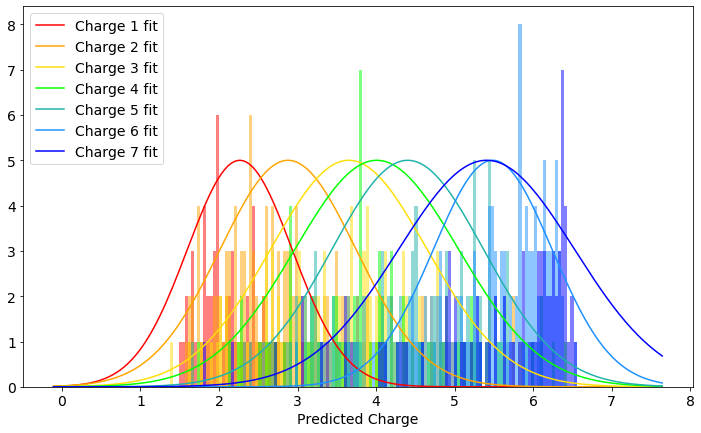

In [218]:
ShowRes(Y,AllPeaks["Charge"],MaxCharge=7,GaussianHeght=5)

In [219]:
Fullmlr=MassLogisticReg(AllPeaks)
AllPeaks.reset_index(inplace=True, drop=True)
Y,Y_Distr=Fullmlr.Apply(AllPeaks)

1 60 (1.8357178665906764, 0.6753996852747159)
2 122 (2.5432900549839204, 0.8223182511684897)
3 100 (3.6744527526578903, 0.8095566318561388)
4 78 (4.117142990581952, 0.9126721183897032)
5 99 (4.728877297884229, 0.873428636961225)
6 115 (5.556991403491003, 0.7875790070848139)
7 82 (5.522862159016754, 1.2192114966036238)
3.410857121613525


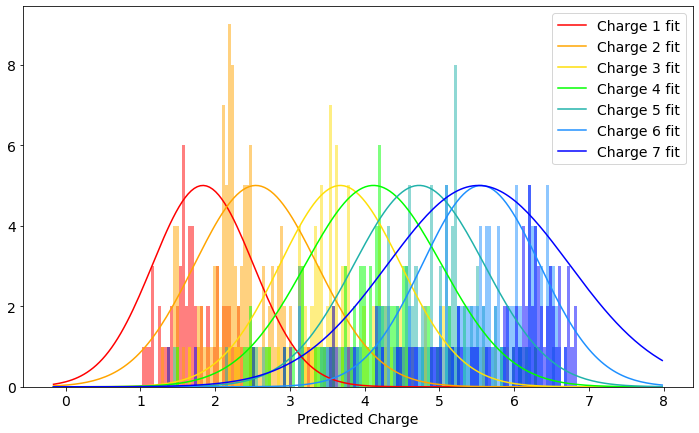

In [220]:
ShowRes(Y,AllPeaks["Charge"],MaxCharge=7,GaussianHeght=5,fname="Panel5-2.svg")

In [143]:
AllIonPeaks=pd.DataFrame()
for i in range(5):
    trans=LoadAvgTrans(lcmf_std_pept,lcmsms_std_pept,NumbersOI[i][1])+LoadAvgTrans(lcmf_std_prot,lcmsms_std_prot,NumbersOI[i][2])
    Spec=FullSpectrum(trans)
    Spec.A = 2.117721546870e+14
    #Spec.peaks=pd.read_csv("FullIons.{}.txt".format(i),sep="\t")
    Spec.PeakPick(250,2500)
    Spec.CheckIssues()
    Spec.RunHardKlor(charge_min=1,charge_max=10)
    Spec.Products(NumbersOI[i][3],ppm=20)
    Spec.PeakstoClusters()  
    Spec.RPeaks=Spec.RPeaks[~Spec.RPeaks["issues"]]
    Spec.RPeaks=Spec.RPeaks[Spec.RPeaks['Ions']!=""]
    Spec.RPeaks["Spectrum"]=i
    
    trans=LoadAvgTrans(lcmf_mono_pept,lcmsms_mono_pept,NumbersOI[i][0])
    MSpec = TransSpectrum(trans)
    MSpec.A = 2.117721546870e+14
    MSpec.PeakPick(250,2500)
    MSpec.CheckIssues()
    MSpec.peaks = MSpec.peaks[~MSpec.peaks["issues"]]
    #MSpec.peaks=pd.read_csv("MonoIons.{}.txt".format(i),sep="\t")
    
    IonClusters=Spec.Clusters[(Spec.Clusters["Ions"] != "") & (Spec.Clusters["PPMError"] > -14) & (Spec.Clusters["PPMError"] < -7)]
    IonClusters["Mono m/z"]=(IonClusters["Mass"]/IonClusters["Charge"])+Proton
    IonClusters["m/z"]=0.
    IonClusters["Intensity"]=0.
    IonClusters["resolution"]=0.
    
    
    for row in IonClusters.iterrows():
        ppmlow=row[1]["Mono m/z"]-row[1]["Mono m/z"]/100000
        ppmhigh=row[1]["Mono m/z"]+row[1]["Mono m/z"]/100000
        localpeak=MSpec.peaks[(MSpec.peaks["m/z"]>ppmlow) & (MSpec.peaks["m/z"]<ppmhigh)]
        if len(localpeak) != 0: 
            IonClusters.at[row[0],"m/z"]=localpeak.at[localpeak["Intensity"].idxmax(),"m/z"]
            IonClusters.at[row[0],"Intensity"]=localpeak.at[localpeak["Intensity"].idxmax(),"Intensity"]
            IonClusters.at[row[0],"resolution"]=localpeak.at[localpeak["Intensity"].idxmax(),"resolution"]
        else:
            IonClusters.at[row[0],"m/z"]=0.
    IonClusters=IonClusters[IonClusters["m/z"]>0.]
    IonClusters = MSpec.SRCalc(Peaks = IonClusters)
    IonClusters.reset_index(inplace=True,drop=True)
    AllIonPeaks = AllIonPeaks.append(IonClusters,ignore_index=True)

C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

0 LinregressResult(slope=-0.8115966410305145, intercept=2.7686020956315005, rvalue=-0.9535856503774657, pvalue=0.0, stderr=0.004531934945160011)
1 LinregressResult(slope=-0.9392896507470448, intercept=2.8188037100445085, rvalue=-0.9616724028658822, pvalue=0.0, stderr=0.004735896383835362)
2 LinregressResult(slope=-0.5670165612201212, intercept=4.322937845365917, rvalue=-0.9981993686805387, pvalue=0.0, stderr=0.0006025193957177441)
3 LinregressResult(slope=-0.5312924991832769, intercept=2.641908890925697, rvalue=-0.8205227742216319, pvalue=0.0, stderr=0.0065449532262082085)
4 LinregressResult(slope=-0.5605638532525492, intercept=3.7149917457006785, rvalue=-0.9924779154923173, pvalue=0.0, stderr=0.001222730852705043)
5 LinregressResult(slope=-0.7030375078483342, intercept=2.0723660194755427, rvalue=-0.6939801868195415, pvalue=0.0, stderr=0.012897963113920947)
6 LinregressResult(slope=-1.8268125233359866, intercept=2.3497270944425965, rvalue=-0.9396311372251073, pvalue=0.0, stderr=0.01176

In [145]:
FullAllIonPeaks = AllIonPeaks

In [206]:
AllIonPeaks=FullAllIonPeaks

In [207]:
AllIonPeaks=AllIonPeaks[AllIonPeaks["RSquare"]<-0.85]
AllIonPeaks=AllIonPeaks[np.isin(AllIonPeaks["Charge"],[1,2,3,4,5,6,7])]

In [208]:
AllIonPeaks.reset_index(inplace=True,drop=True)
Monolr=LogisticReg(AllIonPeaks)
AllIonPeaks.reset_index(inplace=True, drop=True)
Y,Y_Distr=Monolr.Apply(AllIonPeaks)

1 91 (1.6138195718133774, 0.41440809229404635)
2 105 (2.115724024649248, 0.6724957684094848)
3 70 (2.8347924521507175, 0.6806023303364463)
4 51 (3.446382956102955, 0.8516494465050013)
5 40 (4.738388272944666, 0.7191131248084066)
6 34 (5.885327810034286, 0.6540653459683191)
7 22 (6.370623744387756, 0.6151357611400011)
4.51588282608402


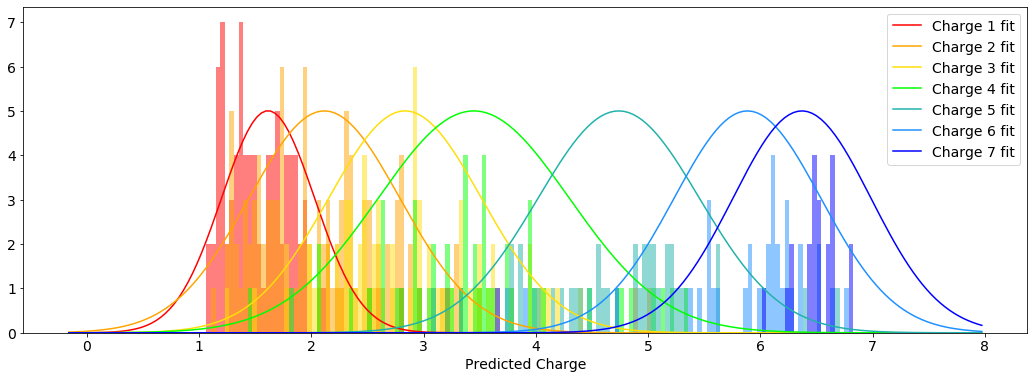

In [209]:
ShowRes(Y,AllIonPeaks["Charge"],MaxCharge=7,GaussianHeght=5,fname="Panel5-5.svg")

In [210]:
Monomlr=MassLogisticReg(AllIonPeaks)
Y,Y_Distr=Monomlr.Apply(AllIonPeaks)

1 91 (1.4437413347306727, 0.3766270229007873)
2 105 (2.0837272028657017, 0.6108352477678743)
3 70 (2.9691187328753728, 0.44150461922929257)
4 51 (3.701073458958439, 0.6800583572924374)
5 40 (4.771923285318882, 0.6768533402565463)
6 34 (5.921648226464604, 0.5772007401641088)
7 22 (6.542002793927631, 0.5121869296764389)
5.369126319017246


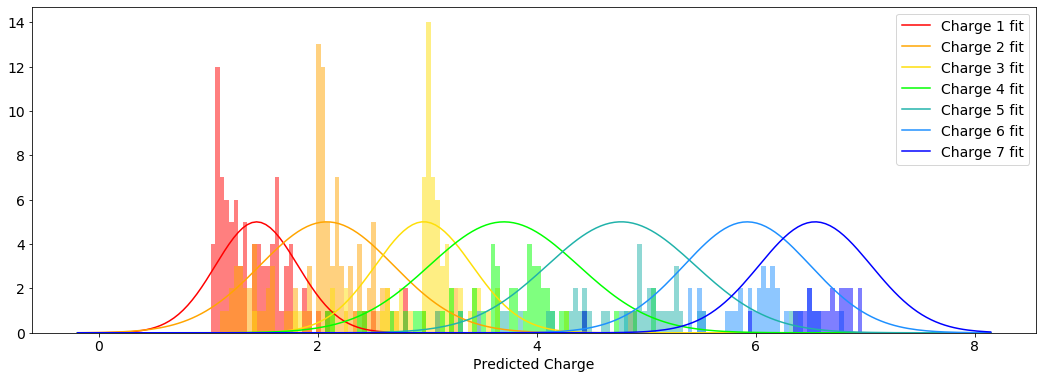

In [211]:
ShowRes(Y,AllIonPeaks["Charge"],MaxCharge=7,GaussianHeght=5,fname="Panel5-3.svg")

### Figure S2

In [152]:
labels=FRes[(FRes["Ions"]=="y37")&(FRes["Charge"]==6)][["m/z","Slope"]]
labels = list(zip(list(labels["m/z"]),list(-labels["Slope"])))

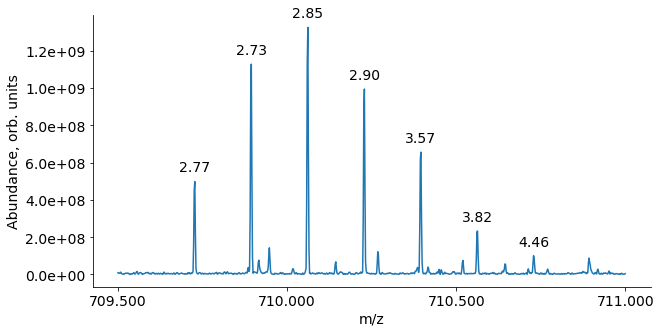

<module 'matplotlib.pyplot' from 'C:\\Users\\yaros\\Anaconda3\\envs\\tf2\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [153]:
plt.rcParams["figure.figsize"] = (10,5)
UbiSpec.plotmasskai(709.5,711,labels=labels,fname="PanelS2-1.svg")

C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays 

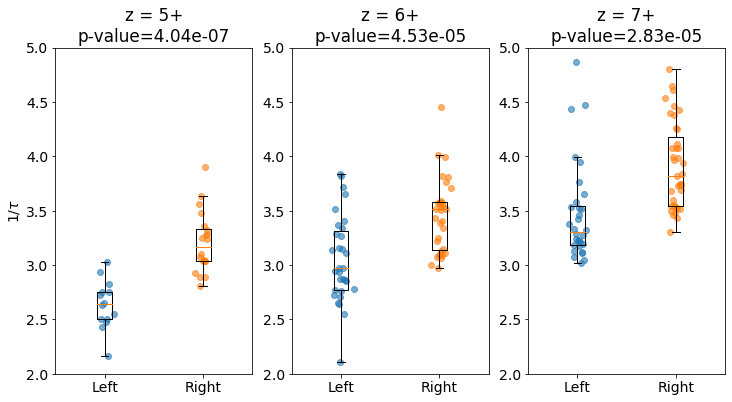

In [154]:
plt.rcParams["figure.figsize"] = (12,6)
Fig, (ax1,ax2,ax3) = plt.subplots(1,3)
plots=[ax1,ax2,ax3]
for charge in [5,6,7]:
    FResLefts=pd.DataFrame()
    FResRights=pd.DataFrame()
    FResPart = FRes[FRes["Charge"]==charge]
    #loop over isotopic clusters
    for ion in np.unique(FResPart["Ions"]):
        #Get m/z value of maximal signal in isotopic cluster
        MassMax=FResPart.loc[(FResPart[FResPart["Ions"]==ion]["intensity"].idxmax())]["m/z"]
        #Get left part of the cluster including peak pf maximum intensity (also filter by intensity to diminish intensity dependence)
        FResLefts=FResLefts.append(FResPart[(FResPart["Ions"]==ion)&(FResPart["m/z"]<=MassMax)&(FResPart["Intensity"]<=1.0e09)]) 
        #Get right part of the cluster
        FResRights=FResRights.append(FResPart[(FResPart["Ions"]==ion)&(FResPart["m/z"]>MassMax)&(FResPart["Intensity"]<=1.0e09)]) 
    Lefts=list(-FResLefts["Slope"])
    Rights=list(-FResRights["Slope"])
    stat,pvalue=stats.ttest_ind(Lefts,Rights)
    plots[charge-5].set_title("z = {}+\np-value={:.2e}".format(charge,pvalue))
    plots[charge-5].set_ylim(2,5)
    plots[charge-5].boxplot([Lefts,Rights],labels=["Left","Right"],showfliers=False)
    #plot points over box plot
    xs = np.random.normal( 1, 0.04, len(Lefts)) #jitter for value points - left part 
    plots[charge-5].scatter(xs,Lefts,color="C0",alpha=0.6)
    xs = np.random.normal( 2, 0.04, len(Rights)) #jitter for value points - right part
    plots[charge-5].scatter(xs,Rights,color="C1",alpha=0.6)
ax1.set_ylabel(r"1/$\tau$")
plt.savefig("PanelS2-2.svg")

### Figure S3

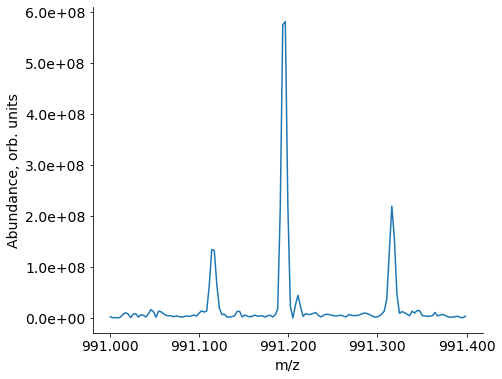

<module 'matplotlib.pyplot' from 'C:\\Users\\yaros\\Anaconda3\\envs\\tf2\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [155]:
plt.rcParams["figure.figsize"] = (7,6)
UbiSpec.plotmasskai(991.,991.4,fname="PanelS3-1.svg")

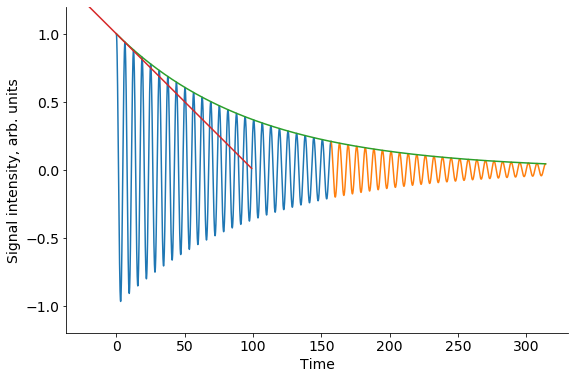

In [287]:
s1=np.arange(omega*resolution*2*(np.pi/2))/resolution
s2=np.arange(omega*resolution*2*(np.pi/2),omega*resolution*2*np.pi)/resolution
exp1=np.exp(-(s*tau))
plt.rcParams["figure.figsize"] = (9,6)
exp_sig1=np.cos(s1)*np.exp(-(s1*tau))
exp_sig2=np.cos(s2)*np.exp(-(s2*tau))
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylim(top=1.2, bottom=-1.2)
plt.plot(s1,exp_sig1)
plt.plot(s2,exp_sig2)
plt.plot(s,exp1)
plt.ylabel("Signal intensity, arb. units")
plt.xlabel("Time")
slin = np.arange(-20,100)
lin=-(slin*tau)+1
slin=slin[lin>0.]
lin=lin[lin>0.]
plt.plot(slin,lin)
plt.savefig("PanelS3-2.svg")

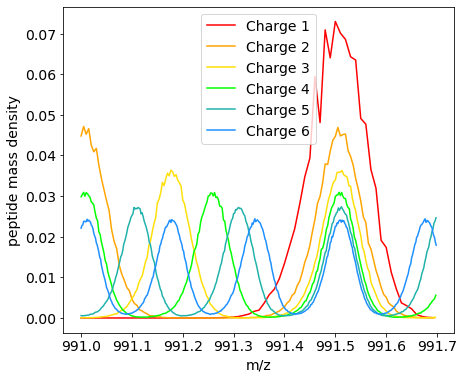

In [157]:
mz1=991.
mz2=991.6999
plt.rcParams["figure.figsize"] = (7,6)
MD=np.array(MassLogisticReg.MassDistr["0.2"])
for i in range(1,7):
    Mass1=(mz1-1.007276467)*i
    Mass2=(mz2-1.007276467)*i
    x=np.arange(mz1,mz2,0.01/i)
    plt.plot(x,MD[int(Mass1*100):int(Mass2*100)],colors[i],label="Charge "+str(i))
plt.legend()
plt.xlabel("m/z")
plt.ylabel("peptide mass density")
plt.savefig("PanelS3-3.svg")

In [158]:
FRes.reset_index(drop=True,inplace=True)

In [159]:
FRes[(FRes["m/z"]>991)&(FRes["m/z"]<992)]

m/z    Intensity     resolution  issues  cluster  number  \
429  991.195479  640700672.0  141781.765625   False     1259       1   
430  991.864481  236878848.0  136094.609375   False     1259       3   

         rest    intensity       Mass  Charge  ...  Ions  PPMError Shift  \
429 -0.000648  640700672.0  2969.5619       3  ...   y26 -2.154105     0   
430 -0.000352  236878848.0  2969.5619       3  ...   y26 -2.154105     0   

       TheorMass     Slope  Intercept   RSquare     Ratio      FWHM  \
429  2969.568297 -1.952339   7.229971 -0.994822  4.007422  0.006991   
430  2969.568297 -2.737500   6.697708 -0.993382  6.003336  0.007288   

     FWHM Coeff  
429    1.229955  
430    1.263698  

[2 rows x 24 columns]

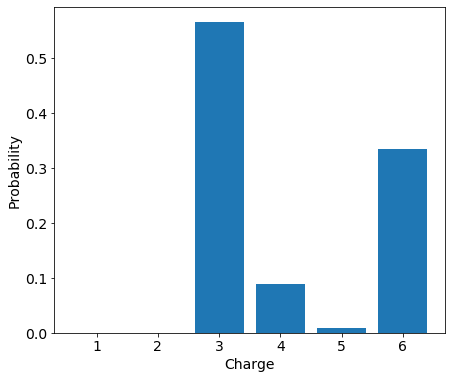

In [160]:
ind=429
Y_mass=np.zeros(6)
for i in range(6):
    Y_mass[i]=MassLogisticReg.MassDistr["0.2"][((FRes.loc[ind]["m/z"]-1.007276467)*(i+1)*100).astype(int)]
Y_mass=Y_mass/np.sum(Y_mass)
plt.bar([1,2,3,4,5,6],Y_mass[0:6])
plt.xlabel("Charge")
plt.ylabel("Probability")
plt.savefig("PanelS3-4.svg")

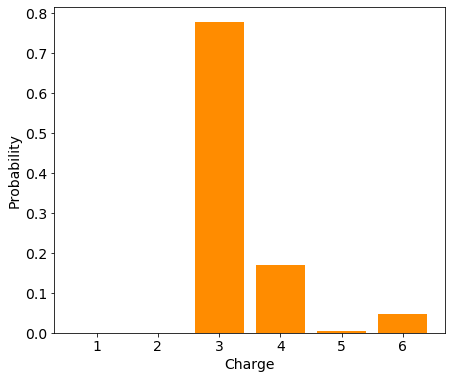

In [161]:
lrm=MassLogisticReg(FRes,FWHM=True,Slope=False)
FRes.reset_index(inplace=True,drop=True)
Y_mass,Y_Distr_mass=lrm.Apply(FRes)
plt.bar([1,2,3,4,5,6],Y_Distr_mass[ind][0:6],color="darkorange")
plt.xlabel("Charge")
plt.ylabel("Probability")
plt.savefig("PanelS3-5.svg")

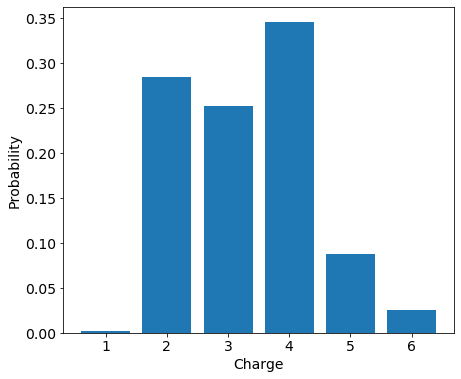

In [162]:
lr=LogisticReg(FRes,FWHM=True,Slope=False)
Y,Y_Distr=lr.Apply(FRes)
plt.bar([1,2,3,4,5,6],Y_Distr[ind][0:6])
plt.xlabel("Charge")
plt.ylabel("Probability")
plt.savefig("PanelS3-6.svg")

1 46 (1.3321530872898826, 0.3545793272516714)
2 80 (2.3504142226140763, 0.9904660604136384)
3 60 (3.215440845417955, 0.8648424418046319)
4 65 (4.192749670776414, 0.9779428391638758)
5 54 (5.265032171750737, 0.8880707283608789)
6 79 (5.802178824763638, 1.0289307434136137)
7 101 (6.568451702005957, 0.71788604798806)
8 36 (7.581835909943461, 0.5696482038324321)
4.251355310270102


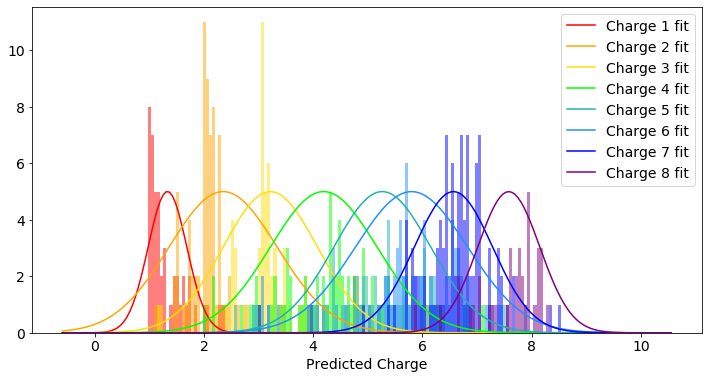

In [163]:
plt.rcParams["figure.figsize"] = (12,6)
ShowRes(Y_mass,FRes["Charge"],MaxCharge=8,GaussianHeght=5,fname="PanelS3-7.svg")

In [164]:
PeaksS3=UbiSpec.peaks[(UbiSpec.peaks["m/z"]>990)&(UbiSpec.peaks["m/z"]<992.7)]

In [165]:
PeaksS3=UbiSpec.SRCalc(Peaks=PeaksS3)

C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



0 LinregressResult(slope=0.3250851799184885, intercept=1.605781963908342, rvalue=0.0989112803396139, pvalue=2.060609410213572e-08, stderr=0.05783319826996135)
1 LinregressResult(slope=-2.200853940000356, intercept=5.458670176923383, rvalue=-0.9404184522089352, pvalue=0.0, stderr=0.014071306997485952)
2 LinregressResult(slope=-2.5281665603957983, intercept=5.6237879242971776, rvalue=-0.9022237168048183, pvalue=0.0, stderr=0.021369766260806153)
3 LinregressResult(slope=-3.0426163310636833, intercept=5.630391390103326, rvalue=-0.8282698686632021, pvalue=0.0, stderr=0.03639816602329331)
4 LinregressResult(slope=-0.4631498943738201, intercept=2.3752363157264584, rvalue=-0.21196755663923988, pvalue=7.879001880821635e-34, stderr=0.03775987013337465)
5 LinregressResult(slope=-2.3805997648035833, intercept=4.168157168255614, rvalue=-0.6322307148697232, pvalue=0.0, stderr=0.05158816338931657)
6 LinregressResult(slope=-3.0638153606936935, intercept=4.514338791114586, rvalue=-0.6947091634446396, p

-0.875 7.875


C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


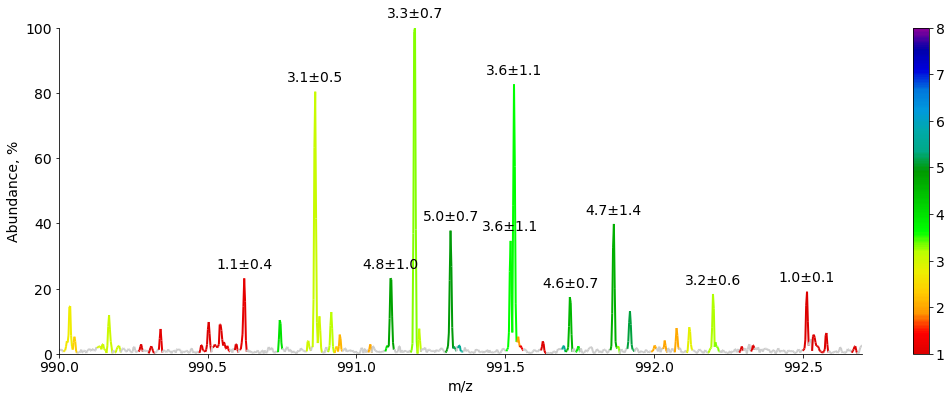

In [166]:
PeaksS3=lrm.Estimate(PeaksS3)
UbiSpec.RainbowSpectrum(990,992.7,PeaksS3,svg=True,Name="PanelS3-8")

### Figure S4

In [94]:
MonoSp= TransSpectrum(np.loadtxt("Cold shock-like protein CspC_mono_pept.csv",skiprows=2)[1000:])#4
MonoSp.A=2.117721546870e+14
FullSp = FullSpectrum(np.loadtxt("Cold shock-like protein CspC_std_pept.csv",skiprows=2)[1000:])#+LoadAvgTrans(lcmf_std_prot,lcmsms_std_prot,39))
FullSp.A=2.117721546870e+14

In [168]:
#PPeaks=pd.read_csv("MonoIons.4.txt",sep="\t")

In [169]:
MonoSp.PeakPick(250,2500)
PPeaks=MonoSp.peaks[(MonoSp.peaks["m/z"]>850)&(MonoSp.peaks["m/z"]<900)&(MonoSp.peaks["Intensity"]>5.0e6)]

In [170]:
PPeaks=MonoSp.SRCalc(Peaks=PPeaks)

C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



0 LinregressResult(slope=-1.1808745852006752, intercept=2.3240663541541124, rvalue=-0.8786513869843435, pvalue=0.0, stderr=0.011347193330838225)
1 LinregressResult(slope=-1.3583812536657351, intercept=3.919655823927134, rvalue=-0.96351804908088, pvalue=0.0, stderr=0.006672353875534958)
2 LinregressResult(slope=-0.8685816621790887, intercept=2.0636321184607502, rvalue=-0.6835070619582927, pvalue=0.0, stderr=0.016402796754866025)
3 LinregressResult(slope=-0.8323593600225895, intercept=3.721358932796598, rvalue=-0.9482150867315765, pvalue=0.0, stderr=0.00493043065126842)
4 LinregressResult(slope=-0.898658816203559, intercept=1.7808588784581514, rvalue=-0.721208241312416, pvalue=0.0, stderr=0.015263411149867562)
5 LinregressResult(slope=-0.7612420017317582, intercept=4.631045854446047, rvalue=-0.9954040229794705, pvalue=0.0, stderr=0.0012950557583627717)
6 LinregressResult(slope=-1.2408481058717469, intercept=3.58641078645596, rvalue=-0.9780832538304116, pvalue=0.0, stderr=0.00467104327915

In [171]:
PPeaks=FWHMCalc(PPeaks)
PPeaks.reset_index(inplace=True,drop=True)
PPeaks=Monomlr.Estimate(PPeaks)

C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

-0.75 6.75


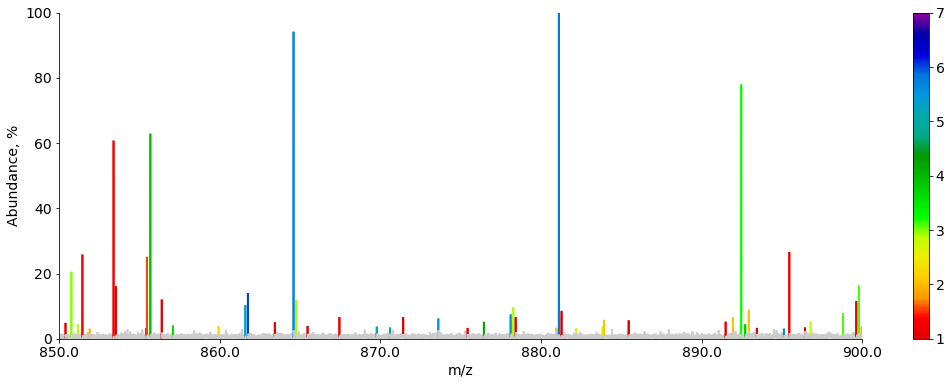

In [172]:
MonoSp.RainbowSpectrum(850,900,PPeaks,maxCharge=7,svg=True,Name="PanelS4-1-no-labels",LabelThres=1.)

-0.75 6.75


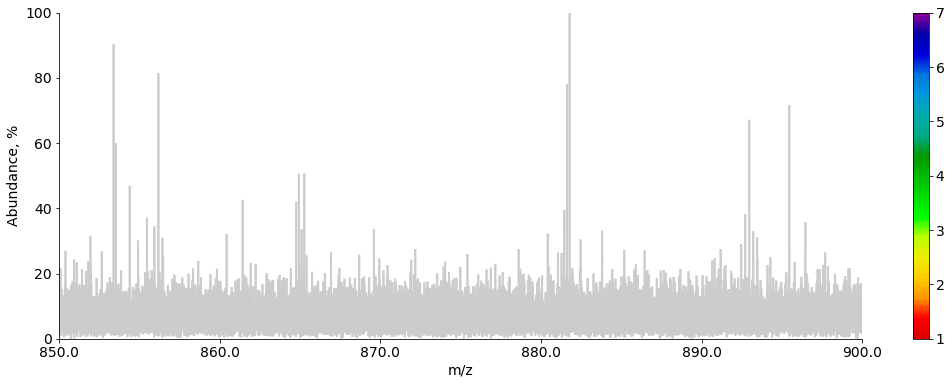

In [173]:
FullSp.RainbowSpectrum(850,900,PPeaks[PPeaks["m/z"]<0],maxCharge=7,svg=True,Name="PanelS4-2")

### Table

In [201]:
Res = pd.DataFrame(columns=["Protein","Fragments","Sites","Coverage","Charda only fragments"])
for i in range(5):
    trans=LoadAvgTrans(lcmf_mono_pept,lcmsms_mono_pept,NumbersOI[i][0])
    MSpec = TransSpectrum(trans)
    MSpec.A = 2.117721546870e+14
    MSpec.PeakPick(250,2500,sn=2.)
    
    PPeaks=pd.read_csv("MonoIons.{}.txt".format(i),sep="\t")
    FWHMCalc(PPeaks)
    PPeaks["Ions"]=""
    PPeaks["CHARDA Only"]=False
    YP,YP_distr=Monomlr.Apply(PPeaks)
    covers=[]
    for Charge in range(1,8):
        CPeaks=PPeaks[YP_distr[:,Charge-1]>0.1]
        CPeaks["Mass"]=(CPeaks["m/z"]-Proton)*Charge
        CPeaks["Charge"]=Charge
        CPeaks,cSet,cover=IonProducts(CPeaks,sequence=NumbersOI[i][3],ppm=20)
        Ions=CPeaks[CPeaks["Ions"]!=""]["Ions"]+" "+CPeaks[CPeaks["Ions"]!=""]["Charge"].apply(str)+"+"
        for ind in Ions.index:
            PPeaks["Ions"].iat[ind]=PPeaks["Ions"].iat[ind]+" "+Ions[ind]
            if MSpec.peaks[(MSpec.peaks["m/z"]-C13_Shift/Charge>PPeaks["m/z"].iat[ind]*0.99998)&(MSpec.peaks["m/z"]-C13_Shift/Charge<PPeaks["m/z"].iat[ind]*1.00002)].empty:
                PPeaks["CHARDA Only"].iat[ind]=True
        covers.append(cSet)
    Chrcover=[]
    for i1 in range(len(covers[0])):
        Prod=[]
        for j in range(len(covers)):
            Prod = Prod+covers[j][i1]
        Chrcover.insert(len(Chrcover),Prod)  
    frags=0
    sites=0
    for l in Chrcover:
        if len(l)>0:
            frags+=len(l)
            sites+=1
    Res.loc[i]=[NumbersOI[i][4],frags,sites,sites/len(NumbersOI[i][3]),len(PPeaks[PPeaks["CHARDA Only"]])]
Res

C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

Protein Fragments Sites  Coverage  \
0                  Protein YciI       133    66  0.673469   
1  DNA-binding protein HU-alpha       197    73  0.811111   
2   DNA-binding protein HU-beta       295    77  0.855556   
3  50S ribosomal protein L7/L12       296   108  0.824427   
4  Cold shock-like protein CspC       199    62  0.911765   

  Charda only fragments  
0                    85  
1                    85  
2                   115  
3                   125  
4                   109

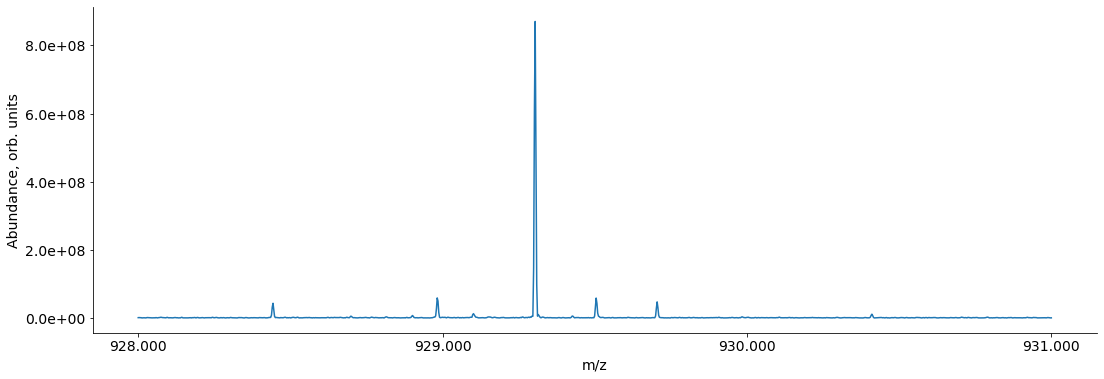

<module 'matplotlib.pyplot' from 'C:\\Users\\yaros\\Anaconda3\\envs\\tf2\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [200]:
MSpec.plotmasskai(928,931)

In [199]:
PPeaks[PPeaks["Ions"]!=""].head(40)

Unnamed: 0  index         m/z    Intensity  resolution     Slope  \
53           53    209  376.220126   16826390.0   243207.61 -0.892472   
58           58    226  393.246468   16069448.0   242092.53 -0.942750   
66           66    248  408.191781   93506584.0   232811.30 -0.565141   
99           99    353  479.264417   17918528.0   217252.70 -0.589851   
106         106    403  507.258961   51407104.0   208341.58 -0.555710   
112         112    427  521.339667    8352276.5   198494.02 -0.669355   
119         119    456  536.631363    5233287.0   183758.83 -0.675026   
132         132    504  567.060822   16943382.0   195838.19 -1.429001   
143         143    553  588.660538    5619061.0   178226.83 -1.308730   
145         145    560  592.347124    5490556.5   191493.16 -1.903011   
157         157    606  620.341576   20988228.0   185725.02 -0.468836   
166         166    631  636.018203   18422280.0   183460.20 -0.958254   
175         175    672  658.391576    9404233.0   183743.03 -0.920614   
181         181    694  669.040681   19406756.0   184017.97 -1.256189   
199         199    791  722.911719    8389237.0   176190.33 -0.799555   
215         215    869  755.744742  199456980.0   173005.03 -0.966817   
221         221    906  765.457883   73389350.0   168650.75 -0.597220   
228         228    934  774.588081  105546824.0   169815.23 -2.234220   
233         233    951  783.402949    7090338.0   158246.56 -0.943564   
239         239    974  790.763791   10648166.0   160343.27 -2.689092   
242         242    986  794.086614   28807282.0   168207.50 -1.012916   
250         250   1020  804.442497   40402596.0   165274.72 -0.777113   
257         257   1042  812.603153   28712284.0   152362.89 -1.836580   
260         260   1055  817.765158   17029774.0   159325.20 -1.126645   
279         279   1124  845.456290    6021153.5   146717.02 -0.904044   
288         288   1155  853.976150   18009712.0   164120.00 -0.685551   
289         289   1156  854.439076    6312559.5   166668.17 -0.130788   
290         290   1167  856.107205   34710620.0   161121.08 -1.177163   
313         313   1267  879.785881   79332540.0   156556.06 -0.628305   
315         315   1273  880.680793   21932660.0   145468.83 -1.950693   
318         318   1279  882.486391  156851680.0   157036.12 -0.744578   
329         329   1327  893.551209   33846740.0   159058.55 -0.831982   
353         353   1483  917.900043   28076176.0   154889.03 -1.927239   
354         354   1484  918.004574  156748720.0   154877.90 -0.615618   
379         379   1556  928.983029   60529636.0   151084.84 -2.050911   
381         381   1561  929.303716  873286000.0   151482.17 -1.535011   
382         382   1562  929.313559   10135249.0   148025.60 -1.745288   
389         389   1585  936.136015   27469170.0   154765.83 -0.806170   
393         393   1600  941.811412  163984960.0   154697.27 -1.058814   
408         408   1649  948.714200   89627910.0   155298.69 -1.729463   

     Intercept   RSquare     Ratio      FWHM  FWHM Coeff     Ions  CHARDA Only  
53    2.826549 -0.973709  1.582847  0.001547    1.185589    z3 1+        False  
58    2.820979 -0.961825  1.735463  0.001624    1.171805    y3 1+         True  
66    4.321715 -0.998228  1.541705  0.001753    1.187878    b3 1+         True  
99    2.683828 -0.889545  1.527341  0.002206    1.179109    a4 1+         True  
106   3.711571 -0.994660  1.546254  0.002435    1.189759    b4 1+         True  
112   2.043371 -0.671296  2.174431  0.002626    1.217621    y4 1+         True  
119   1.581589 -0.568167  1.841140  0.002920    1.269571   y13 3+         True  
132   3.199721 -0.960081  2.183243  0.002896    1.194648   y20 4+         True  
143   1.998303 -0.781009  1.447867  0.003303    1.256340   y15 3+         True  
145   2.397774 -0.945757  1.391606  0.003093    1.195139    a5 1+         True  
157   2.770954 -0.845650  1.730381  0.003340    1.201121    b5 1+         True  
166   2.989671 -0.962366  1.898090  0.0

In [259]:
Res = pd.DataFrame(columns=["Protein","Fragments","Sites","Coverage","Clusters"])
APeaks=pd.DataFrame()
for i in range(5):
    MSpec=FullSpectrum(LoadAvgTrans(lcmf_std_pept,lcmsms_std_pept,NumbersOI[i][1]))
    MSpec.A=2.117721546870e+14
    MSpec.PeakPick(250,2500,sn=2.)
    MSpec.CheckIssues()
    MSpec.RunHardKlor(charge_min=1,charge_max=10)
    clusters=len(MSpec.Clusters)
    CPeaks,cSet,cover=MSpec.Products(NumbersOI[i][3],ppm=20)
    APeaks=APeaks.append(CPeaks,ignore_index=True)
    frags=0
    sites=0
    for l in cSet:
        if len(l)>0:
            frags+=len(l)
            sites+=1
    Res.loc[i]=[NumbersOI[i][4],frags,sites,sites/len(NumbersOI[i][3]),clusters]
Res

Protein Fragments Sites  Coverage Clusters
0                  Protein YciI        24    20  0.204082      211
1  DNA-binding protein HU-alpha        75    49  0.544444      494
2   DNA-binding protein HU-beta       110    49  0.544444      525
3  50S ribosomal protein L7/L12        74    50  0.381679      448
4  Cold shock-like protein CspC        38    27  0.397059      393

In [184]:
PPeaks[PPeaks["Ions"]!=""]

Unnamed: 0  index          m/z    Intensity  resolution     Slope  \
69            69   7780   403.251819   48325716.0  239664.300 -0.657109   
96            96   9347   469.751984    5305160.5  201409.840 -0.355339   
105          105   9378   498.335318    6666192.0  210628.200 -0.945779   
109          109   9384   500.267213    6771600.5  206860.880 -1.172823   
117          117   9407   517.293340  130442750.0  206377.420 -0.649228   
...          ...    ...          ...          ...         ...       ...   
1349        1349  12329  1644.901848    7992786.0  103034.400 -0.953998   
1351        1351  12333  1647.501455    8335306.0  119718.500 -1.412181   
1360        1360  12371  1690.187470   12287023.0  112365.370 -0.432428   
1365        1365  12389  1710.880019   12438986.0  111697.375 -0.769189   
1384        1384  12498  1857.946087   11279169.0  110921.190 -0.593691   

      Intercept   RSquare     Ratio      FWHM  FWHM Coeff     Ions  
69     3.720760 -0.985549  1.487592  0.001683    1.169866    y4 1+  
96     1.202064 -0.206866  0.839270  0.002332    1.248468   x10 2+  
105    1.976560 -0.890839  1.540165  0.002366    1.188144    b5 1+  
109    2.135099 -0.848556  2.134494  0.002418    1.200974    z5 1+  
117    4.721437 -0.992617  1.770875  0.002507    1.189502    y5 1+  
...         ...       ...       ...       ...         ...      ...  
1349   1.749088 -0.320313  0.831012  0.015965    1.285179   b14 1+  
1351   2.563163 -0.859943  2.059473  0.013761    1.162216   b46 3+  
1360   2.217771 -0.440126  1.840151  0.015042    1.202081   b47 3+  
1365   2.477826 -0.900305  2.050926  0.015317    1.201982   y17 1+  
1384   2.229750 -0.782933  1.694529  0.016750    1.174834   y18 1+  

[193 rows x 12 columns]

In [477]:
CPeaks[CPeaks["Ions"]!=""]

Mass  Charge  Abundance  Base Peak             Interval  \
108   3130.6066      10    6460191   314.1682    314.0672-315.7724   
134   3270.5623      10    5114779   328.1638    328.0606-329.2666   
167   1038.6456       3    3813139   347.2225    347.1207-348.3335   
483   3723.9865       7    9226205   533.2918    532.8931-534.2612   
828   3613.7886       5    4581078   723.9656    723.4585-725.3036   
924   6963.6377       9    9194136   775.0790    774.6194-776.2054   
1191  3726.8025       4    6627322   933.2092    932.5972-934.8384   
2368  1606.8063       1    4298340  1608.8159  1607.6267-1612.9468   
2426  1643.8965       1    3557468  1644.9041  1644.7828-1650.1936   
2472  1672.9399       1    4527750  1673.9475  1673.8285-1679.0599   
2772  1865.0192       1    6173781  1867.0289  1865.9127-1871.1689   
2938  5966.9540       3    8066986  1990.9946  1989.8315-1993.8312   
2969  2011.9573       1    3843864  2013.9672  2012.8607-2018.2618   
3057  6227.1875       3    7607317  2078.0732  2076.4854-2080.5374   
3172  4357.1741       2    5948277  2180.5969  2179.4187-2184.2932   
3316  6935.4281       3    7814147  2313.8193  2312.6533-2316.9783   

      Correlation Ions   PPMError  Shift    TheorMass  
108        0.9986  y30   4.181320      0  3130.593510  
134        0.9971  x31 -16.328153      0  3270.615703  
167        0.9990   b9  11.323899      0  1038.633839  
483        0.9671  b34  17.802683      0  3723.920204  
828        0.9612  y35 -13.575330      0  3613.837659  
924        0.9226  b65  13.839752      0  6963.541326  
1191       0.9994  x36 -12.464453      0  3726.848953  
2368       0.9385  x16 -15.679078      0  1606.831494  
2426       0.9674  b14 -11.112413      0  1643.914768  
2472       0.9808  a15  -0.846985      0  1672.941317  
2772       0.9319  c16  -6.431709      0  1865.031195  
2938       0.9130  y57  -3.614564      0  5966.975568  
2969       0.9811  x19 -13.815396      0  2011.985096  
3057       0.9832  b57  11.136849      0  6227.118150  
3172       0.9830  c40 -15.965736      0  4357.243667  
3316       0.9146  a65 -17.058687      0  6935.546411

In [487]:
[NumbersOI[i][1] for i in range(5)]

[19, 14, 11, 35, 16]

## Single Ion spectrum - CHARDA point-by-point

In [173]:
myhf=h5py.File("D:\\FT Data\\Data Samples\\decay_ubi_cah\\CAH_MYO_OVA_averaged_transient_1.0s.h5")

In [256]:
CAHSingle=FullSpectrum((myhf["0"][:])[1000:1400000])

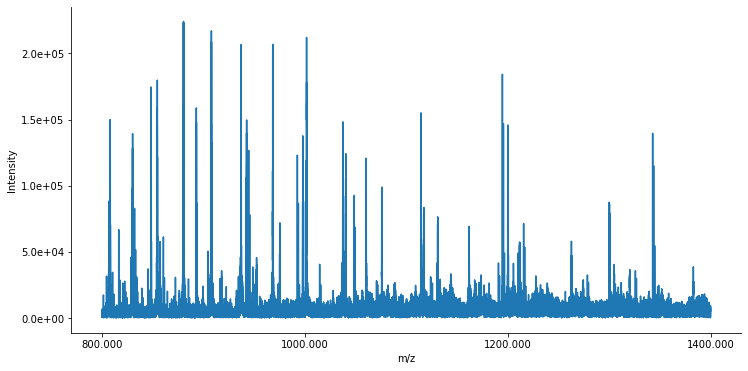

<module 'matplotlib.pyplot' from 'C:\\Users\\yaros\\Anaconda3\\envs\\tf2\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [257]:
CAHSingle.plotmasskai(800.,1400.)

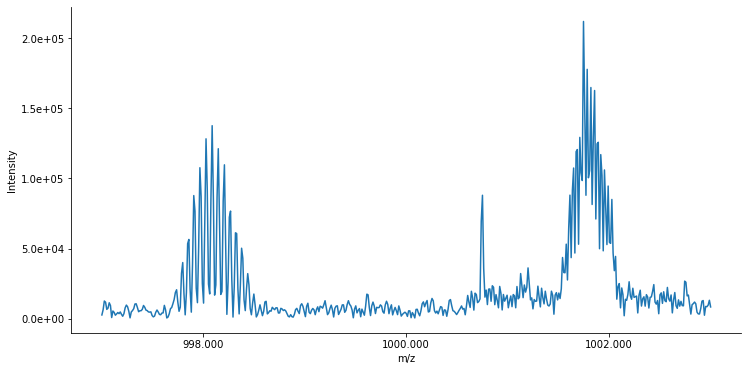

<module 'matplotlib.pyplot' from 'C:\\Users\\yaros\\Anaconda3\\envs\\tf2\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [258]:
CAHSingle.plotmasskai(997.,1003.)

In [244]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [259]:
CAHSingle.PRatio=moving_average(CAHSingle.m1/CAHSingle.m2,25)
window=30
CAHSingle.PRatio=np.zeros(len(CAHSingle.m1))
for i in range(window%2+1,len(CAHSingle.m1)-window%2-1):
    CAHSingle.PRatio[i]=np.sum(CAHSingle.m1[i-window//2:i+window//2])/np.sum(CAHSingle.m2[i-window//2:i+window//2])
hscale=np.arange(len(CAHSingle.m1))
hscale[0]=1
CAHSingle.halfcalib=CAHSingle.A/np.square(hscale/(len(CAHSingle.m1)/CAHSingle.QuantFreq))

C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


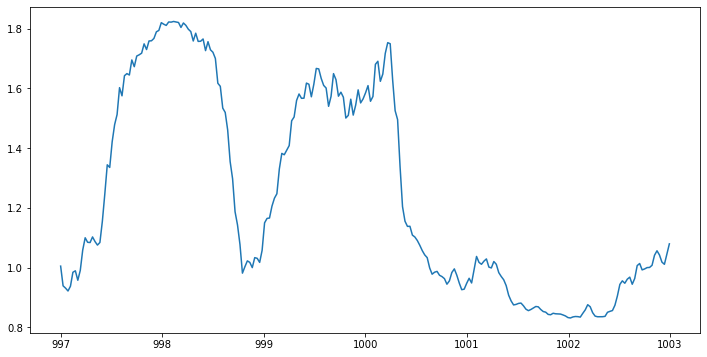

In [261]:
minMass=997.
maxMass = 1003.
minf=(np.sqrt(CAHSingle.A)*(len(CAHSingle.m1)))/(np.sqrt(minMass)*CAHSingle.QuantFreq)
maxf=(np.sqrt(CAHSingle.A)*(len(CAHSingle.m1)))/(np.sqrt(maxMass)*CAHSingle.QuantFreq)
plt.plot(CAHSingle.halfcalib[int(np.round(maxf)):int(np.round(minf))+1],
        CAHSingle.PRatio[int(np.round(maxf)):int(np.round(minf))+1])


## Processing Procedure

### Single Spectra

In [190]:
Number=4

In [191]:
NumbersOI[Number]

[16,
 16,
 39,
 'AKIKGQVKWFNESKGFGFITPADGSKDVFVHFSAIQGNGFKTLAEGQNVEFEIQDGQKGPAAVNVTAI',
 'Cold shock-like protein CspC']

In [53]:
trans=LoadAvgTrans(lcmf_std_pept,lcmsms_std_pept,NumbersOI[Number][1]) #+LoadAvgTrans(lcmf_std_prot,lcmsms_std_prot,NumbersOI[Number][2])

734    29583
728    29574
716    29556
752    29610
746    29601
722    29565
740    29592
Name: Scan, dtype: object
4098421.69


In [54]:
SpecKai,MagnKai=FormSpec(trans)

In [55]:
m1,m2=HalfSpecs(trans)

In [56]:
peaks=PeakPick(MagnKai,calib,250,2500)

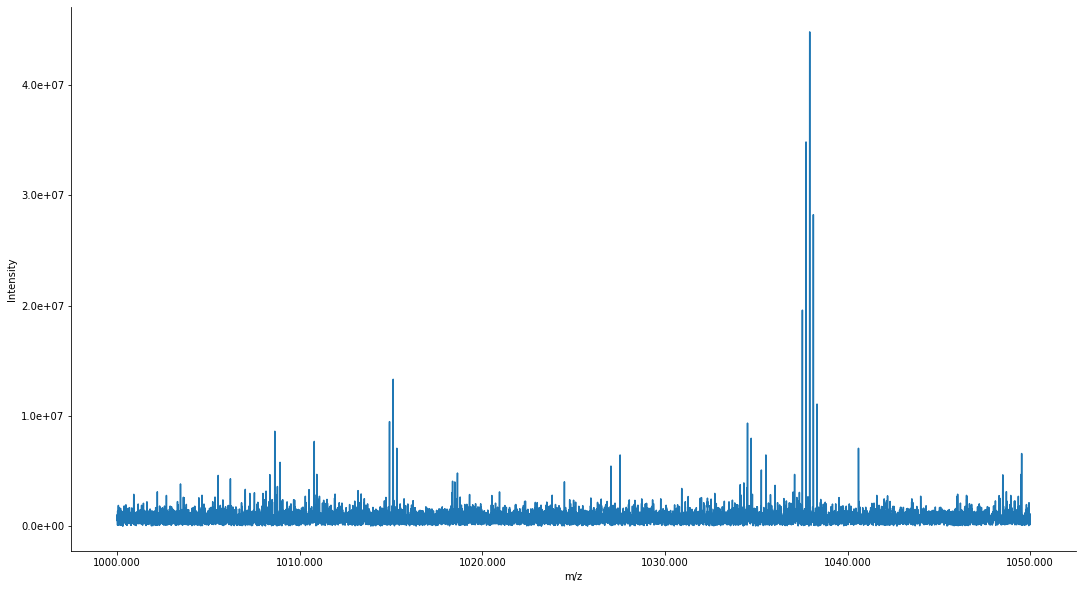

<module 'matplotlib.pyplot' from 'C:\\Users\\yaros\\Anaconda3\\envs\\tf2\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [57]:
plotmasskai(1000,1050)

In [60]:
peaks[peaks["issues"]]

m/z    Intensity     resolution  issues
4      250.737119  1466031.000  180274.953125    True
5      250.738210  1404704.375  240365.890625    True
37     256.151347  1782096.500  248010.625000    True
38     256.152333  2019977.625  205864.765625    True
122    263.952550  1638561.125  261914.906250    True
...           ...          ...            ...     ...
5707  2422.563182  1927444.125   80547.046875    True
5717  2437.595744  2224662.250   57818.113281    True
5718  2437.625332  1819275.625   77090.007812    True
5722  2444.431325  2219026.750   69626.546875    True
5723  2444.481516  2073196.875   61591.546875    True

[405 rows x 4 columns]

In [59]:
peaks=CheckIssues(peaks)

In [61]:
Clusters=RunHardKlor(peaks["m/z"],peaks["Intensity"],charge_min=1,charge_max=40)

In [62]:
Clusters

Mass  Charge  Abundance  Base Peak             Interval  \
0     1756.8814       7    6362561   251.9904    251.8847-252.9136   
1     1032.3812       4    3361723   259.1026    258.8946-260.2439   
2     2069.2876       8    6723647   259.7935    259.5459-260.6136   
3      779.9503       3    2741334   261.3250    260.7701-262.3043   
4     1837.2217       7    5854306   263.4676    263.3470-264.3448   
..          ...     ...        ...        ...                  ...   
333   1524.7454       1    8715443  1526.7551  1522.0619-1531.7495   
334   1583.7359       1    6644571  1584.7435  1583.4299-1590.3656   
335   1711.7758       1    6086360  1712.7834  1711.1780-1718.0822   
336   1734.8870       1    7248216  1735.8947  1735.1938-1741.8679   
337  21125.1853       9   43712004  2349.5869  2347.1582-2355.4253   

     Correlation  
0         0.9293  
1         0.9789  
2         0.9001  
3         0.9005  
4         0.9212  
..           ...  
333       0.9431  
334       0.9876  
335       0.9329  
336       0.9288  
337       0.9139  

[338 rows x 6 columns]

In [63]:
Clusters,coverSet,cover = Products(Clusters,NumbersOI[Number][3],ppm=20)

b7 1+
b8 1+
b11 2+
b14 2+
b16 2+
b20 3+
b20 2+
b30 3+
b32 4+
b33 4+
b34 4+
a35 4+
b35 4+
b36 4+
b36 3+
b40 4+
b45 5+
b45 4+
b47 5+
b47 4+
b48 6+
b48 5+
b48 4+
b49 5+
b49 4+
b50 4+
b51 5+
b52 5+
b52 4+
b54 4+
b55 5+
b59 5+
b62 5+
b63 5+
b64 5+
31


In [64]:
cover

0.4626865671641791

In [570]:
frags=0
sites=0
for l in coverSet:
    if len(l)>0:
        frags+=len(l)
        sites+=1
print(frags,sites,sites/len(NumbersOI[Number][3]))

43 31 0.45588235294117646


In [173]:
links=PeakstoClusters(peaks,Clusters)

C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

0
           m/z   Intensity     resolution      rest  Number
13  251.990383  2231107.25  198156.828125  0.000347       0
14  252.133098  2190536.50  266243.718750 -0.004005       1
[13, 14]
    cluster  peak  number      rest   intensity
13        0    13       0  0.000347  2231107.25
14        0    14       1 -0.004005  2190536.50
0
           m/z    Intensity     resolution      rest  Number
59  259.102603  1891246.125  181526.421875  0.000106       0
61  259.353539  1637144.125  177255.140625  0.000497       1
[59, 61]
    cluster  peak  number      rest    intensity
59        1    59       0  0.000106  1891246.125
61        1    61       1  0.000497  1637144.125
1
           m/z    Intensity     resolution      rest  Number
63  259.665721  1946439.375  192702.468750 -0.020045       0
64  259.668026  1885155.375  188957.609375 -0.001608       0
65  259.793552  2240043.750  164257.578125 -0.000753       1
68  260.420581  1480686.250  176891.656250 -0.001292       6
[65]
    cluster 

In [174]:
peaksref=peaks.join(links.set_index('peak'),how='inner')

In [175]:
RPeaks=peaksref.join(Clusters,how='inner',on='cluster',lsuffix='_peak')

In [176]:
RPeaks

m/z    Intensity     resolution  cluster  number      rest  \
13     251.990383  2231107.250  198156.828125        0       0  0.000347   
14     252.133098  2190536.500  266243.718750        0       1 -0.004005   
59     259.102603  1891246.125  181526.421875        1       0  0.000106   
61     259.353539  1637144.125  177255.140625        1       1  0.000497   
65     259.793552  2240043.750  164257.578125        2       1 -0.000753   
...           ...          ...            ...      ...     ...       ...   
5666  2349.255705  2710456.250   70538.117188      337       9  0.020366   
5667  2349.349780  3585066.000  106677.617188      337      10 -0.136317   
5668  2349.458833  5676087.000   86845.726562      337      11 -0.158193   
5670  2349.586897  4541905.500   60782.300781      337      12 -0.008974   
5672  2349.698712  3653592.500   98531.820312      337      13 -0.005994   

        intensity        Mass  Charge  Abundance  Base Peak  \
13    2231107.250   1756.8814       7    6362561   251.9904   
14    2190536.500   1756.8814       7    6362561   251.9904   
59    1891246.125   1032.3812       4    3361723   259.1026   
61    1637144.125   1032.3812       4    3361723   259.1026   
65    2240043.750   2069.2876       8    6723647   259.7935   
...           ...         ...     ...        ...        ...   
5666  2710456.250  21125.1853       9   43712004  2349.5869   
5667  3585066.000  21125.1853       9   43712004  2349.5869   
5668  5676087.000  21125.1853       9   43712004  2349.5869   
5670  4541905.500  21125.1853       9   43712004  2349.5869   
5672  3653592.500  21125.1853       9   43712004  2349.5869   

                 Interval  Correlation Ions  PPMError  Shift  TheorMass  
13      251.8847-252.9136       0.9293            0.0      0        0.0  
14      251.8847-252.9136       0.9293            0.0      0        0.0  
59      258.8946-260.2439       0.9789            0.0      0        0.0  
61      258.8946-260.2439       0.9789            0.0      0        0.0  
65      259.5459-260.6136       0.9001            0.0      0        0.0  
...                   ...          ...  ...       ...    ...        ...  
5666  2347.1582-2355.4253       0.9139            0.0      0        0.0  
5667  2347.1582-2355.4253       0.9139            0.0      0        0.0  
5668  2347.1582-2355.4253       0.9139            0.0      0        0.0  
5670  2347.1582-2355.4253       0.9139            0.0      0        0.0  
5672  2347.1582-2355.4253       0.9139            0.0      0        0.0  

[780 rows x 17 columns]

In [177]:
RPeaks.reset_index(inplace=True)

In [178]:
RPeaks=CheckIssues(RPeaks)

In [181]:
len(RPeaks["cluster"].unique())

43

In [180]:
RPeaks=RPeaks[RPeaks['Ions']!=""]

In [182]:
RPeaks.reset_index(inplace=True)

In [183]:
RPeaks=SRCalc(RPeaks)

C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

LinregressResult(slope=-0.76135177186937, intercept=3.2706035053189764, rvalue=-0.9544244098723439, pvalue=0.0, stderr=0.004209981471140624)
LinregressResult(slope=-0.14678944104065594, intercept=1.0404763457231716, rvalue=-0.1725656824074454, pvalue=8.212228641251342e-23, stderr=0.014816188958925622)
LinregressResult(slope=0.3202951240465739, intercept=-0.2800960246360442, rvalue=0.08280333267096829, pvalue=2.728184170160762e-06, stderr=0.0681662349126619)
LinregressResult(slope=-0.4899490733705005, intercept=0.6163415290025969, rvalue=-0.25270956241365616, pvalue=8.265066442145465e-48, stderr=0.03317110537828726)
LinregressResult(slope=0.15173463765262324, intercept=0.43566519898262124, rvalue=0.09370949824676021, pvalue=1.0924827800130963e-07, stderr=0.028506677056604694)
LinregressResult(slope=-0.5762679988894486, intercept=1.478352636257879, rvalue=-0.621716758722835, pvalue=0.0, stderr=0.012837745222131058)
LinregressResult(slope=0.6526854185006038, intercept=0.04159746954956134,

In [319]:
FRes=AllPeaks[AllPeaks["RSquare"]<-0.85]

In [320]:
FRes=FRes[~FRes["issues"]]

In [321]:
FRes["FWHM"]=FRes["m/z"]/FRes["resolution"]
FRes["FWHM Coeff"]=np.power(FRes["FWHM"],0.6666)/(FRes["m/z"]*3.e-5)

In [322]:
Charges=np.sort(FRes["Charge"].unique())
Enough=[np.count_nonzero(FRes["Charge"]==n)>3 for n in Charges]
Charges[Enough]

array([ 1,  2,  3,  4,  5,  6,  7,  9, 10], dtype=int64)

In [323]:
FRes=FRes[np.isin(FRes["Charge"],[1,2,3,4,5,6,7])]

In [252]:
FRes["Spectrum"]=0

In [264]:
#Mono peaks
FRes["Spectrum"]=0
FRes.loc[FRes.index<=31,"Spectrum"]=1
FRes.loc[(FRes.index>80)&(FRes.index<=119),"Spectrum"]=2
FRes.loc[(FRes.index>119)&(FRes.index<=231),"Spectrum"]=3
FRes.loc[(FRes.index>231)&(FRes.index<=334),"Spectrum"]=4
FRes.loc[(FRes.index>334),"Spectrum"]=5

In [340]:
#Full peaks
FRes["Spectrum"]=0
FRes.loc[FRes.index<=80,"Spectrum"]=1
FRes.loc[(FRes.index>80)&(FRes.index<=331),"Spectrum"]=2
FRes.loc[(FRes.index>331)&(FRes.index<=643),"Spectrum"]=3
FRes.loc[(FRes.index>643)&(FRes.index<=928),"Spectrum"]=4
FRes.loc[(FRes.index>928),"Spectrum"]=5

In [341]:
FRes

level_0  index          m/z    Intensity     resolution  cluster  \
6         240   2632   756.079278   8459819.00  174520.375000      120   
7         241   2635   756.414094   4426895.00  181546.000000      120   
8         249   2684   765.457992   5647934.00  174673.328125      123   
10        254   2721   774.921481   3479884.50  109566.468750      125   
11        255   2722   775.088770   6011398.00  166921.343750      125   
...       ...    ...          ...          ...            ...      ...   
1083      751   5076  1422.958023  12254186.00  120443.921875      327   
1084      752   5077  1423.208744  23557302.00  123245.875000      327   
1085      753   5079  1423.460030  24026448.00  114582.062500      327   
1086      754   5081  1423.708595   9477815.00  133671.484375      327   
1092      764   5141  1483.744147   3189143.75   94428.335938      331   

      number      rest    intensity       Mass  ...  Shift    TheorMass  \
6          1 -0.000749   8459819.00  2264.2134  ...      0  2264.235770   
7          2  0.000343   4426895.00  2264.2134  ...      0  2264.235770   
8          0  0.000016   5647934.00   764.4507  ...      0   764.458499   
10         2 -0.002684   3479884.50  4641.4812  ...      0  4641.532991   
11         3 -0.002304   6011398.00  4641.4812  ...      0  4641.532991   
...      ...       ...          ...        ...  ...    ...          ...   
1083       2 -0.004625  12254186.00  5685.8009  ...      0  5685.868520   
1084       3 -0.005095  23557302.00  5685.8009  ...      0  5685.868520   
1085       4 -0.003304  24026448.00  5685.8009  ...      0  5685.868520   
1086       5 -0.012398   9477815.00  5685.8009  ...      0  5685.868520   
1092       4  0.001962   3189143.75  5926.9321  ...      0  5927.011163   

      issues     Slope  Intercept   RSquare     Ratio      FWHM  FWHM Coeff  \
6      False -0.872520   2.140279 -0.852223  1.733642  0.004332    1.172060   
7      False -1.375481   1.860231 -0.854831  2.384593  0.004167    1.141458   
8      False -0.836486   1.734078 -0.869681  1.469447  0.004382    1.166571   
10     False -3.289046   2.820272 -0.917868  3.290314  0.007073    1.585445   
11     False -2.334901   2.901150 -0.963625  5.716936  0.004643    1.197409   
...      ...       ...        ...       ...       ...       ...         ...   
1083   False -1.673892   3.014294 -0.893306  1.920625  0.011814    1.215495   
1084   False -1.760122   3.789105 -0.978523  3.788234  0.011548    1.196934   
1085   False -1.626806   3.746139 -0.961038  5.247505  0.012423    1.256453   
1086   False -1.723049   2.805018 -0.886222  2.069029  0.010651    1.133733   
1092   False -1.541937   1.768329 -0.884603  1.140118  0.015713    1.409758   

      Spectrum  
6            1  
7            1  
8            1  
10           1  
11           1  
...        ...  
1083         5  
1084         5  
1085         5  
1086         5  
1092         5  

[632 rows x 27 columns]

1 49 (0.8449251562551536, 0.2634901534394655)
2 108 (1.1718677671950442, 0.5457003103602006)
3 100 (1.5739601279887712, 0.5195073240446555)
4 90 (1.7492901958238958, 0.6501065199080593)
5 93 (1.895306564422441, 0.5278507687264348)
6 112 (2.328596928098148, 0.5437921015416196)
7 80 (2.45702824554571, 0.7023493275924052)
4.205203354173529


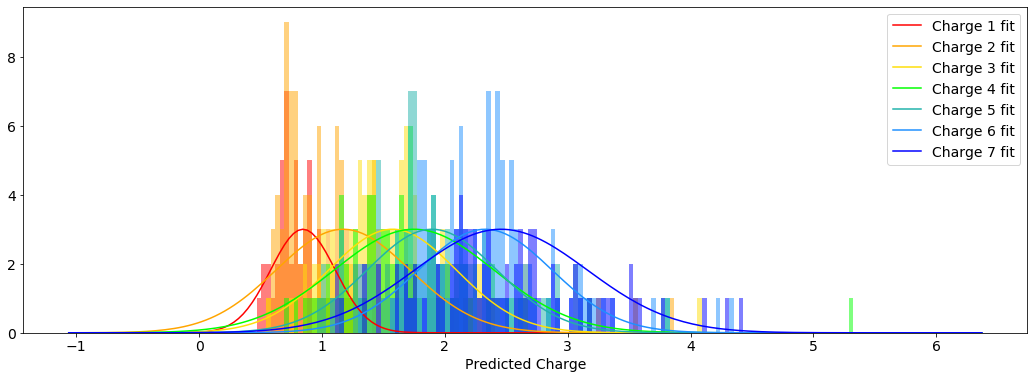

In [342]:
ShowRes(np.array(FRes["Slope"])*(-1),FRes["Charge"])

In [251]:
FRes[FRes["Charge"]==5]

index       Mass  Charge  Abundance  Base Peak             Interval  \
11     290  4641.4839       5  784663296   929.7051    929.1002-931.3730   
12     299  4738.5366       5  107930736   949.1157    948.5223-950.7162   
14     312  4869.5748       5  508613728   975.3233    974.5020-977.1239   
16     321  5037.6628       5  152035184  1009.1414  1007.5473-1011.2196   
18     348  5567.8525       5   83770520  1114.9789  1114.2761-1116.8547   
86     562  4778.5718       5  257097344   957.3232    956.5314-958.7035   
87     579  4877.6389       5  140320256   977.1366    976.3167-978.5278   
152    496  3763.0745       5  119268536   753.8228    753.4199-755.4135   
178    678  4495.4445       5  190472160   900.6977    899.8937-902.0414   
185    732  4682.5060       5  172552208   937.9095    937.3097-939.5015   
187    737  4699.5317       5  855862272   941.5151    940.7897-942.8329   
193    786  4911.6806       5  149118256   983.9449    983.1511-985.5275   
195    796  4982.7150       5   81196648   998.1518    997.2131-999.5439   
210    877  5497.8982       5  172352896  1101.1885  1100.4264-1103.2645   
283    734  6012.2486       5  182119072  1204.0586  1203.3168-1205.8658   
287    746  6083.2847       5  316928288  1218.4663  1217.0906-1221.1281   
312    837  7028.7893       5   68204384  1407.5673  1406.3585-1409.3654   
317    880  7557.0311       5   94088360  1513.4160  1511.8324-1515.4178   
322    895  7882.1926       5  126688832  1578.2479  1576.7847-1580.1641   
324    900  7939.2079       5  144519232  1589.8514  1588.6691-1591.6511   
354    279  4753.4313       5   32320414   952.0946    951.1422-953.7504   
358    285  4882.4720       5   81182304   978.1032    977.2990-979.4459   
364    297  5067.5485       5  125110632  1015.1185  1014.1832-1017.0355   
366    306  5181.5914       5  394514016  1037.9271  1037.1959-1039.5037   
369    314  5280.6570       5  409579136  1057.7402  1056.9243-1059.5808   
371    328  5409.6963       5  361578656  1083.5481  1082.6862-1085.0897   
374    340  5556.7641       5  112183816  1112.9617  1112.1245-1114.5035   
376    350  5685.8039       5  259999296  1138.7697  1137.5435-1140.3822   
380    372  6041.9702       5   67521080  1210.0029  1209.1835-1212.3782   
386    386  6412.1594       5  260087584  1284.2412  1282.7737-1286.7585   
390    393  6651.2821       5  143320544  1332.0658  1329.5845-1337.0498   

     Correlation Ions   PPMError  Shift  ...          m/z     Intensity  \
11        0.9804  b41 -10.576378      0  ...   929.303716  8.732860e+08   
12        0.9734  b42 -10.373313      0  ...   948.714200  8.962791e+07   
14        0.9796  b43 -10.563408      0  ...   974.921675  8.750446e+08   
16        0.9941  b45 -10.583810      0  ...  1008.539297  4.070001e+08   
18        0.9000  b50 -10.933753      0  ...  1114.577219  1.981391e+08   
86        0.9675  y45 -10.273906      0  ...   956.721271  1.647813e+08   
87        0.9635  y46 -10.334686      0  ...   976.534948  9.349702e+07   
152       0.9645  y36  -8.948427      0  ...   753.621652  6.882903e+07   
178       0.9742  y43  -9.858229      0  ...   900.095953  2.229544e+08   
185       0.9627  z45  -9.855063      0  ...   937.507953  1.553104e+08   
187       0.9749  y45 -10.000033      0  ...   940.913283  8.395953e+08   
193       0.9711  y47 -10.296691      0  ...   983.343291  1.218986e+08   
195       0.9763  y48 -10.694605      0  ...   997.550148  6.471128e+07   
210       0.9732  y53 -10.267394      0  ...  1100.586188  2.284322e+07   
283       0.9830  y60 -10.394736      0  ...  1203.456707  1.865266e+08   
287       0.9591  y61 -10.440064      0  ...  1217.663878  2.614701e+08   
312       0.9200  y69 -10.819500      0  ...  1406.764271  2.545825e+07   
317       0.9124  y74 -11.727876      0  ...  1512.414033  4.405036e+07   
322       0.9385  y77 -11.532406      0  ...  1577.445426  4.924735e+07   
324       0.9680  y78 -12.225981      0  ...  1588.849397  9.733694e+07 

In [220]:
FRes.drop([176,201,150,155,202,140,372],inplace=True)

1 49 (0.5312962524503492, 0.1288157271075938)
2 108 (0.6678069985574631, 0.2363551344716206)
3 100 (0.8635360629498225, 0.29310767045181185)
4 90 (0.9583955847994831, 0.3395388943692262)
5 93 (1.1031307319074746, 0.3418846887465262)
6 112 (1.3835197116921623, 0.3456567654228659)
7 80 (1.4115242419075948, 0.44908903787418103)
3.1581391827690997


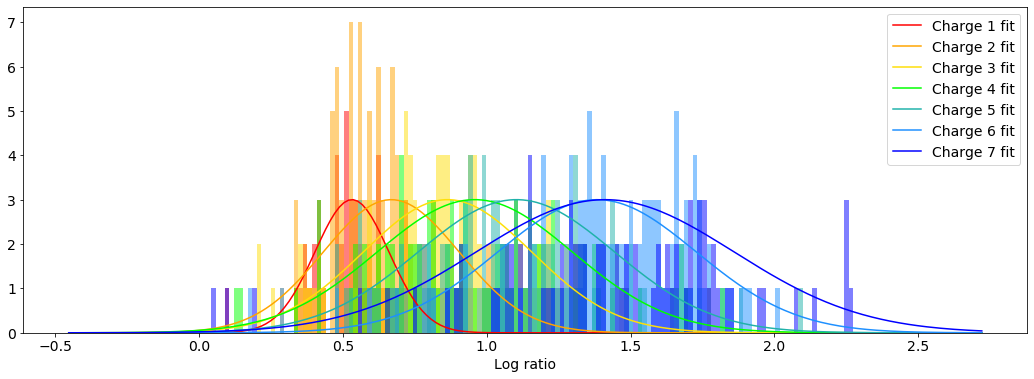

In [343]:
ShowRes(np.log(FRes["Ratio"]),FRes["Charge"],xlabel="Log ratio")

In [344]:
regr=LinearRegressionFit(FRes)
Charge_pred=LinearRegressionApply(FRes,regr)

C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

1 49 (2.378527498205857, 0.30497229939823683)
2 108 (2.938976784061722, 0.764452695252733)
3 100 (3.6385302411881497, 0.8679781825555523)
4 90 (3.9735001778999037, 1.0403930151483953)
5 93 (4.367198138784757, 0.9184279279954963)
6 112 (5.398579188653195, 0.8551341734178665)
7 80 (5.697304046791236, 1.2848673076912842)
3.9167061796499127


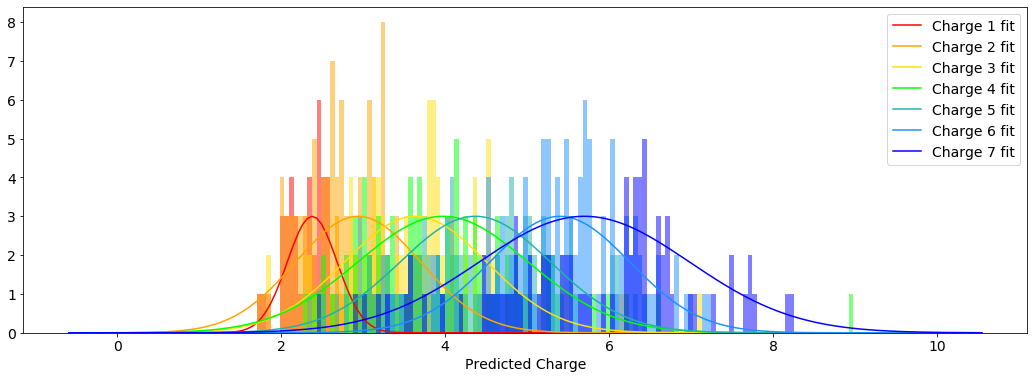

In [345]:
ShowRes(Charge_pred,FRes["Charge"])

In [189]:
Charges=np.sort(FRes["Charge"].unique())
Enough=[np.count_nonzero(FRes["Charge"]==n)>3 for n in Charges]
Charges[Enough]

array([1, 2, 3, 4, 5, 6, 7], dtype=int64)

In [190]:
FRes=FRes[np.isin(FRes["Charge"],Charges[Enough])]

In [346]:
lr,scaler,Classes=LogisticRegressionFit(FRes)

[1 2 3 4 5 6 7]


C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [347]:
Y,Y_distr=LogisticRegressionApply(FRes,lr,scaler,Classes)

C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

1 49 (2.0561443541831794, 0.42864062949560594)
2 108 (2.785022433804991, 0.9110475413760357)
3 100 (3.69313704844656, 0.9380125687195576)
4 90 (4.0494111848122145, 0.9945495276157358)
5 93 (4.551421644263566, 0.8861354670880497)
6 112 (5.484257734215767, 0.753872314190978)
7 80 (5.614833243626494, 1.013622937077693)
2.8729962968333203


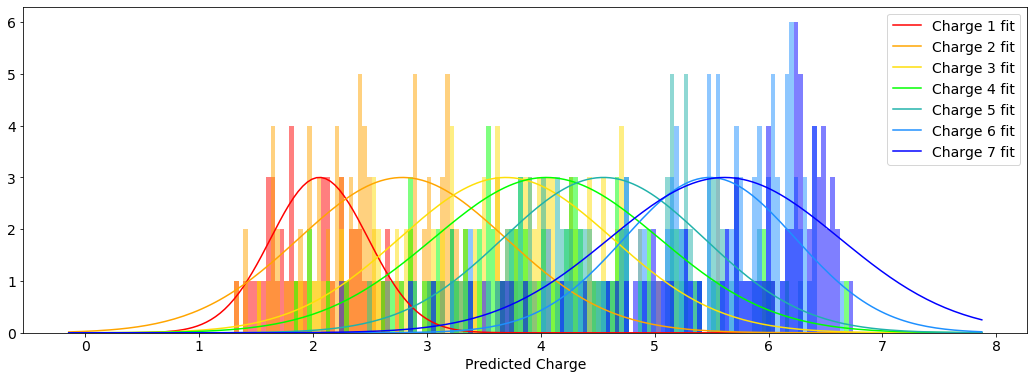

In [349]:
ShowRes(Y,FRes["Charge"])

In [350]:
Y_mass_decay=np.copy(Y_distr)
for i in range(len(Y_distr)):
    Y_mass_decay[i]=MassDistr["0.2"][((FRes.iloc[i]["m/z"]-1.007276467)*Classes*100).astype(int)]*Y_distr[i]
    Y_mass_decay[i]=Y_mass_decay[i]/np.sum(Y_mass_decay[i])
Y_pred=np.dot(Y_mass_decay,Classes)

1 49 (1.681393141354995, 0.4041350244455759)
2 108 (2.518079180844472, 0.891118050288486)
3 100 (3.6558656387137334, 0.7746576706111281)
4 90 (4.103847999910297, 0.82892796081817)
5 93 (4.828348851221544, 0.8166276808025663)
6 112 (5.5527236826377315, 0.7728218432829689)
7 80 (5.811466533443121, 0.9628644296164358)
3.22002601540301


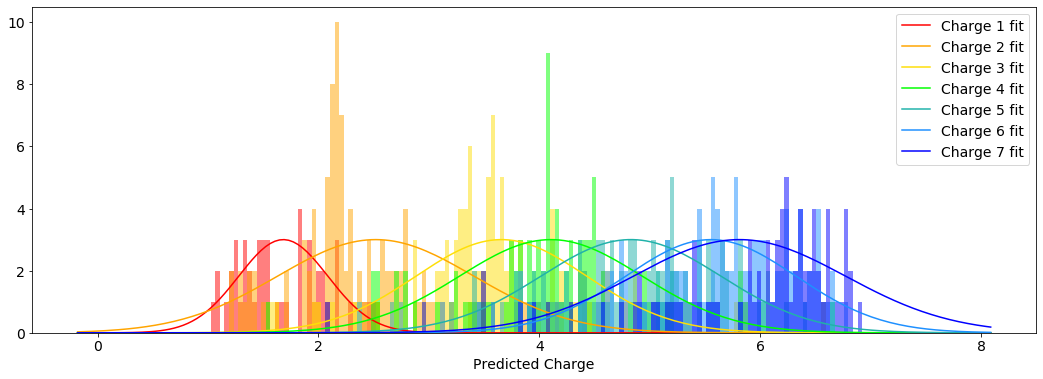

In [351]:
ShowRes(Y_pred,FRes["Charge"])

In [314]:
#Save as mono scaler and mono lr
MonoScaler=scaler
MonoLR=lr

In [352]:
#Save as full scaler and full lr
FullScaler=scaler
FullLR=lr

## Set of Spectra

In [82]:
AllPeaks=pd.DataFrame()
for i in range(5):
    trans=LoadAvgTrans(lcmf_std_pept,lcmsms_std_pept,NumbersOI[i][1])
    SpecKai,MagnKai=FormSpec(trans)
    m1,m2=HalfSpecs(trans)
    peaks=PeakPick(MagnKai,calib,250,2500)
    Clusters=RunHardKlor(peaks["m/z"],peaks["Intensity"],charge_min=1,charge_max=15)
    Clusters,coverSet,cover = Products(Clusters,NumbersOI[i][3],ppm=20)
    links=PeakstoClusters(peaks,Clusters)
    peaksref=peaks.join(links.set_index('peak'),how='inner')
    RPeaks=peaksref.join(Clusters,how='inner',on='cluster',lsuffix='_peak')
    RPeaks.reset_index(inplace=True)
    RPeaks=CheckIssues(RPeaks)
    RPeaks=RPeaks[~RPeaks["issues"]]
    RPeaks=RPeaks[RPeaks['Ions']!=""]
    RPeaks.reset_index(inplace=True)
    RPeaks=SRCalc(RPeaks)
    AllPeaks = AllPeaks.append(RPeaks,ignore_index=True)

1282    30406
1288    30415
1276    30397
Name: Scan, dtype: object
1116897.56
b3 1+
b5 1+
a12 3+
b41 6+
b41 5+
b43 5+
b45 5+
b50 5+
b50 4+
20
0
           m/z     Intensity     resolution          rest  Number
9   251.047627  1.231595e+06  180857.890625  4.321487e-07       0
10  251.049579  1.041929e+06  148916.765625  3.905906e-03       0
19  251.549233  8.789680e+05  179983.671875 -1.419665e-04       1
[9, 19]
    cluster  peak  number          rest  intensity
9         0     9       0  4.321487e-07  1231595.0
19        0    19       1 -1.419665e-04   878968.0
0
           m/z    Intensity     resolution      rest  Number
13  251.244296  1283865.750  180093.046875  0.000058       0
20  251.578638  1132066.125  203749.062500 -0.000270       1
[13, 20]
    cluster  peak  number      rest    intensity
13        1    13       0  0.000058  1283865.750
20        1    20       1 -0.000270  1132066.125
1
           m/z    Intensity     resolution      rest  Number
28  251.989996   914687.37

C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]



[95, 111]
     cluster  peak  number      rest    intensity
95         8    95       0 -0.000037  5449038.000
111        8   111       1  0.000031  1640947.125
0
            m/z    Intensity     resolution      rest  Number
96   258.184093  1311466.375  101517.695312  0.000034       0
102  258.685956  1145505.750  177483.859375  0.000404       1
[96, 102]
     cluster  peak  number      rest    intensity
96         9    96       0  0.000034  1311466.375
102        9   102       1  0.000404  1145505.750
1
            m/z     Intensity     resolution      rest  Number
120  259.850649  9.830602e+05  177085.531250 -0.001366       0
122  260.017959  1.213974e+06  199522.609375 -0.000862       1
131  260.685515  1.383832e+06  178488.390625 -0.008945       5
[120, 122]
     cluster  peak  number      rest     intensity
120       10   120       0 -0.001366  9.830602e+05
122       10   122       1 -0.000862  1.213974e+06
0
            m/z  Intensity    resolution      rest  Number
240  271.138

In [89]:
AllPeaks

level_0  index          m/z     Intensity     resolution  cluster  \
0         100   1131   408.191905  1.052727e+07  229948.031250       49   
1         101   1136   409.195363  2.729784e+06  202113.000000       49   
2         115   1371   461.908383  1.166998e+06  106670.023438       57   
3         116   1375   462.241965  1.151360e+06  132773.109375       57   
4         195   2094   620.341541  2.887134e+06  204033.718750       96   
...       ...    ...          ...           ...            ...      ...   
1088      758   5123  1468.755746  4.704050e+06  122415.937500      329   
1089      759   5127  1469.759217  3.921362e+06   82941.195312      329   
1090      762   5139  1483.241738  5.995718e+06  120750.546875      331   
1091      763   5140  1483.494831  5.835814e+06   92270.101562      331   
1092      764   5141  1483.744147  3.189144e+06   94428.335938      331   

      number      rest     intensity       Mass  ...  Correlation  Ions  \
0          0  0.000028  1.052727e+07   407.1846  ...       0.9994    b3   
1          1  0.000131  2.729784e+06   407.1846  ...       0.9994    b3   
2          0  0.000118  1.166998e+06  1382.7032  ...       0.9913   a12   
3          1 -0.002490  1.151360e+06  1382.7032  ...       0.9913   a12   
4          0  0.000064  2.887134e+06   619.3342  ...       0.9189    b5   
...      ...       ...           ...        ...  ...          ...   ...   
1088       0  0.000370  4.704050e+06  1467.7481  ...       0.9999   y15   
1089       1  0.000486  3.921362e+06  1467.7481  ...       0.9999   y15   
1090       2 -0.000965  5.995718e+06  5926.9321  ...       0.9707   b54   
1091       3  0.008055  5.835814e+06  5926.9321  ...       0.9707   b54   
1092       4  0.001962  3.189144e+06  5926.9321  ...       0.9707   b54   

       PPMError Shift    TheorMass issues     Slope  Intercept   RSquare  \
0     -8.051947     0   407.187879  False -0.376419   1.996435 -0.771547   
1     -8.051947     0   407.187879  False  0.526464  -0.019527  0.310543   
2      9.235722     0  1382.690430  False -1.153198   0.328359 -0.383090   
3      9.235722     0  1382.690430  False  0.723924  -0.783302  0.331750   
4     -9.941695     0   619.340357  False -0.550394   0.819973 -0.372075   
...         ...   ...          ...    ...       ...        ...       ...   
1088 -13.669972     0  1467.768164  False -0.339905   1.142631 -0.316403   
1089 -13.669972     0  1467.768164  False -0.057045   0.829448 -0.024015   
1090 -13.339441     0  5927.011163  False -0.020806   1.174479 -0.032185   
1091 -13.339441     0  5927.011163  False -1.584066   2.258730 -0.775712   
1092 -13.339441     0  5927.011163  False -1.541937   1.768329 -0.884603   

         Ratio  
0     1.268522  
1     0.908492  
2     0.870041  
3     0.884562  
4     1.037376  
...        ...  
1088  0.773627  
1089  1.285647  
1090  0.877436  
1091  2.720846  
1092  1.140118  

[1093 rows x 24 columns]

### Monoisotopics

In [86]:
AllIonPeaks=pd.DataFrame()
for i in range(5):
    #reference spectra both peptide and protein modeds
    trans=LoadAvgTrans(lcmf_std_pept,lcmsms_std_pept,NumbersOI[i][1])+LoadAvgTrans(lcmf_std_prot,lcmsms_std_prot,NumbersOI[i][2])
    SpecKai,MagnKai=FormSpec(trans)
    m1,m2=HalfSpecs(trans)
    peaks=PeakPick(MagnKai,calib,250,2500)
    Clusters=RunHardKlor(peaks["m/z"],peaks["Intensity"],charge_min=1,charge_max=15)
    Clusters,coverSet,cover = Products(Clusters,NumbersOI[i][3],ppm=20)
    #monoisotopic spectrum
    trans=LoadAvgTrans(lcmf_mono_pept,lcmsms_mono_pept,NumbersOI[i][0])
    SpecKai,MagnKai=FormSpec(trans)
    m1,m2=HalfSpecs(trans)
    peaks=PeakPick(MagnKai,calib,250,2500)
    #Get clusters with ions (plus mass error correction)
    IonClusters=Clusters[(Clusters["Ions"] != "") & (Clusters["PPMError"] > -14) & (Clusters["PPMError"] < -7)]
    IonClusters["Mono m/z"]=(IonClusters["Mass"]/IonClusters["Charge"])+Proton
    IonClusters["m/z"]=0.
    IonClusters["Intensity"]=0.
    IonClusters["resolution"]=0.
    #match clusters to monoisotopic peak 
    for row in IonClusters.iterrows():
        ppmlow=row[1]["Mono m/z"]-row[1]["Mono m/z"]/100000
        ppmhigh=row[1]["Mono m/z"]+row[1]["Mono m/z"]/100000
        localpeak=peaks[(peaks["m/z"]>ppmlow) & (peaks["m/z"]<ppmhigh)]
        if len(localpeak) != 0: 
            IonClusters.at[row[0],"m/z"]=localpeak.at[localpeak["Intensity"].idxmax(),"m/z"]
            IonClusters.at[row[0],"Intensity"]=localpeak.at[localpeak["Intensity"].idxmax(),"Intensity"]
            IonClusters.at[row[0],"resolution"]=localpeak.at[localpeak["Intensity"].idxmax(),"resolution"]
        else:
            IonClusters.at[row[0],"m/z"]=0.
    IonClusters=IonClusters[IonClusters["m/z"]>0.]
    IonClusters.reset_index(inplace=True)
    IonClusters=CheckIssues(IonClusters)
    IonClusters=IonClusters[~IonClusters["issues"]]
    IonClusters.reset_index(inplace=True,drop=True)
    IonClusters=SRCalc(IonClusters)
    AllIonPeaks = AllIonPeaks.append(IonClusters,ignore_index=True)

1282    30406
1288    30415
1276    30397
Name: Scan, dtype: object
1116897.56
1330    24965
1300    24920
1312    24938
1306    24929
1318    24947
1294    24911
1324    24956
Name: Scan, dtype: object
2763163.5799999996
b3 1+
b4 1+
b12 1+
a16 4+
b41 6+
b41 5+
b42 5+
b43 5+
b43 4+
b45 5+
b45 4+
b50 5+
b50 4+
27
2601    7988
2619    8015
2607    7997
2595    7979
2613    8006
2631    8033
2625    8024
Name: Scan, dtype: object
14805021.33


C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http:

LinregressResult(slope=-0.8924719312748838, intercept=2.826548984891065, rvalue=-0.9737092109440989, pvalue=0.0, stderr=0.0036920659703684224)
LinregressResult(slope=-0.5651414612947253, intercept=4.321714938405005, rvalue=-0.9982279100764403, pvalue=0.0, stderr=0.0005957356919579324)
LinregressResult(slope=-0.5557100612712408, intercept=3.7115707620261875, rvalue=-0.9946595174018922, pvalue=0.0, stderr=0.0010196690245485279)
LinregressResult(slope=-0.9668174517914442, intercept=5.367171365025794, rvalue=-0.9968975950189277, pvalue=0.0, stderr=0.001349838604884944)
LinregressResult(slope=-0.5972204284257419, intercept=4.107934357642748, rvalue=-0.9923345427496534, pvalue=0.0, stderr=0.0013151869203903688)
LinregressResult(slope=-2.2342195157378257, intercept=5.626411960267392, rvalue=-0.9972694222873237, pvalue=0.0, stderr=0.0029256320519058503)
LinregressResult(slope=-0.7771129036790158, intercept=3.6473784142529695, rvalue=-0.9700821897125561, pvalue=0.0, stderr=0.003439089148503595)

In [88]:
AllIonPeaks

index       Mass  Charge  Abundance  Base Peak             Interval  \
0      120   375.2128       1   12011056   376.2201    376.0683-378.3404   
1      141   407.1845       1   54179740   408.1918    408.0118-410.4283   
2      204   506.2517       1   28104952   507.2590    506.8192-509.6387   
3      235  2264.2126       3   72007808   755.7449    755.6134-758.5779   
4      239   764.4506       1   38327456   765.4579    765.3323-768.8962   
..     ...        ...     ...        ...        ...                  ...   
392    395  5409.6926       4  237152464  1354.1824  1353.0028-1356.6949   
393    410  1428.7704       1   28237330  1429.7777  1428.4298-1434.0981   
394    411  5798.8821       4   87245368  1451.7303  1450.5035-1453.9396   
395    413  1467.7482       1   11883882  1468.7559  1467.0603-1474.7483   
396    415  5926.9326       4   31078372  1483.2418  1482.6307-1485.4545   

     Correlation Ions   PPMError  Shift    TheorMass     Mono m/z  \
0         0.9891   z3  -8.016520      0   375.215808   376.220076   
1         0.9997   b3  -8.297534      0   407.187879   408.191776   
2         0.9979   b4  -9.072366      0   506.256293   507.258976   
3         0.9700  y20 -10.233150      0  2264.235770   755.744810   
4         1.0000   y6 -10.332692      0   764.458499   765.457876   
..           ...  ...        ...    ...          ...          ...   
392       0.9512  b50 -11.999040      0  5409.757512  1353.430426   
393       0.9999  b12 -12.160881      0  1428.787775  1429.777676   
394       0.9646  b53 -12.154740      0  5798.952585  1450.727801   
395       0.9959  y15 -13.601841      0  1467.768164  1468.755476   
396       0.9776  b54 -13.255081      0  5927.011163  1482.740426   

             m/z    Intensity     resolution  issues     Slope  Intercept  \
0     376.220126   16826390.0  243207.609375   False -0.892472   2.826549   
1     408.191781   93506584.0  232811.296875   False -0.565141   4.321715   
2     507.258961   51407104.0  208341.578125   False -0.555710   3.711571   
3     755.744742  199456976.0  173005.031250   False -0.966817   5.367171   
4     765.457883   73389352.0  168650.750000   False -0.597220   4.107934   
..           ...          ...            ...     ...       ...        ...   
392  1353.430304  535694144.0  127147.500000   False -1.239892   6.560269   
393  1429.777595   29242016.0  126213.734375   False -0.934123   3.427237   
394  1450.727456  196039632.0  125098.281250   False -1.232070   5.537824   
395  1468.757447   42105904.0  122158.304688   False -1.080610   3.910945   
396  1482.742065   67063296.0  120406.843750   False -1.336531   4.554061   

      RSquare     Ratio  
0   -0.973709  1.582847  
1   -0.998228  1.541705  
2   -0.994660  1.546254  
3   -0.996898  2.064428  
4   -0.992335  1.573865  
..        ...       ...  
392 -0.999853  2.670203  
393 -0.991001  1.664165  
394 -0.988797  2.479765  
395 -0.996485  2.282423  
396 -0.997298  2.905138  

[397 rows x 20 columns]

In [282]:
coverSet

[[],
 [],
 [],
 [],
 ['b4 1+'],
 [],
 [],
 ['b7 1+'],
 ['b8 1+'],
 [],
 [],
 ['b11 5+'],
 ['b12 2+', 'b12 1+'],
 ['b13 3+', 'b13 2+'],
 ['b14 2+'],
 ['b15 2+'],
 ['b16 2+'],
 [],
 ['b18 2+'],
 ['a19 3+', 'b19 3+'],
 ['b20 3+', 'b20 2+'],
 [],
 [],
 ['b23 2+'],
 [],
 ['b25 3+'],
 [],
 ['b27 3+'],
 ['b28 3+'],
 [],
 ['b30 3+'],
 ['b31 4+', 'b31 3+'],
 ['b32 4+'],
 ['b33 4+'],
 ['a34 4+', 'b34 4+'],
 ['a35 4+', 'b35 4+', 'b35 3+', 'c35 4+'],
 ['a36 4+', 'b36 4+', 'b36 3+'],
 ['b37 4+'],
 [],
 ['b39 4+'],
 ['a40 4+', 'b40 4+'],
 [],
 [],
 ['b43 4+'],
 ['b44 5+', 'b44 4+'],
 ['b45 5+', 'b45 4+'],
 [],
 ['b47 5+', 'b47 4+'],
 ['b48 6+', 'b48 5+', 'b48 4+'],
 ['b49 6+', 'b49 5+', 'b49 4+'],
 ['b50 5+', 'b50 4+'],
 ['b51 5+'],
 ['b52 5+'],
 ['y15 1+', 'b53 4+'],
 ['y14 1+', 'b54 4+'],
 ['y13 1+', 'b55 5+'],
 [],
 ['y11 1+'],
 ['y10 1+'],
 ['b59 5+'],
 [],
 [],
 ['b62 5+'],
 [],
 [],
 [],
 []]

In [275]:
IonClusters=Clusters[(Clusters["Ions"] != "") & (Clusters["PPMError"] > -14) & (Clusters["PPMError"] < -7)]
IonClusters["Mono m/z"]=(IonClusters["Mass"]/IonClusters["Charge"])+Proton

C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [276]:
IonClusters["m/z"]=0.
for row in IonClusters.iterrows():
    ppmlow=row[1]["Mono m/z"]-row[1]["Mono m/z"]/100000
    ppmhigh=row[1]["Mono m/z"]+row[1]["Mono m/z"]/100000
    localpeak=peaks[(peaks["m/z"]>ppmlow) & (peaks["m/z"]<ppmhigh)]
    IonClusters.at[row[0],"m/z"]=localpeak.at[localpeak["Intensity"].idxmax(),"m/z"]
    IonClusters.at[row[0],"Intensity"]=localpeak.at[localpeak["Intensity"].idxmax(),"m/z"]
    IonClusters.at[row[0],"m/z"]=localpeak.at[localpeak["Intensity"].idxmax(),"m/z"]
IonClusters.reset_index(inplace=True)
IonClusters=SRCalc(IonClusters)

C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

LinregressResult(slope=-0.8924719312748838, intercept=2.826548984891065, rvalue=-0.9737092109440989, pvalue=0.0, stderr=0.0036920659703684224)
LinregressResult(slope=-0.5651414612947253, intercept=4.321714938405005, rvalue=-0.9982279100764403, pvalue=0.0, stderr=0.0005957356919579324)
LinregressResult(slope=-0.5557100612712408, intercept=3.7115707620261875, rvalue=-0.9946595174018922, pvalue=0.0, stderr=0.0010196690245485279)
LinregressResult(slope=-0.9668174517914442, intercept=5.367171365025794, rvalue=-0.9968975950189277, pvalue=0.0, stderr=0.001349838604884944)
LinregressResult(slope=-0.5972204284257419, intercept=4.107934357642748, rvalue=-0.9923345427496534, pvalue=0.0, stderr=0.0013151869203903688)
LinregressResult(slope=-2.2342195157378257, intercept=5.626411960267392, rvalue=-0.9972694222873237, pvalue=0.0, stderr=0.0029256320519058503)
LinregressResult(slope=-0.7771129036790158, intercept=3.6473784142529695, rvalue=-0.9700821897125561, pvalue=0.0, stderr=0.003439089148503595)

In [284]:
AllIonPeaks

index       Mass  Charge  Abundance  Base Peak             Interval  \
0      120   375.2128       1   12011056   376.2201    376.0683-378.3404   
1      141   407.1845       1   54179740   408.1918    408.0118-410.4283   
2      204   506.2517       1   28104952   507.2590    506.8192-509.6387   
3      235  2264.2126       3   72007808   755.7449    755.6134-758.5779   
4      239   764.4506       1   38327456   765.4579    765.3323-768.8962   
..     ...        ...     ...        ...        ...                  ...   
394    395  5409.6926       4  237152464  1354.1824  1353.0028-1356.6949   
395    410  1428.7704       1   28237330  1429.7777  1428.4298-1434.0981   
396    411  5798.8821       4   87245368  1451.7303  1450.5035-1453.9396   
397    413  1467.7482       1   11883882  1468.7559  1467.0603-1474.7483   
398    415  5926.9326       4   31078372  1483.2418  1482.6307-1485.4545   

     Correlation Ions   PPMError  Shift    TheorMass     Mono m/z  \
0         0.9891   z3  -8.016520      0   375.215808   376.220076   
1         0.9997   b3  -8.297534      0   407.187879   408.191776   
2         0.9979   b4  -9.072366      0   506.256293   507.258976   
3         0.9700  y20 -10.233150      0  2264.235770   755.744810   
4         1.0000   y6 -10.332692      0   764.458499   765.457876   
..           ...  ...        ...    ...          ...          ...   
394       0.9512  b50 -11.999040      0  5409.757512  1353.430426   
395       0.9999  b12 -12.160881      0  1428.787775  1429.777676   
396       0.9646  b53 -12.154740      0  5798.952585  1450.727801   
397       0.9959  y15 -13.601841      0  1467.768164  1468.755476   
398       0.9776  b54 -13.255081      0  5927.011163  1482.740426   

             m/z     Slope  Intercept   RSquare     Ratio  
0     376.220126 -0.892472   2.826549 -0.973709  1.582847  
1     408.191781 -0.565141   4.321715 -0.998228  1.541705  
2     507.258961 -0.555710   3.711571 -0.994660  1.546254  
3     755.744742 -0.966817   5.367171 -0.996898  2.064428  
4     765.457883 -0.597220   4.107934 -0.992335  1.573865  
..           ...       ...        ...       ...       ...  
394  1353.430304 -1.239892   6.560269 -0.999853  2.670203  
395  1429.777595 -0.934123   3.427237 -0.991001  1.664165  
396  1450.727456 -1.232070   5.537824 -0.988797  2.479765  
397  1468.757447 -1.080610   3.910945 -0.996485  2.282423  
398  1482.742065 -1.336531   4.554061 -0.997298  2.905138  

[399 rows x 17 columns]

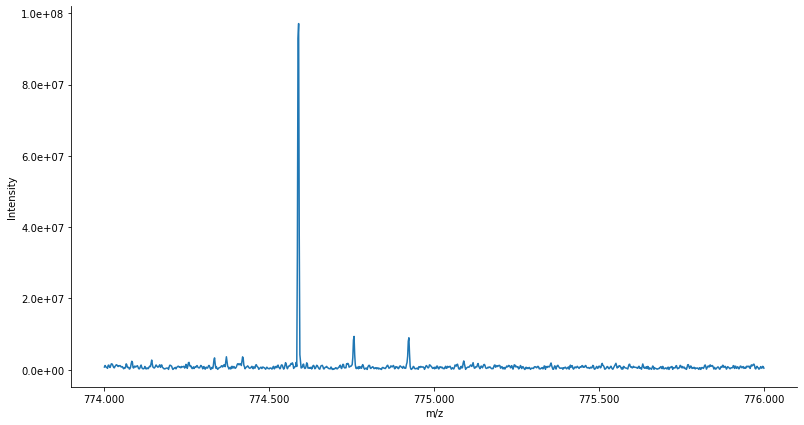

<module 'matplotlib.pyplot' from 'C:\\Users\\yaros\\Anaconda3\\envs\\tf2\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [254]:
plotmasskai(774,776)

In [253]:
peaks

m/z   Intensity     resolution
0      251.546161  2250116.25  223799.453125
1      251.718980  2127568.25  201539.046875
2      252.096534  4875552.00  292064.406250
3      252.133187  2495043.50  195763.796875
4      252.134845  8653351.00  257228.546875
...           ...         ...            ...
3769  2488.026238  2379380.25   67613.328125
3770  2488.953958  2106353.25   61593.484375
3771  2490.683234  2294901.25   71019.343750
3772  2492.588610  1984057.50   58247.511719
3773  2499.070840  1667980.25   57102.750000

[3774 rows x 3 columns]

### Full Spectra calc 

In [51]:
i=1
trans=LoadAvgTrans(lcmf_mono_pept,lcmsms_mono_pept,NumbersOI[i][0])
SpecKai,MagnKai=FormSpec(trans)
m1,m2=HalfSpecs(trans)
peaks=PeakPick(MagnKai,calib,250,2500)
#peaks=SRCalc(peaks)

2523    7871
2529    7880
2541    7898
2535    7889
2547    7907
Name: Scan, dtype: object
61784518.300000004


In [52]:
peaks

m/z    Intensity     resolution
0      251.300592  3498234.500  301669.750000
1      251.344910  1396993.250  180057.140625
2      251.810836  1712295.375  179890.218750
3      252.815800  1908754.375  198088.031250
4      254.149760  2004887.250  238747.328125
...           ...          ...            ...
5476  2484.314438  1765188.125   57271.824219
5477  2485.510291  1841127.625   57258.132812
5478  2487.850205  2043387.125   57797.683594
5479  2495.359228  1698038.750   61208.382812
5480  2496.444539  2326446.500   65909.187500

[5481 rows x 3 columns]

In [ ]:
peaks.to_csv("MonoIons.0.txt",sep="\t")

### Scatter plots

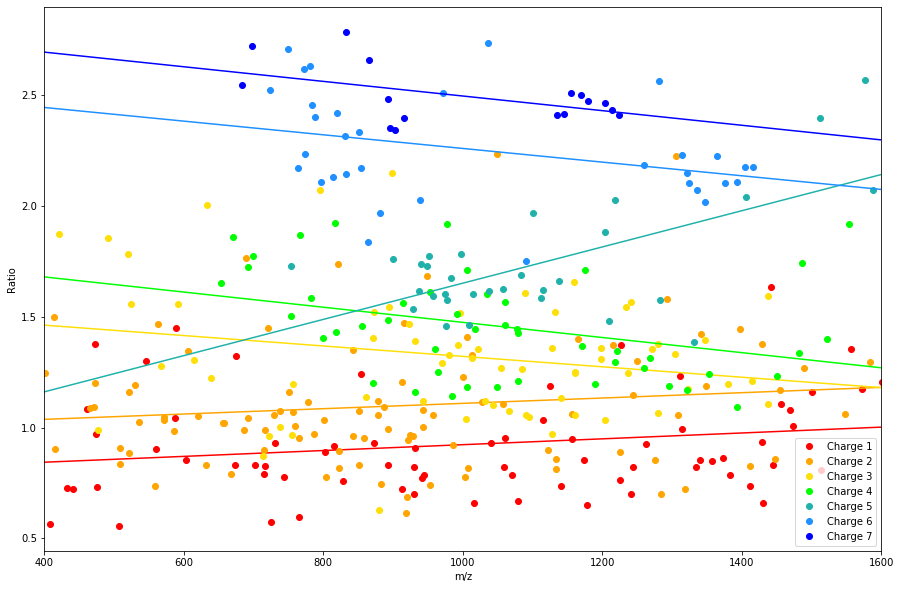

In [238]:
Counter=0
for i in range(1,8):
    Yscat=-FRes["Slope"][FRes["Charge"]==i]
    Xscat=FRes["m/z"][FRes["Charge"]==i]
    plt.plot(Xscat,Yscat,"o",color=colors[i],label="Charge "+str(i))
    s=stats.linregress(Xscat,Yscat)
    lineX=np.linspace(400.,1600,20)
    lineY=lineX*s[0]+s[1]
    plt.plot(lineX,lineY,"-",color=colors[i])
    #for row in FRes[FRes["Charge"]==i].iterrows():
        #plt.annotate(str(row[1]["number"]),(row[1]["m/z"]+5,row[1]["Diff"]))

plt.legend()
plt.xlabel("m/z")
plt.ylabel("Ratio")
plt.xlim(400,1600)
plt.rcParams["figure.figsize"] = (15,10)
plt.show()

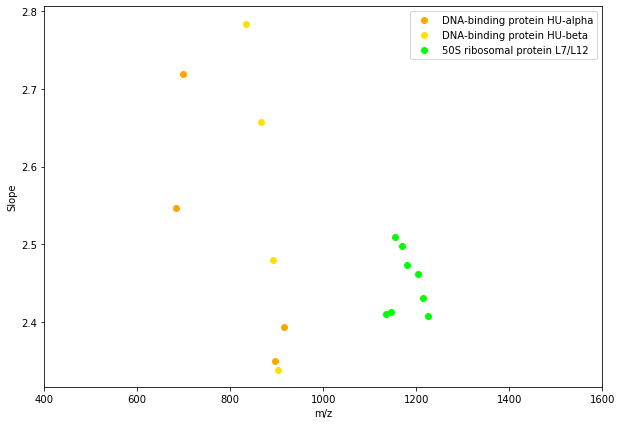

In [279]:
Counter=0
ChargeRes=FRes[FRes["Charge"]==7]
for i in range(1,6):
    Yscat=-ChargeRes["Slope"][ChargeRes["Spectrum"]==i]
    Xscat=ChargeRes["m/z"][ChargeRes["Spectrum"]==i]
    if len(Yscat)==0:
        continue
    plt.plot(Xscat,Yscat,"o",color=colors[i],label=NumbersOI[i-1][4])
    s=stats.linregress(Xscat,Yscat)
    lineX=np.linspace(400.,1600,20)
    lineY=lineX*s[0]+s[1]
    #plt.plot(lineX,lineY,"-",color=colors[i])
    #for row in FRes[FRes["Charge"]==i].iterrows():
        #plt.annotate(str(row[1]["number"]),(row[1]["m/z"]+5,row[1]["Diff"]))

plt.legend()
plt.xlabel("m/z")
plt.ylabel("Slope")
plt.xlim(400,1600)
plt.rcParams["figure.figsize"] = (10,7)
plt.show()

### Spectra Visual

#### Monoisotopic

In [735]:
i=4
trans=LoadAvgTrans(lcmf_mono_pept,lcmsms_mono_pept,NumbersOI[i][0])
SpecKai,MagnKai=FormSpec(trans)
m1,m2=HalfSpecs(trans)

1966    7032
1960    7023
1972    7041
1954    7014
1978    7050
1984    7059
1990    7068
2008    7095
2002    7086
2020    7113
2026    7122
1996    7077
2038    7140
2032    7131
2014    7104
Name: Scan, dtype: object
42935555.64


In [736]:
PPeaks=pd.read_csv("MonoIons.4.txt",sep="\t")

In [737]:
PPeaks["FWHM"]=PPeaks["m/z"]/PPeaks["resolution"]
PPeaks["FWHM Coeff"]=np.power(PPeaks["FWHM"],0.6666)/(PPeaks["m/z"]*3.e-5)

In [738]:
YP,YP_distr=LogisticRegressionApply(PPeaks,MonoLR,MonoScaler,Classes)

C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [739]:
PPeaks["Aver"]=0.0
PPeaks["Sigma"]=0.0
for i in range(len(YP)):
    PPeaks["Aver"].iat[i],PPeaks["Sigma"].iat[i]=weighted_avg_and_std(Classes,YP_distr[i])

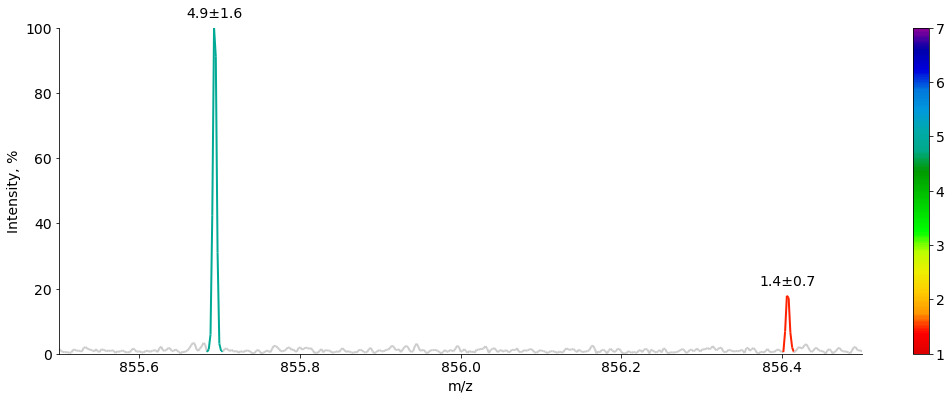

In [746]:
 RainbowSpectrum(855.5,856.5,PPeaks)

#### Full Isotopic

In [747]:
i=4
trans=LoadAvgTrans(lcmf_std_pept,lcmsms_std_pept,NumbersOI[i][1])
SpecKai,MagnKai=FormSpec(trans)
m1,m2=HalfSpecs(trans)

734    29583
728    29574
716    29556
752    29610
746    29601
722    29565
740    29592
Name: Scan, dtype: object
4098421.69


In [748]:
PPeaks=pd.read_csv("FullIons.4.txt",sep="\t")

In [749]:
PPeaks["FWHM"]=PPeaks["m/z"]/PPeaks["resolution"]
PPeaks["FWHM Coeff"]=np.power(PPeaks["FWHM"],0.6666)/(PPeaks["m/z"]*3.e-5)

In [750]:
YP,YP_distr=LogisticRegressionApply(PPeaks,FullLR,FullScaler,Classes)

C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [751]:
PPeaks["Aver"]=0.0
PPeaks["Sigma"]=0.0
for i in range(len(YP)):
    PPeaks["Aver"].iat[i],PPeaks["Sigma"].iat[i]=weighted_avg_and_std(Classes,YP_distr[i])

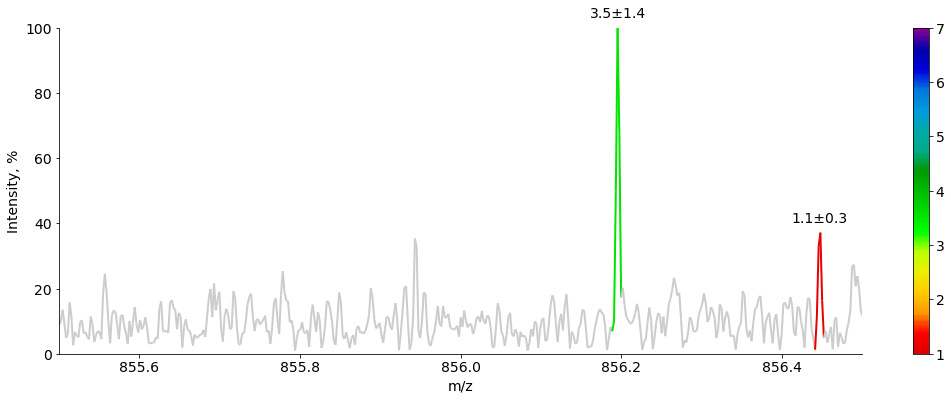

In [754]:
 RainbowSpectrum(855.5,856.5,PPeaks,LabelThres=0.3)

### Clusters over charges

In [714]:
PPeaks["Ions"]=""

In [715]:
i=4
covers=[]
Charge=3
for Charge in range(1,8):
    CPeaks=PPeaks[YP_distr[:,Charge-1]>0.1]
    CPeaks["Mass"]=(CPeaks["m/z"]-Proton)*Charge
    CPeaks["Charge"]=Charge
    CPeaks,cSet,cover=Products(CPeaks,NumbersOI[i][3],ppm=20)
    Ions=CPeaks[CPeaks["Ions"]!=""]["Ions"]+" "+CPeaks[CPeaks["Ions"]!=""]["Charge"].apply(str)+"+"
    for ind in Ions.index:
        PPeaks["Ions"].iat[ind]=PPeaks["Ions"].iat[ind]+" "+Ions[ind]
    covers.append(cSet)

C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

b3 1+
b4 1+
b5 1+
b6 1+
b7 1+
b10 1+
b11 1+
b12 1+
b13 1+
b14 1+
24
b8 2+
b9 2+
b10 2+
b11 2+
b12 2+
b13 2+
b14 2+
b15 2+
b16 2+
b17 2+
b18 2+
a19 2+
b19 2+
b20 2+
a21 2+
b22 2+
b23 2+
b24 2+
b26 2+
b27 2+
b29 2+
b30 2+
26
a18 3+
b18 3+
a19 3+
b19 3+
a20 3+
b20 3+
b21 3+
b22 3+
b23 3+
b24 3+
b25 3+
b26 3+
a27 3+
b27 3+
a28 3+
b28 3+
b29 3+
a30 3+
b30 3+
a31 3+
b31 3+
b32 3+
b33 3+
b34 3+
b35 3+
b35 3+
b36 3+
b37 3+
b38 3+
b39 3+
a40 3+
b40 3+
c40 3+
b41 3+
b43 3+
b44 3+
b45 3+
b46 3+
b49 3+
b50 3+
31
b31 4+
b32 4+
a34 4+
a34 4+
b34 4+
a35 4+
c35 4+
a36 4+
b37 4+
b38 4+
b39 4+
c39 4+
a40 4+
b40 4+
c40 4+
b41 4+
b42 4+
a43 4+
b46 4+
c46 4+
a47 4+
c47 4+
a49 4+
a50 4+
a51 4+
b51 4+
a52 4+
b53 4+
b54 4+
b55 4+
b56 4+
c56 4+
b57 4+
c57 4+
b59 4+
b62 4+
28
b36 5+
b39 5+
b42 5+
a43 5+
b43 5+
a44 5+
b44 5+
a45 5+
b45 5+
b46 5+
c46 5+
a47 5+
b47 5+
c47 5+
c47 5+
a48 5+
b48 5+
a49 5+
a50 5+
a51 5+
b51 5+
a52 5+
a53 5+
b53 5+
c53 5+
b54 5+
b55 5+
b56 5+
c56 5+
a57 5+
b57 5+
c57 5+
c57 5+
b58 5+
a

In [718]:
PPeaks[(PPeaks["m/z"]>850) & (PPeaks["m/z"]<900) & (PPeaks["Ions"] != "")]

Unnamed: 0  index         m/z    Intensity  resolution     Slope  \
287         287   9839  850.779641   34470790.0  160050.270 -1.362670   
289         289   9843  851.466642   41979100.0  153413.100 -0.831812   
295         295   9859  855.693999  112248070.0  159594.170 -1.459447   
302         302   9874  864.605899  152700290.0  157242.200 -1.834697   
307         307   9884  869.785299    6253826.0  120629.414 -2.594941   
312         312   9896  876.451804    9420954.0  174019.080 -2.095832   
317         317   9905  881.117298  159560420.0  155199.550 -1.967485   
325         325   9923  892.460500  126028710.0  152876.670 -1.483660   
332         332   9938  898.796457   12837811.0  158559.250 -2.147473   

     Intercept   RSquare     Ratio      FWHM  FWHM Coeff      Aver     Sigma  \
287   3.922626 -0.964478  2.733812  0.005316    1.193769  3.891178  1.478474   
289   3.720684 -0.946891  1.938555  0.005550    1.227623  2.380821  1.189809   
295   5.153701 -0.997731  3.044788  0.005362    1.193748  4.932453  1.576855   
302   5.724778 -0.997696  4.439331  0.005499    1.201464  6.184853  0.824510   
307   3.039440 -0.888211  3.273847  0.007210    1.430810  4.746224  1.174237   
312   3.118992 -0.956282  2.631519  0.005037    1.117870  4.514145  1.515493   
317   5.849548 -0.996339  4.366615  0.005677    1.204362  6.236459  0.812103   
325   5.283647 -0.996844  2.969581  0.005838    1.211352  4.899280  1.587827   
332   3.397400 -0.922263  2.125649  0.005669    1.179452  4.156972  1.538465   

        Ions  
287   b23 3+  
289   b15 2+  
295   b31 4+  
302   b48 6+  
307   b24 3+  
312   a49 6+  
317   b49 6+  
325   b32 4+  
332   b25 3+

In [732]:
AllPeaks[(AllPeaks["m/z"]>850) & (AllPeaks["m/z"]<900) & (AllPeaks["Ions"] != "")][79:][["m/z","Charge","Ions"]]

m/z  Charge Ions
498  899.292273      10  y88
952  855.484750       1   y9
953  864.772573       6  b48
954  864.939893       6  b48
955  865.107912       6  b48
956  892.710559       4  b32
957  892.961453       4  b32
958  893.212081       4  b32

In [495]:
Chrcover=[]
for i1 in range(len(covers[0])):
    Prod=[]
    for j in range(len(covers)):
        Prod = Prod+covers[j][i1]
    Chrcover.insert(len(Chrcover),Prod)

In [496]:
frags=0
sites=0
for l in Chrcover:
    if len(l)>0:
        frags+=len(l)
        sites+=1
print(frags,sites,sites/len(NumbersOI[i][3]))

221 64 0.9411764705882353


In [456]:
len(NumbersOI[1][3])

90